In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn; seaborn.set_style('whitegrid')
import pomegranate

### 0. Data prep

In [34]:
# merge the two df
parkhaus_occupancies_df = pd.read_csv('../../data/car parks in mannheim/car_park_occupancy_timeseries.csv')
parkhaus_occupancies_df = parkhaus_occupancies_df.drop_duplicates()
parkhaus_locations_df = pd.read_csv('../../data/car parks in mannheim/car_park_locations_and_prices.csv')
parkhaus_occupancies_df = pd.merge(parkhaus_occupancies_df, parkhaus_locations_df, on='parkhaus_name', how='inner')

# oups, I gave the column the wrong name: it measure the number of free spaces, not the occupancy..
parkhaus_occupancies_df['parkhaus_free_spaces'] = parkhaus_occupancies_df['parkhaus_occupancy']
parkhaus_occupancies_df['parkhaus_occupancy'] = parkhaus_occupancies_df['total_number_of_places'] - parkhaus_occupancies_df['parkhaus_free_spaces']
parkhaus_occupancies_df['percent_occupied'] = parkhaus_occupancies_df['parkhaus_occupancy']/parkhaus_occupancies_df['total_number_of_places']

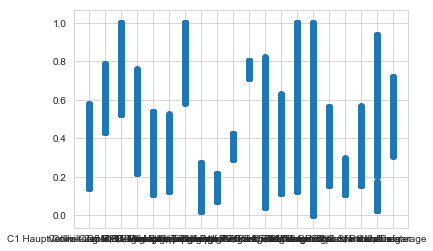

In [36]:
x = parkhaus_occupancies_df['parkhaus_name']
y = parkhaus_occupancies_df['percent_occupied']
plt.scatter(x, y)
plt.show()

In [24]:

# remove dauerstellplaetze
parkhaus_occupancies_df['parkhaus_occupancy'] = parkhaus_occupancies_df['parkhaus_occupancy']- parkhaus_occupancies_df['dauerstellplaetze']
parkhaus_occupancies_df['total_number_of_places'] = parkhaus_occupancies_df['total_number_of_places'] - parkhaus_occupancies_df['dauerstellplaetze']

# additional columns
parkhaus_occupancies_df['percent_occupied'] = parkhaus_occupancies_df['parkhaus_occupancy']/parkhaus_occupancies_df['total_number_of_places']
parkhaus_occupancies_df['adjusted_longitude'] = [(long- 49.483)*150 for long in parkhaus_occupancies_df['longitude'] ]
parkhaus_occupancies_df['adjusted_latitude'] =  (parkhaus_occupancies_df['latitude'] - 8.459)*100
parkhaus_occupancies_df['datetime'] = pd.to_datetime(parkhaus_occupancies_df['unix_timestamp'],unit='s')
parkhaus_occupancies_df.index = parkhaus_occupancies_df['datetime']

parkhaus_occupancies_df['average_cost'] = parkhaus_occupancies_df['cost 0-15 min']*0.05 \
                                        + parkhaus_occupancies_df['cost 15-30 min']*0.05 \
                                        + parkhaus_occupancies_df['cost 31-60 min']*0.1 \
                                        + parkhaus_occupancies_df['cost 1-2 hours']*0.21 \
                                        + parkhaus_occupancies_df['cost 2-3 hours']*0.47 \
                                        + parkhaus_occupancies_df['cost 3-4 hours']*0.09 \
                                        + parkhaus_occupancies_df['cost 4-5 hours']*0.024 \
                                        + parkhaus_occupancies_df['cost 5-6 hours']*0.006 

# 1. Demand(price)

In [340]:
investigated_time_df = parkhaus_occupancies_df

In [263]:
active_times_df = parkhaus_occupancies_df.between_time('13:01', '17:00')
active_times_df['datetime'].dt.weekday.between(0,4)
investigated_time_df = active_times_df

In [267]:
saturday_lunch_time_df = parkhaus_occupancies_df[parkhaus_occupancies_df['Zeit']=='19.04.2021, 13:00 Uhr']
investigated_time_df = saturday_lunch_time_df

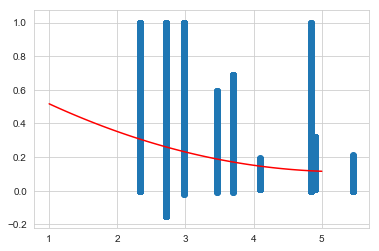

        2
0.0215 x - 0.2292 x + 0.7246


In [341]:
x = investigated_time_df['average_cost']
y = investigated_time_df['percent_occupied']
mymodel = np.poly1d(np.polyfit(x, y, 2))

myline = np.linspace(1, 5, 100)

plt.scatter(x, y)
plt.plot(myline, mymodel(myline),'r')
plt.show()
print(mymodel)

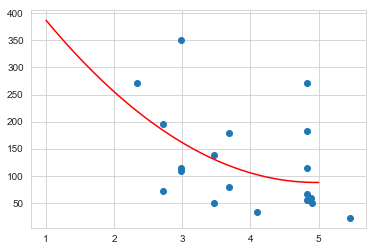

       2
19.09 x - 189.5 x + 557.6


In [269]:
x = investigated_time_df['average_cost']
y = investigated_time_df['parkhaus_occupancy']
mymodel = np.poly1d(np.polyfit(x, y, 2))

myline = np.linspace(1, 5, 100)

plt.scatter(x, y)
plt.plot(myline, mymodel(myline),'r')
plt.show()
print(mymodel)

### independence of price and time

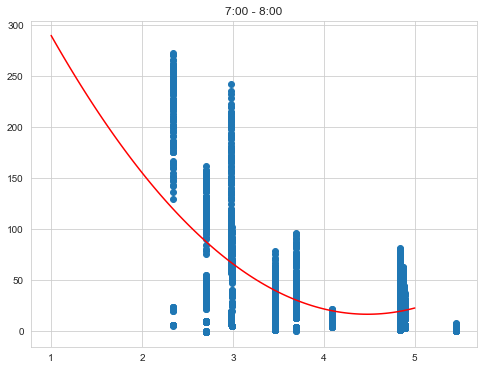

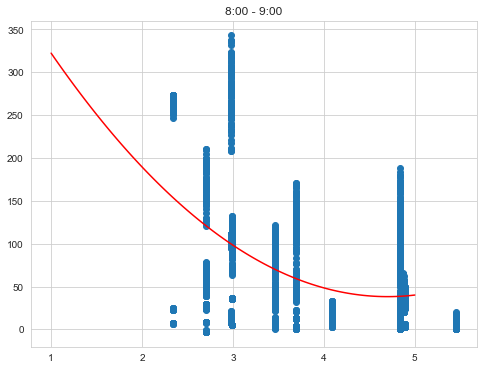

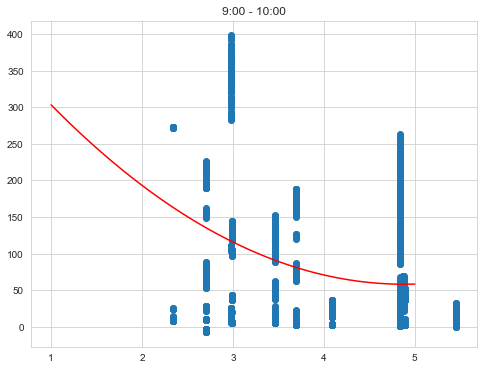

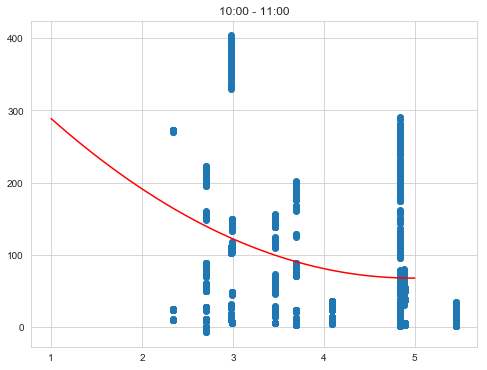

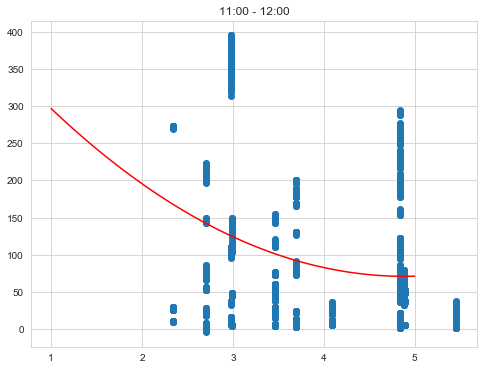

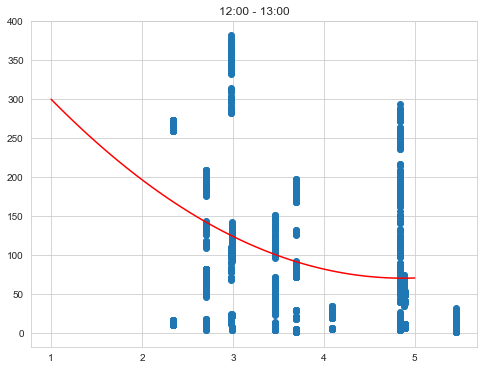

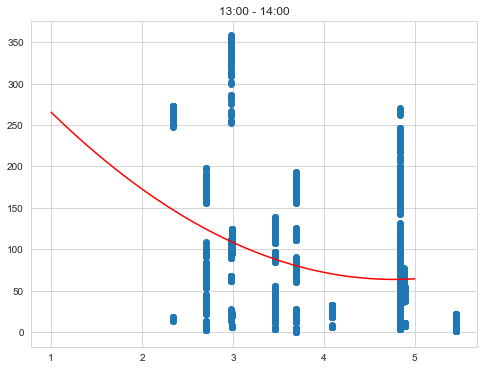

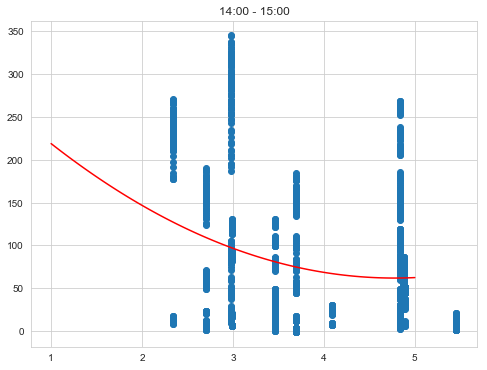

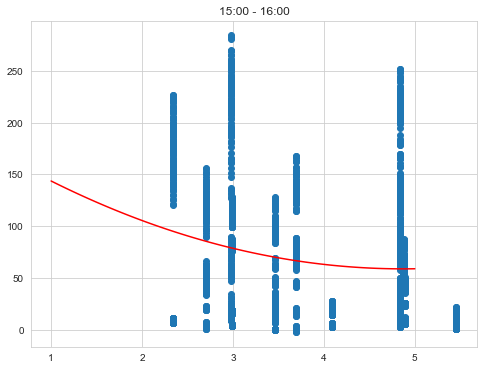

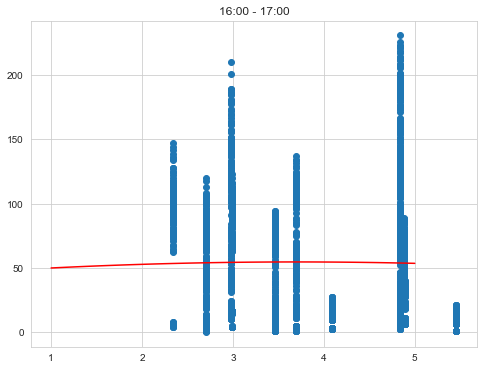

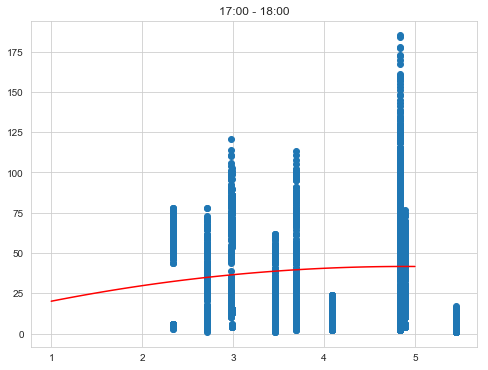

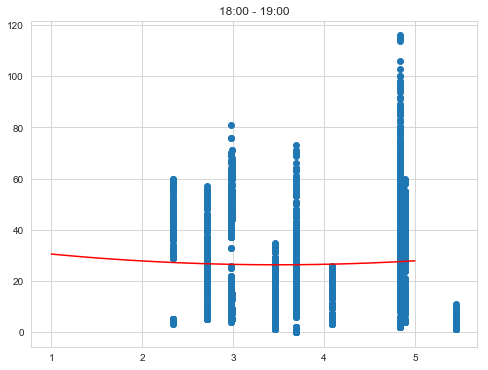

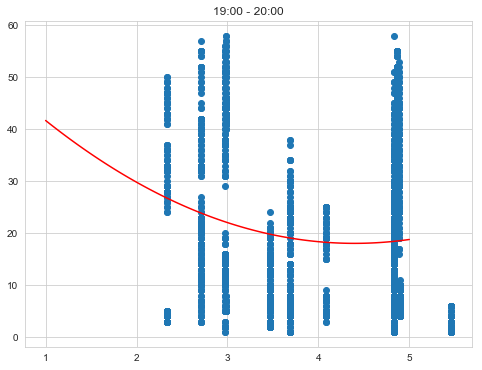

In [270]:
for hour in range(7,16):
    active_times_df = parkhaus_occupancies_df.between_time(str(hour) + ':00', str(hour + 1) + ':00')
    active_times_df['datetime'].dt.weekday.between(0,4)
    investigated_time_df = active_times_df

    x = investigated_time_df['average_cost']
    y = investigated_time_df['parkhaus_occupancy']
    mymodel = np.poly1d(np.polyfit(x, y, 2))

    myline = np.linspace(1, 5, 100)
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y)
    plt.plot(myline, mymodel(myline),'r')
    plt.title('%s:00 - %s:00' % (hour, hour+1))                   
    plt.savefig('./plots - price vs time/hour_%s.png' % hour)

### independence price and location

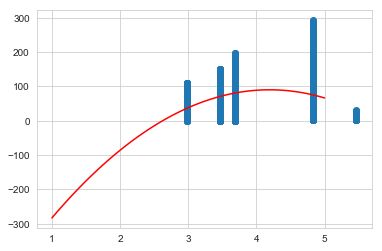

In [334]:
# investigated_time_df = parkhaus_occupancies_df[parkhaus_occupancies_df['is_in_east']==0]
investigated_time_df = parkhaus_occupancies_df[parkhaus_occupancies_df['is_in_quadrate']==1]
investigated_time_df = investigated_time_df.between_time('12:00', '16:00')

x = investigated_time_df['average_cost']
y = investigated_time_df['parkhaus_occupancy']
mymodel = np.poly1d(np.polyfit(x, y, 2))

myline = np.linspace(1, 5, 100)

plt.scatter(x, y)
plt.plot(myline, mymodel(myline),'r')
plt.show()

# 2. Geographic

### 2.1 scatterplot

In [325]:
parkhaus_occupancies_df['percent_occupied'].max()

1.0

In [322]:
data_for_mm_df = parkhaus_occupancies_df[parkhaus_occupancies_df['Zeit']=='19.04.2021, 13:00 Uhr']
data_for_mm_df[['parkhaus_name','longitude', 'latitude', 'average_cost','parkhaus_occupancy', 'parkhaus_free_spaces','total_number_of_places','percent_occupied']].to_csv("data - for tableau scatter/monday_0oclock.csv")

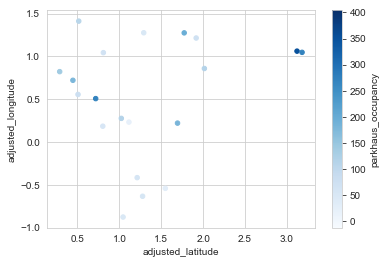

In [323]:
# scatterplot
data_for_mm_df.plot.scatter(x="adjusted_latitude", y="adjusted_longitude", c="parkhaus_occupancy",vmin=-13,vmax=404,cmap=plt.get_cmap("Blues"));

In [291]:
# prepare data
X_positions = np.array(data_for_mm_df[['adjusted_latitude', 'adjusted_longitude' ]])
weights = np.array(data_for_mm_df['parkhaus_occupancy'])

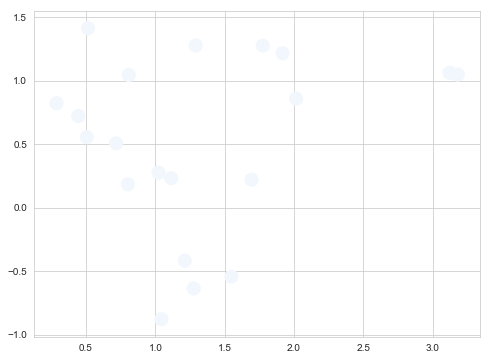

In [321]:
plt.figure(figsize=(8, 6))
plt.scatter(X_positions[:,0], X_positions[:,1], c=weights, edgecolors='None',vmin=-13,vmax=404,cmap=plt.get_cmap("Blues"), label=weights, s=200)
plt.show()

### 2.2 Gaussian Mixture Model (GMM)

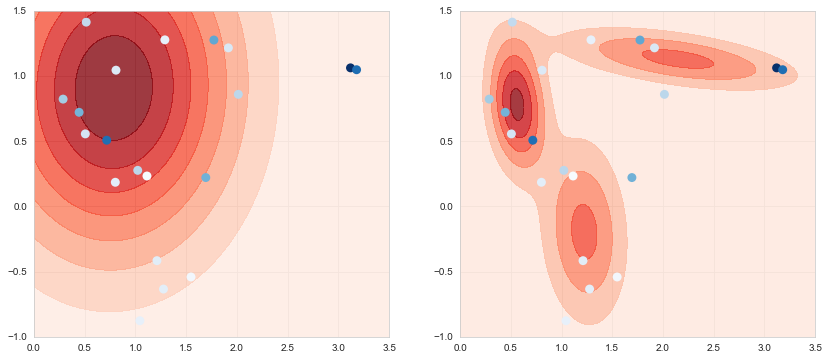

In [302]:
x = np.linspace(0,3.5,500)
y = np.linspace(-1,1.5,500)

xx, yy = np.meshgrid(x, y)
x_ = np.array(list(zip(xx.flatten(), yy.flatten())))

model = pomegranate.MultivariateGaussianDistribution
p1 = model.from_samples(X_positions,weights = weights).probability(x_).reshape(len(x), len(y))
p2 = pomegranate.gmm.GeneralMixtureModel.from_samples(pomegranate.MultivariateGaussianDistribution, 3, X_positions).probability(x_).reshape(len(x), len(y))

plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.contourf(xx, yy, p1, cmap='Reds', alpha=0.8)
plt.scatter(X_positions[:,0], X_positions[:,1], c=weights, edgecolors='None',cmap=plt.get_cmap("Blues"), s=80)

plt.subplot(122)
plt.contourf(xx, yy, p2, cmap='Reds', alpha=0.8)
plt.scatter(X_positions[:,0], X_positions[:,1], c=weights, edgecolors='None',cmap=plt.get_cmap("Blues"), s=80)
plt.show()


### 2.3 Scatterplot over time

In [303]:
# all_data_for_mm_df = parkhaus_occupancies_df.between_time('7:00', '20:00')
all_data_for_mm_df = parkhaus_occupancies_df[parkhaus_occupancies_df['unix_timestamp']>=1618790400]
# all_data_for_mm_df['datetime'].dt.weekday.between(0,4)
all_data_for_mm_df = all_data_for_mm_df[all_data_for_mm_df['unix_timestamp']%900==0]
all_data_for_mm_df = all_data_for_mm_df.sort_values('unix_timestamp')



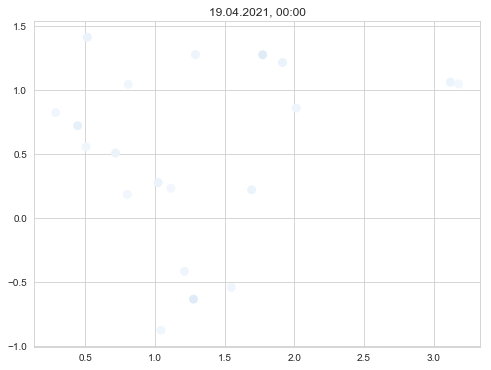

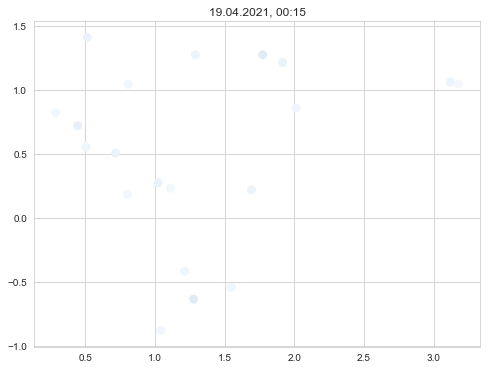

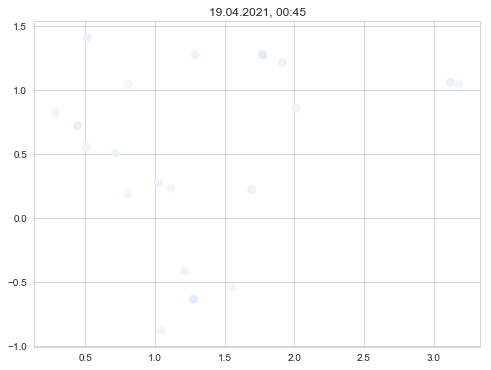

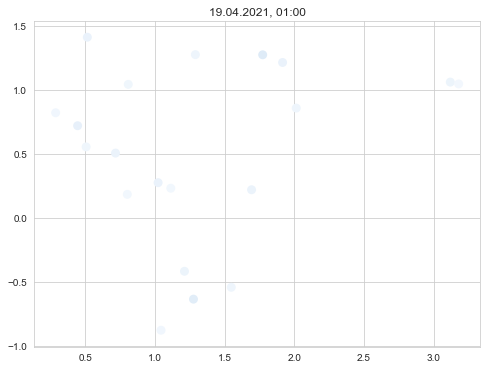

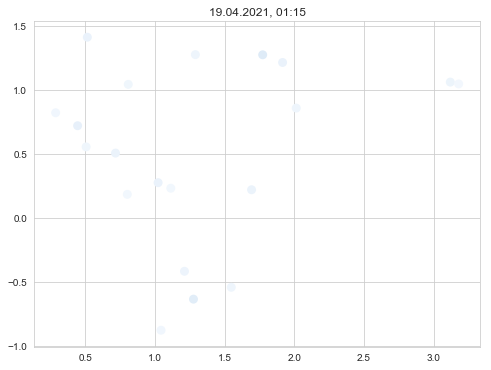

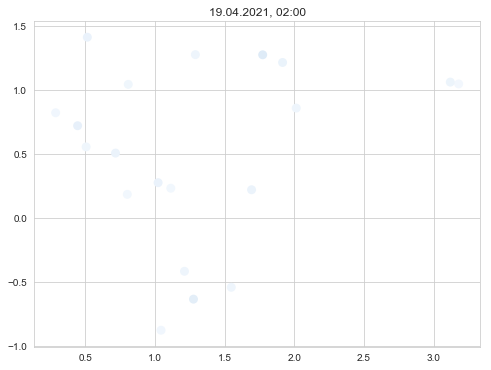

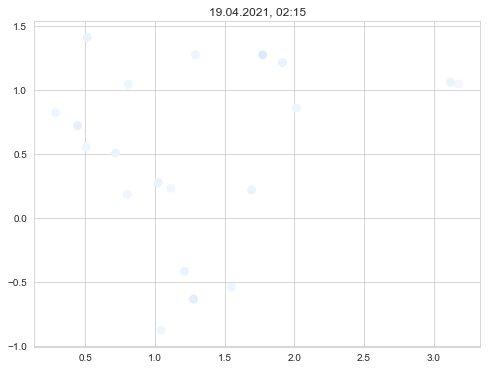

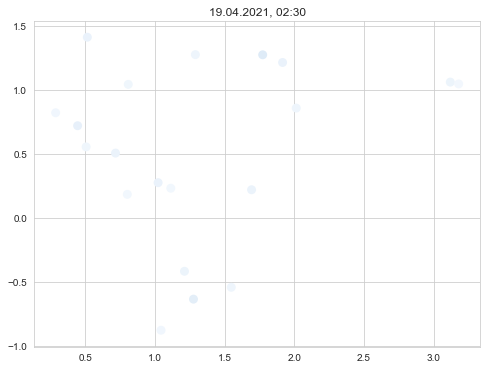

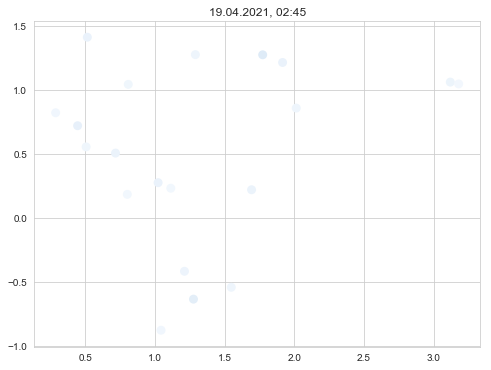

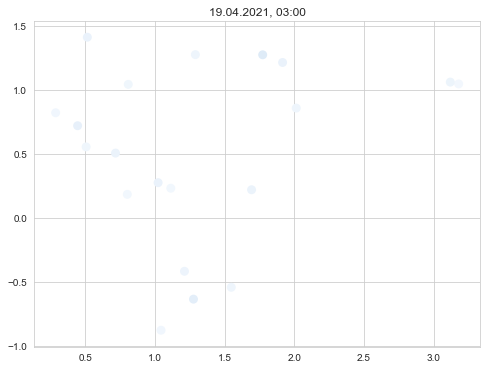

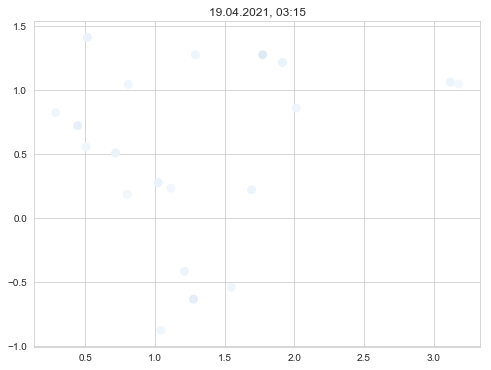

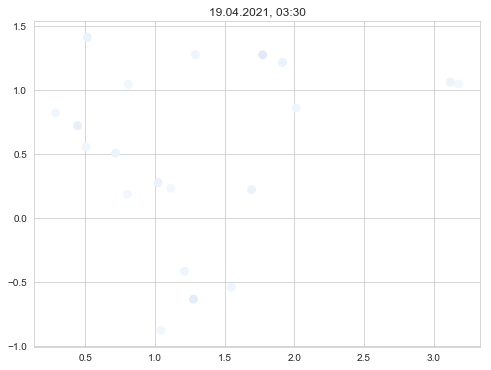

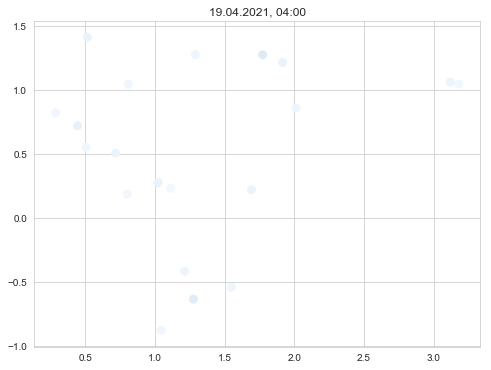

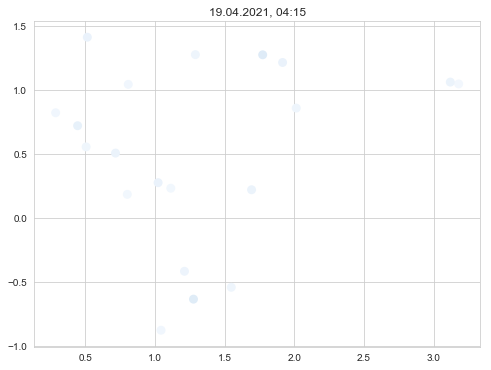

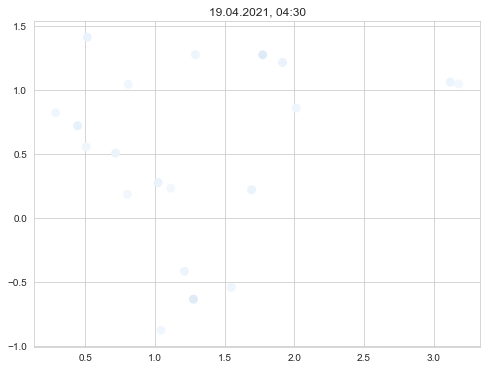

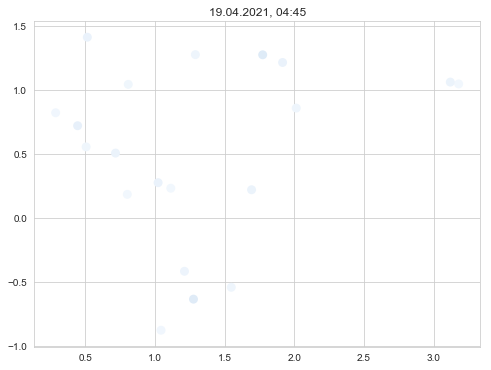

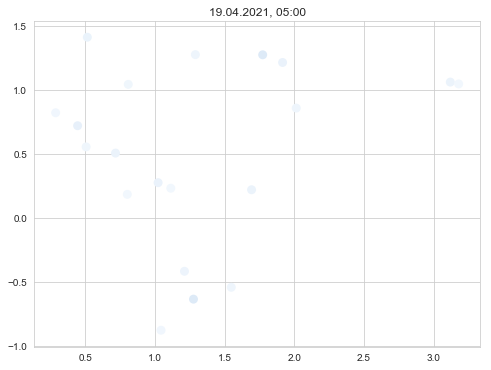

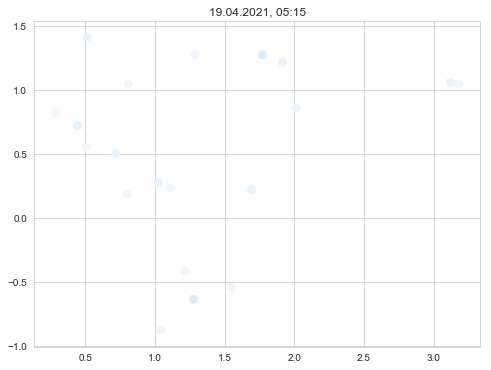

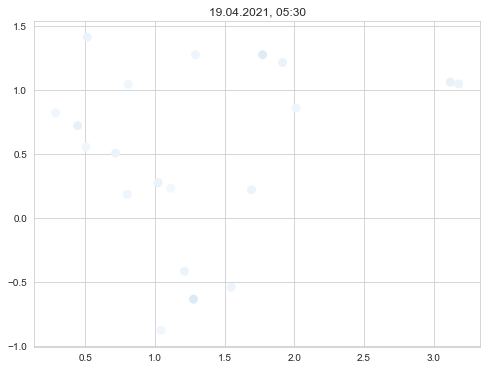

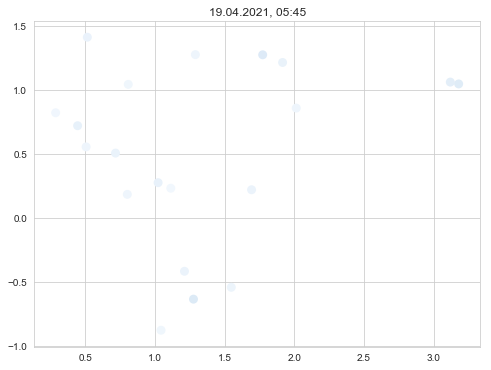

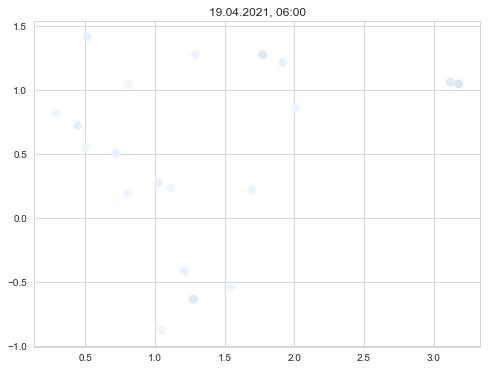

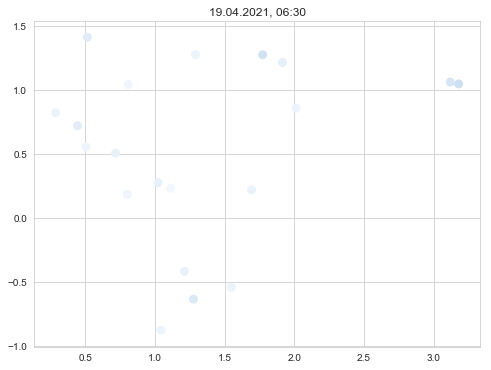

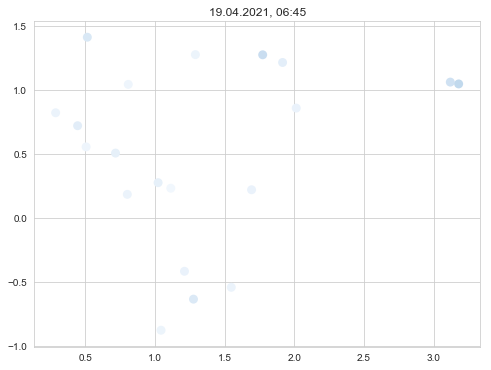

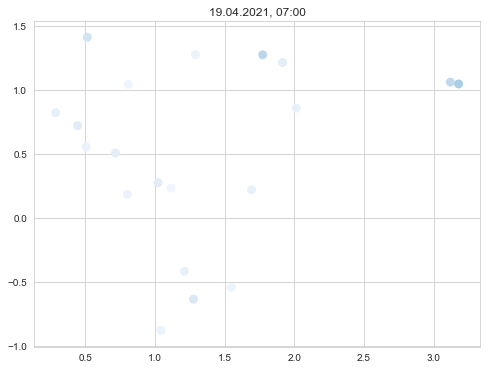

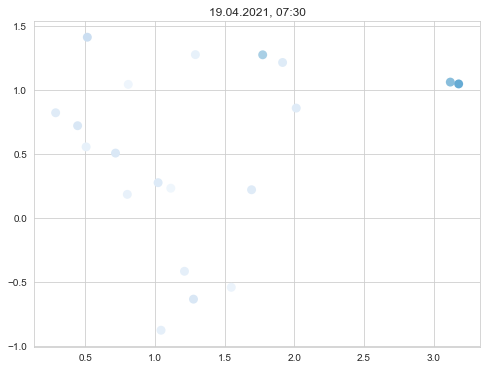

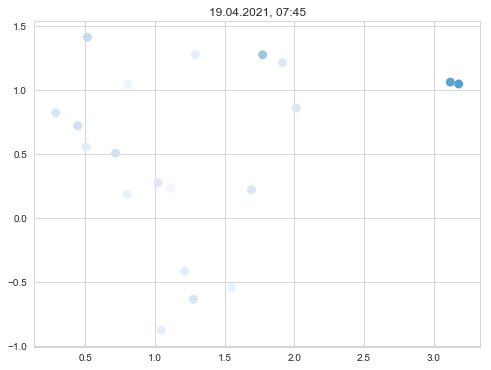

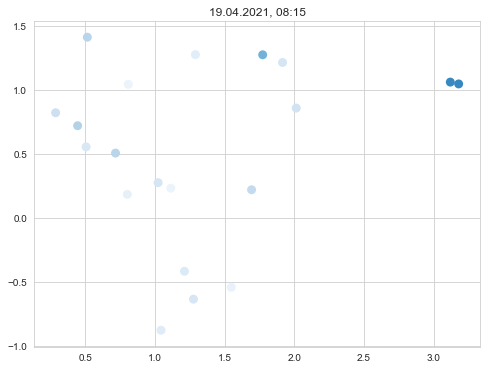

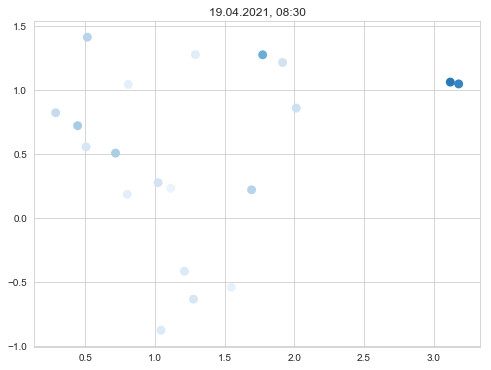

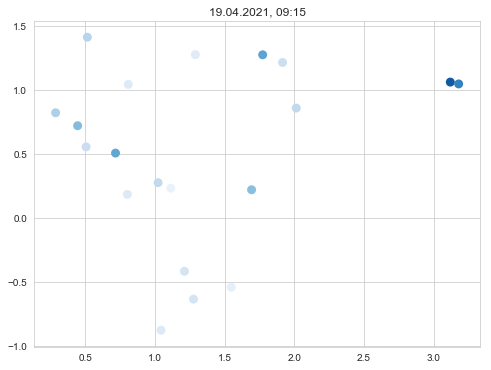

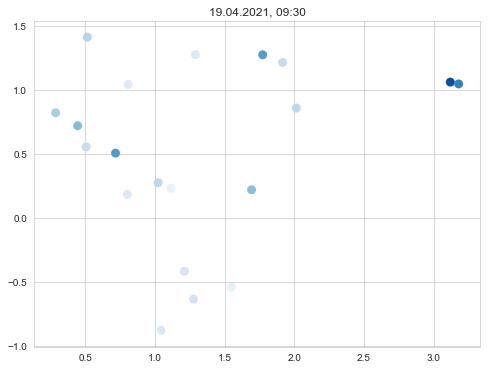

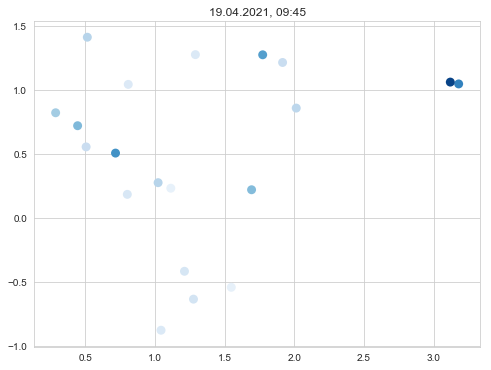

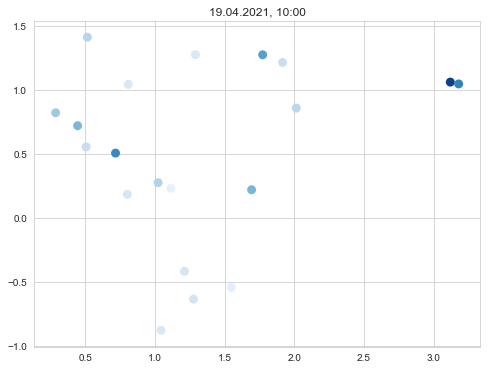

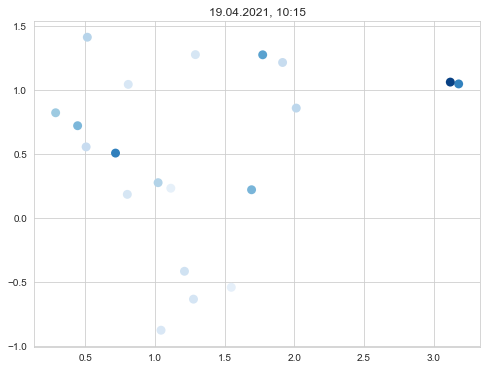

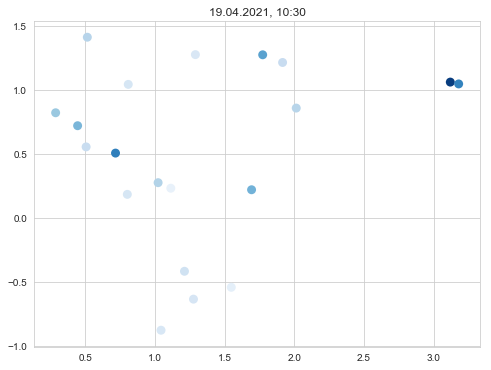

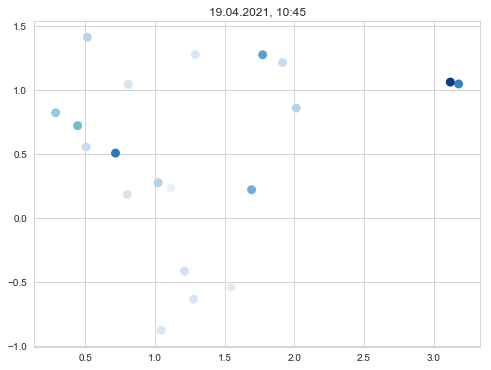

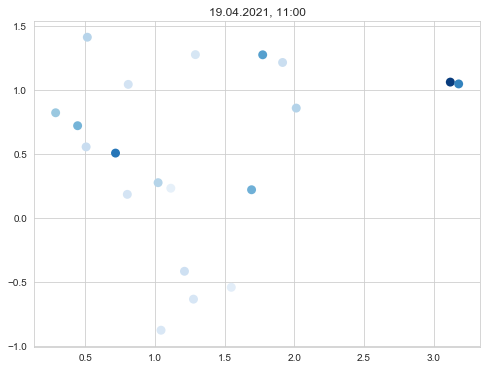

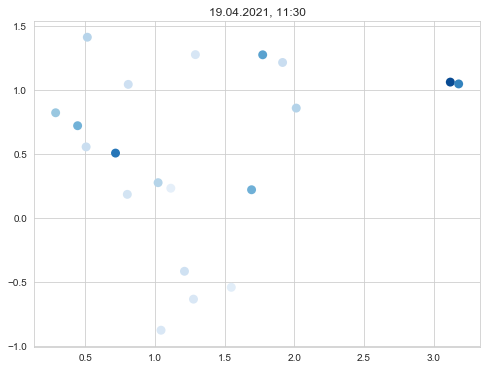

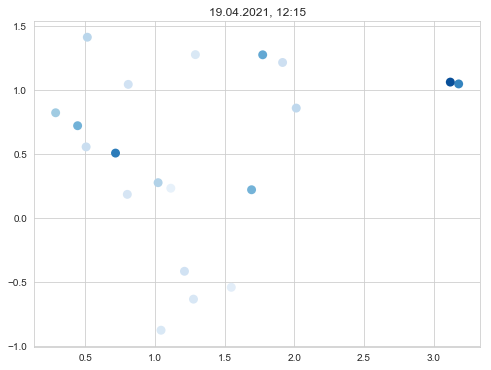

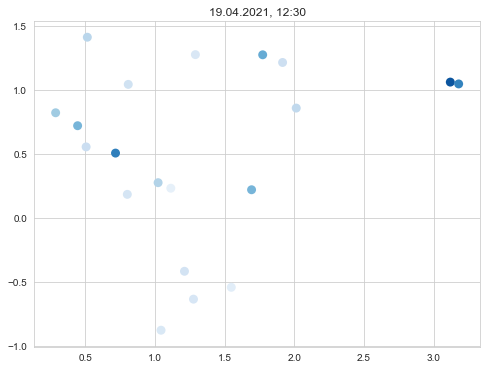

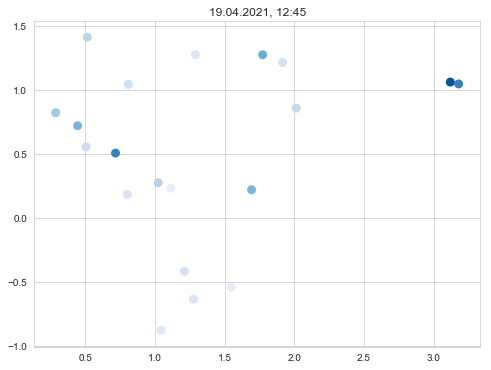

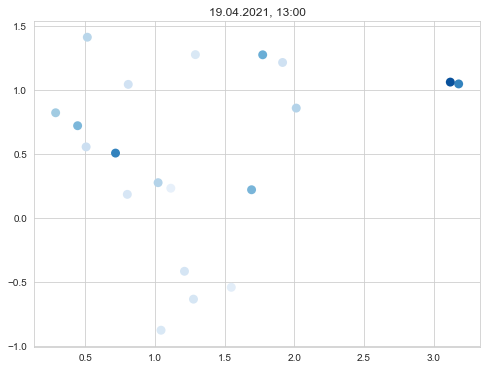

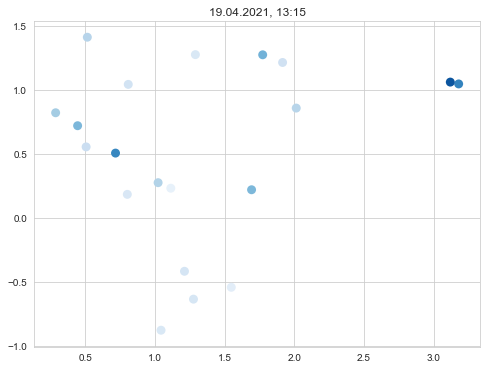

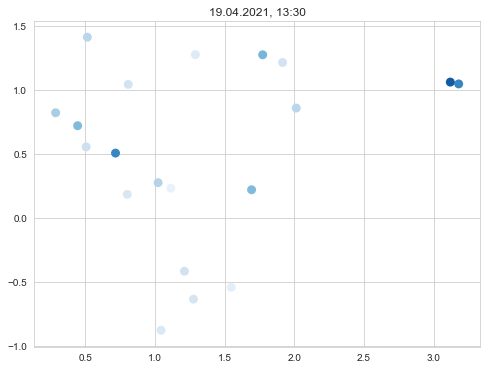

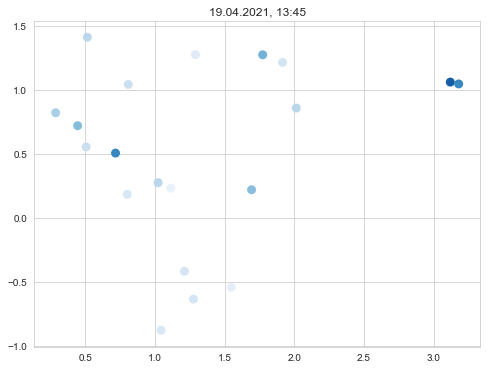

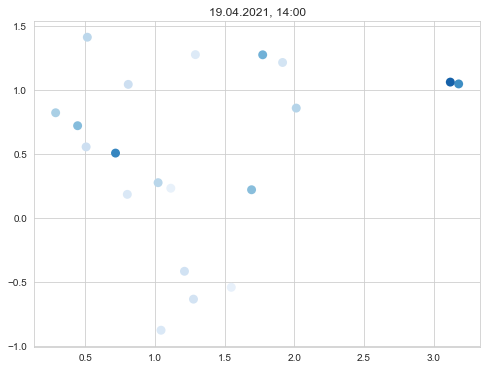

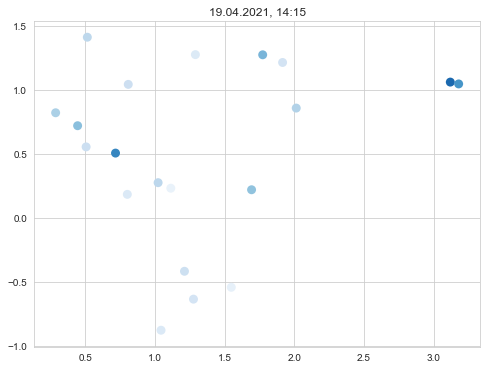

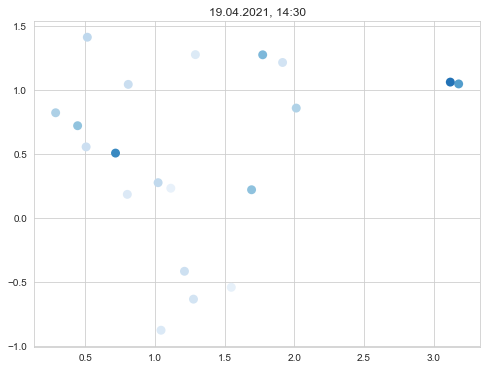

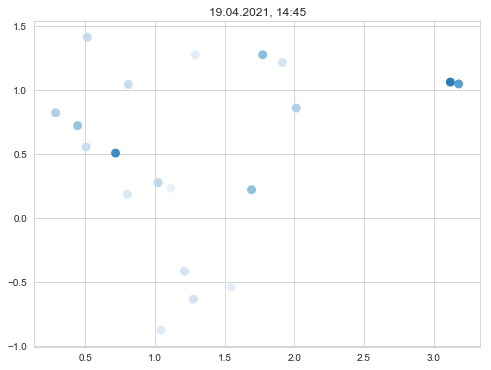

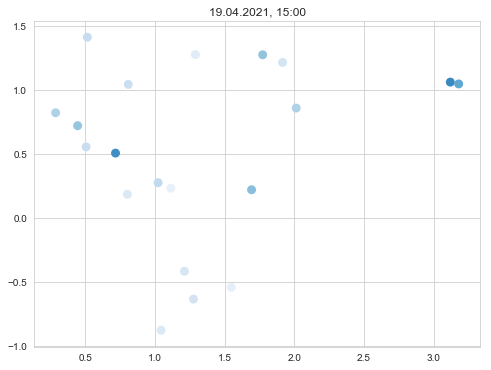

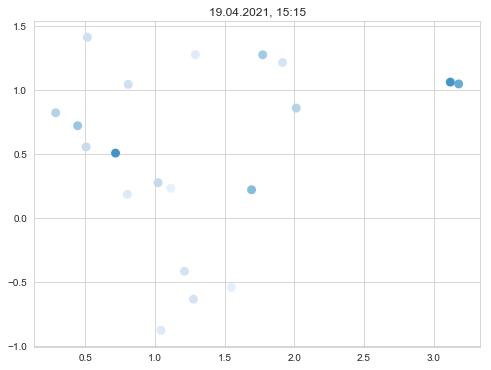

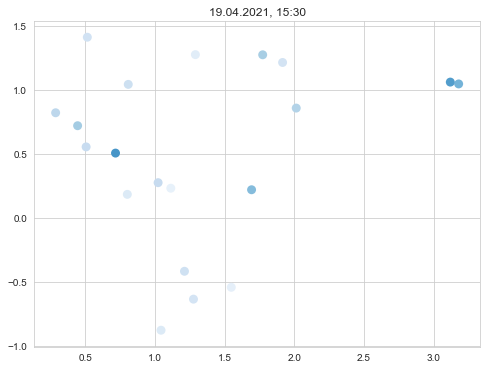

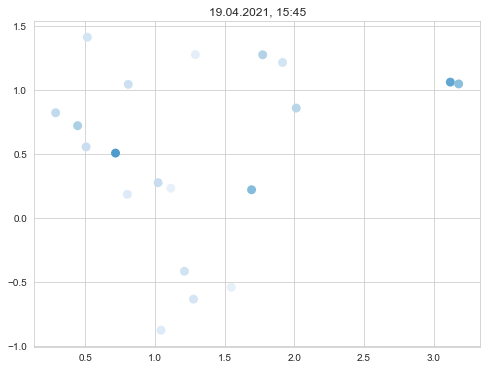

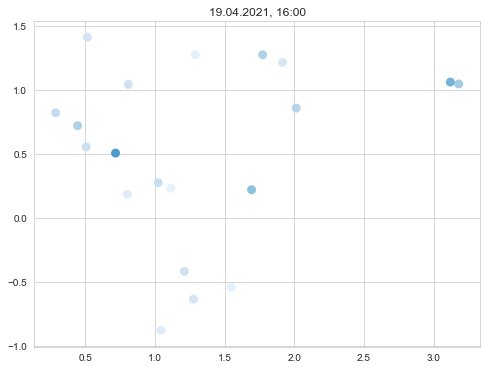

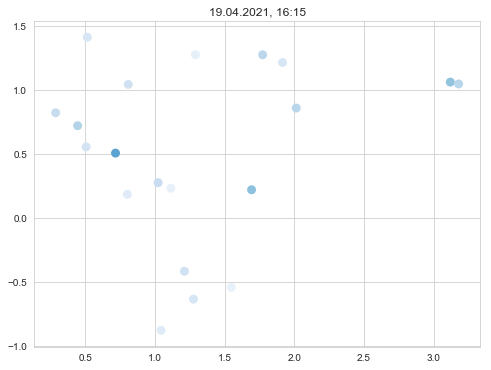

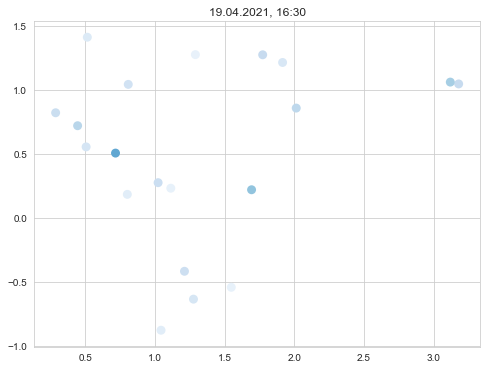

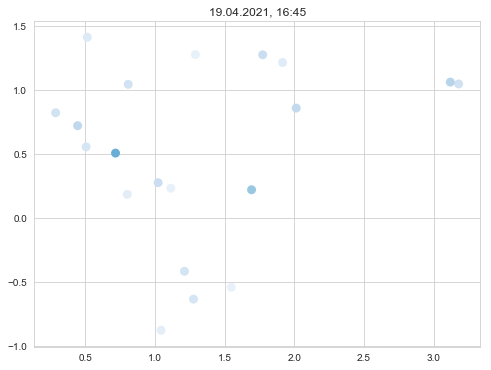

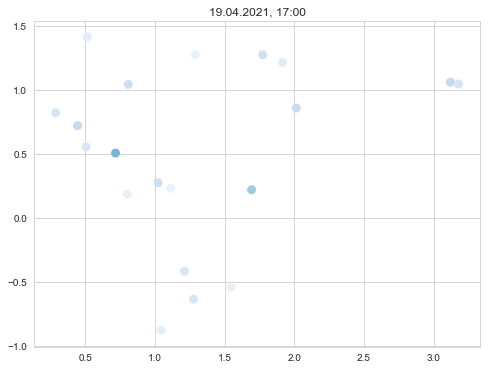

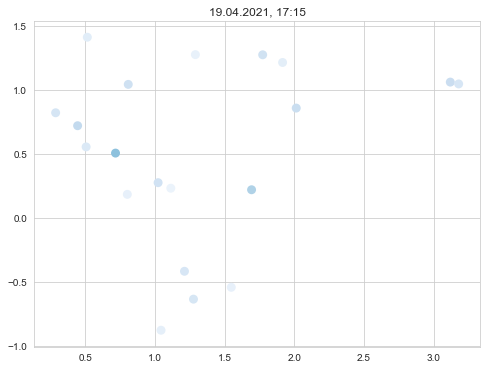

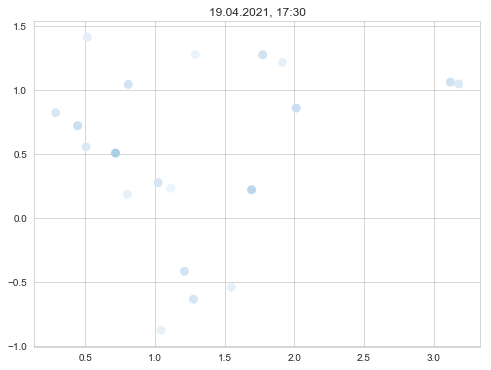

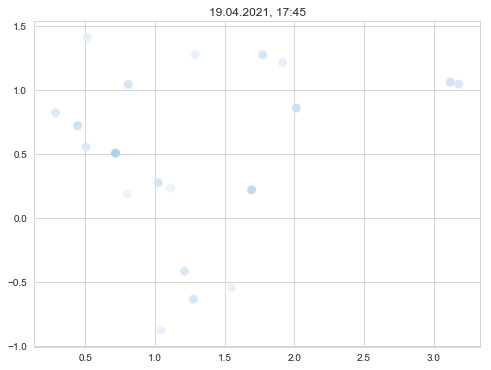

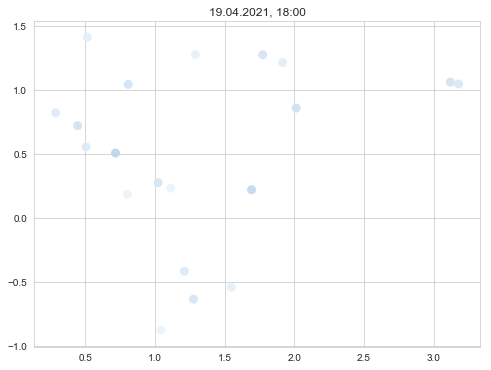

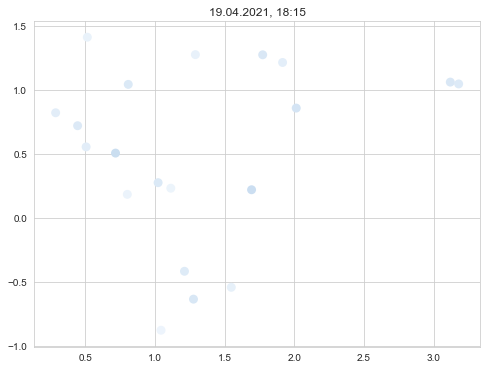

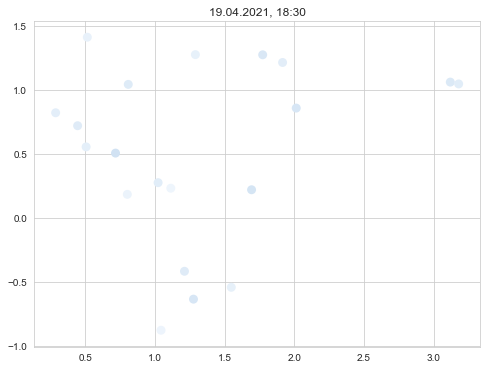

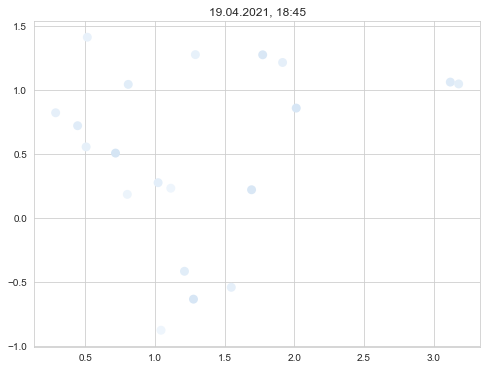

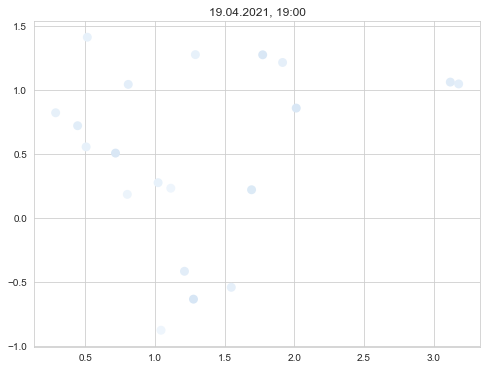

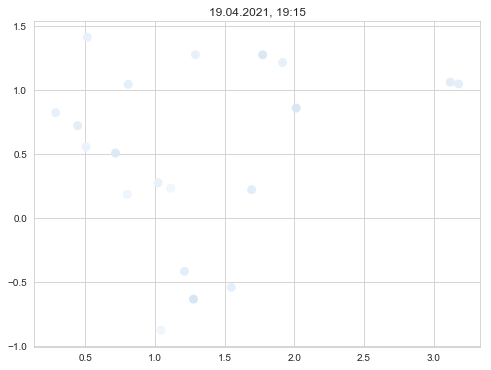

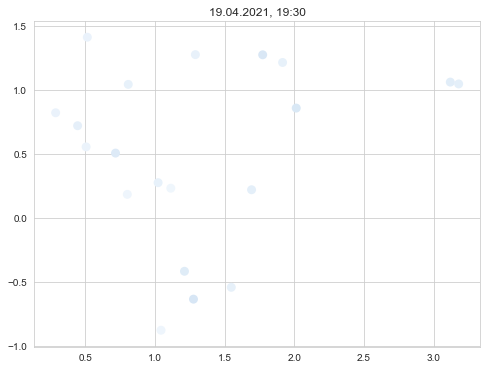

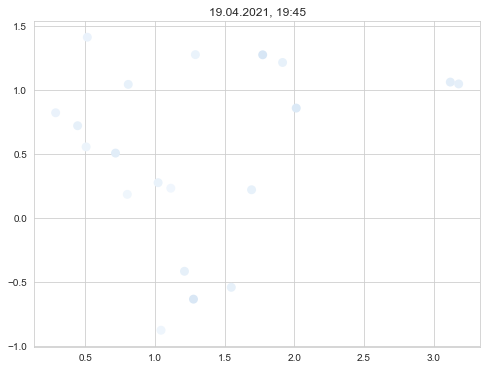

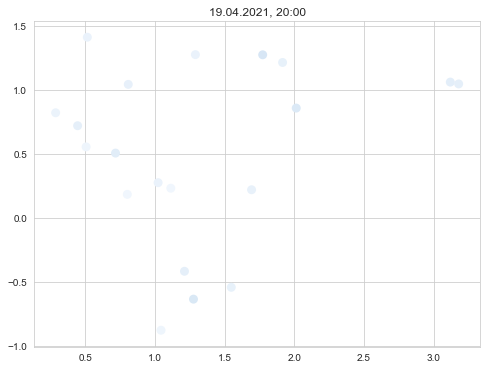

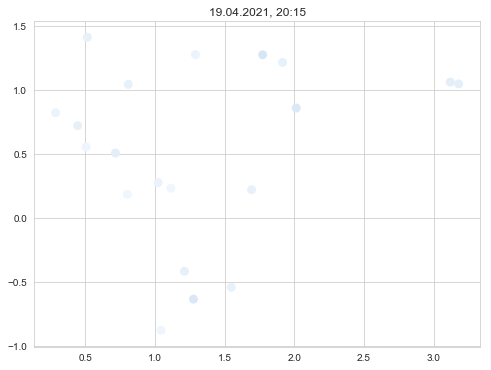

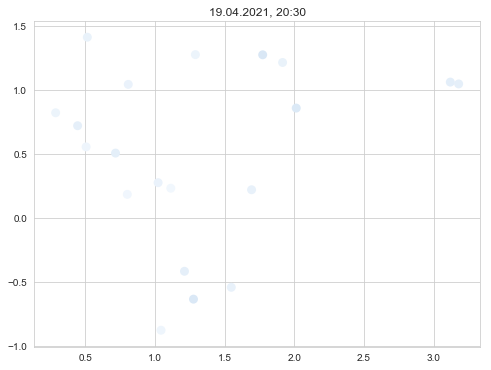

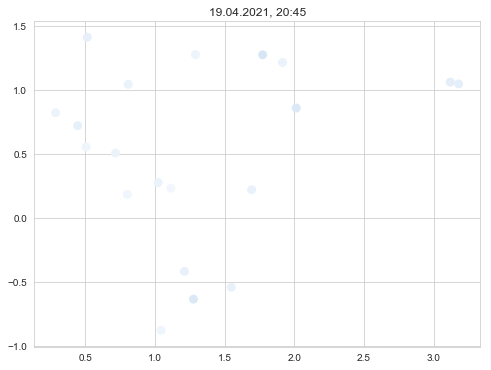

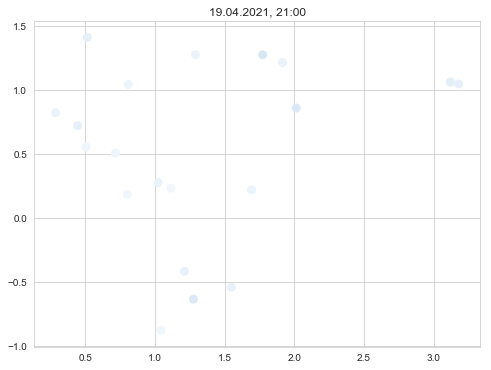

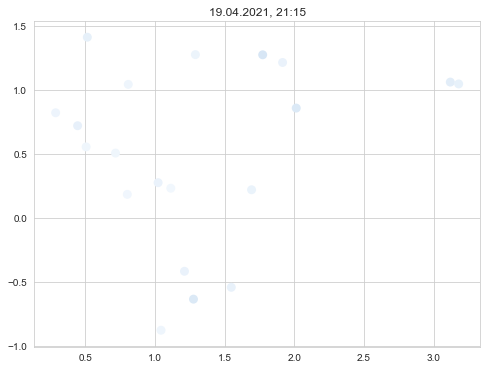

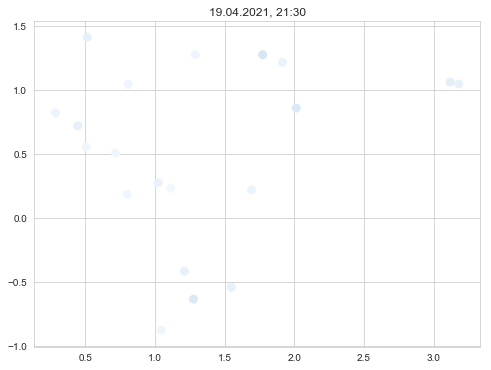

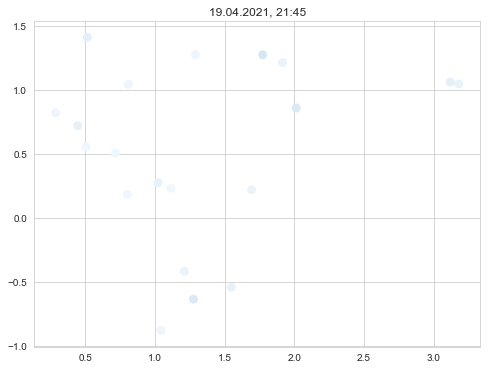

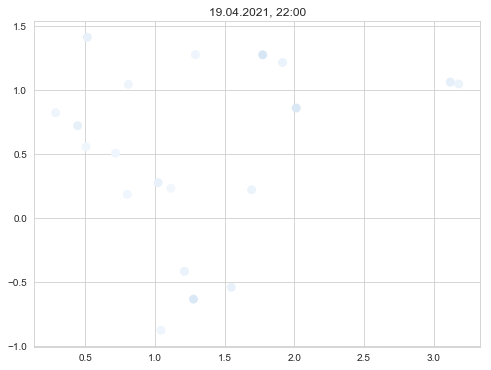

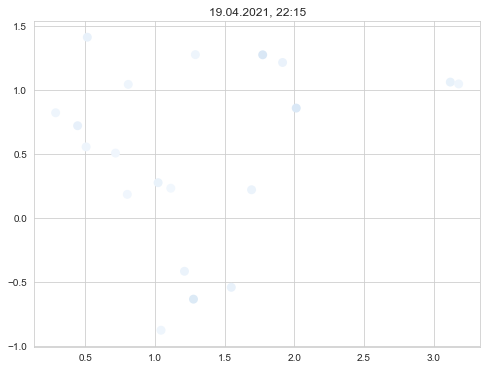

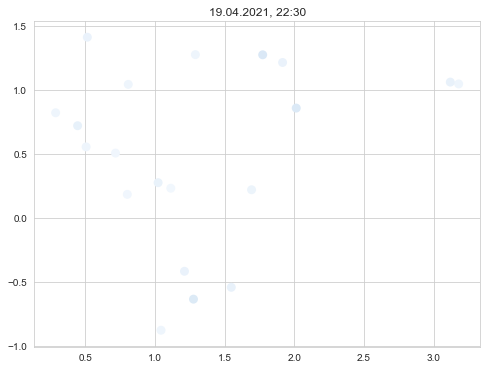

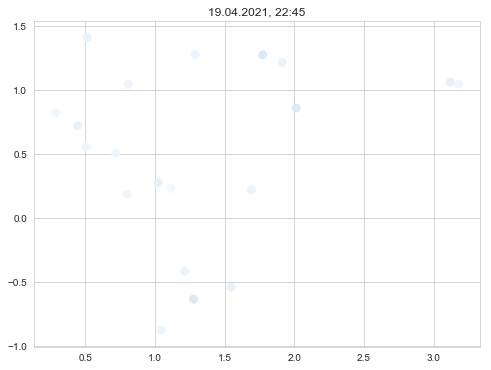

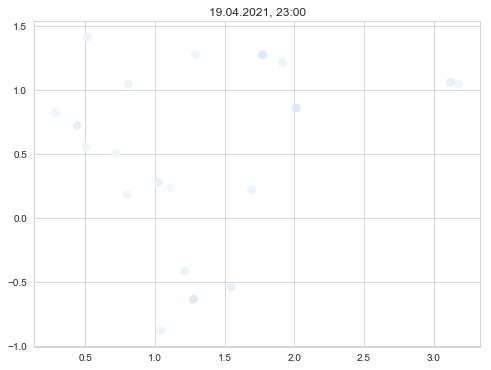

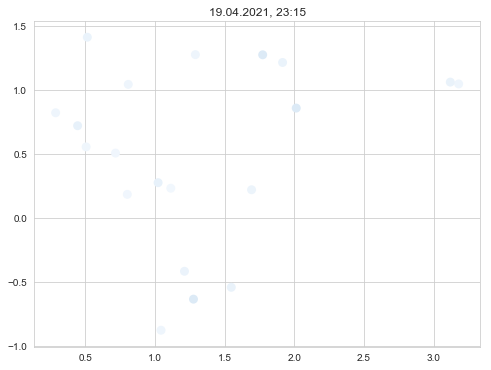

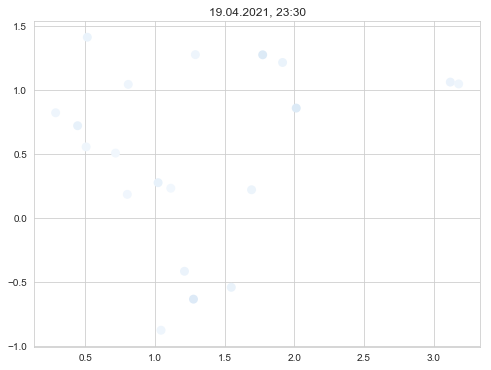

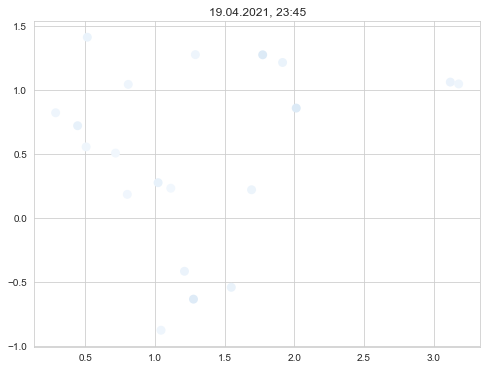

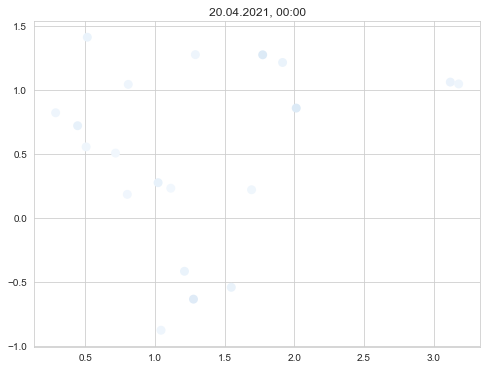

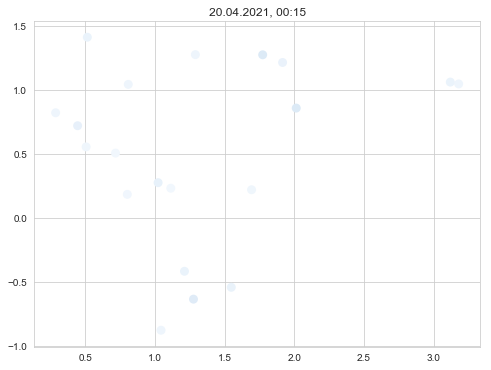

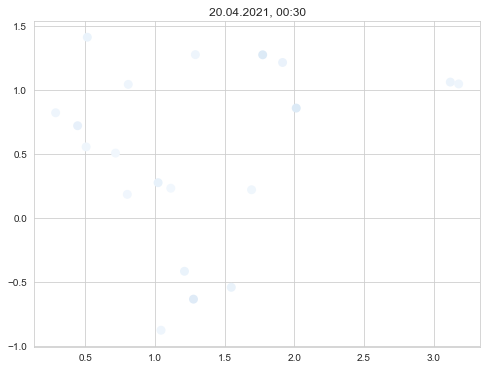

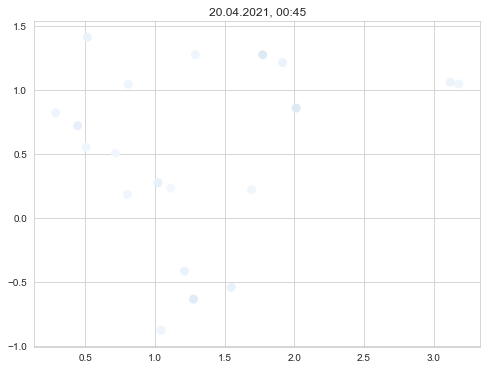

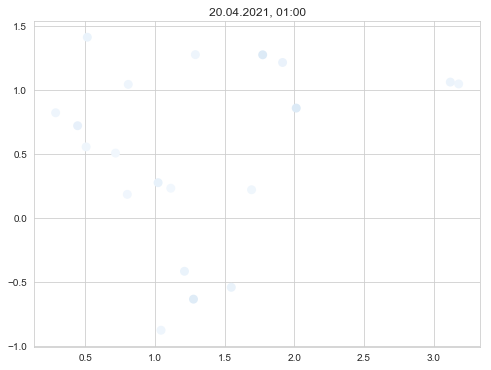

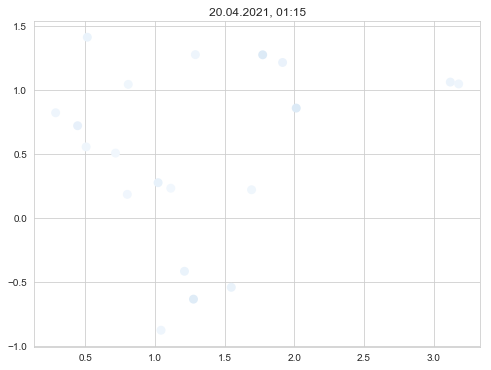

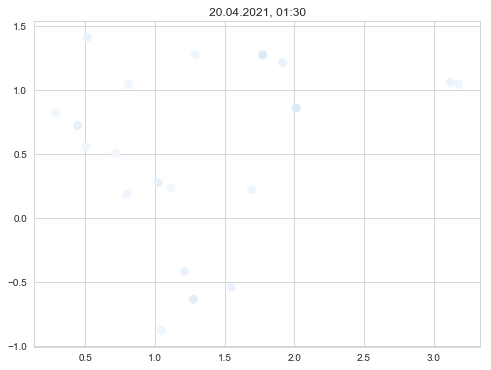

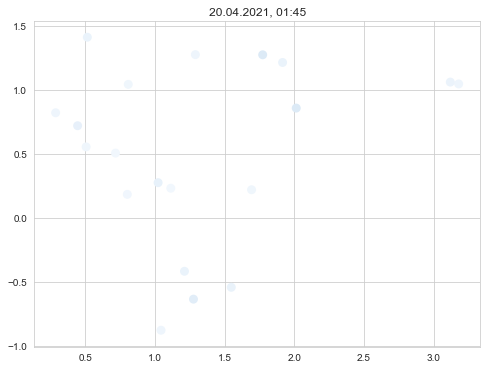

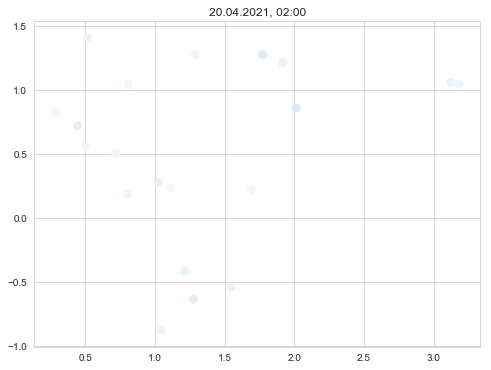

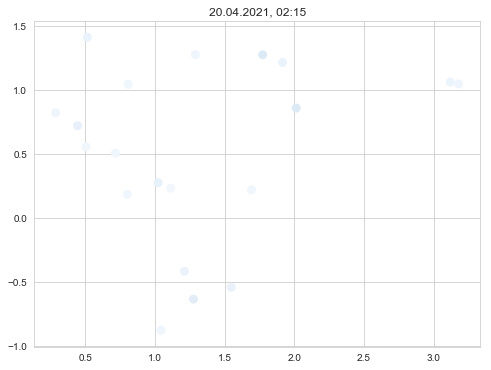

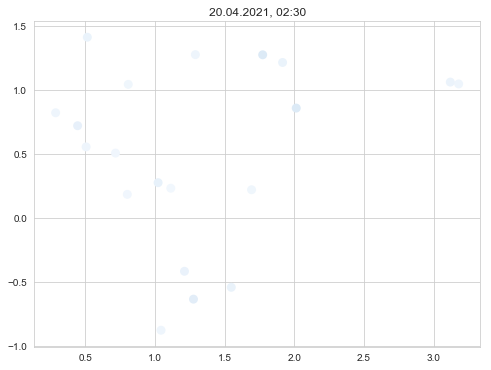

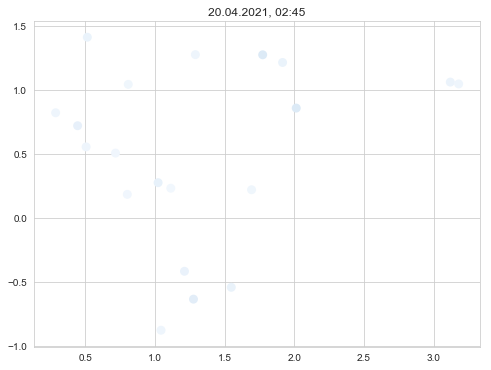

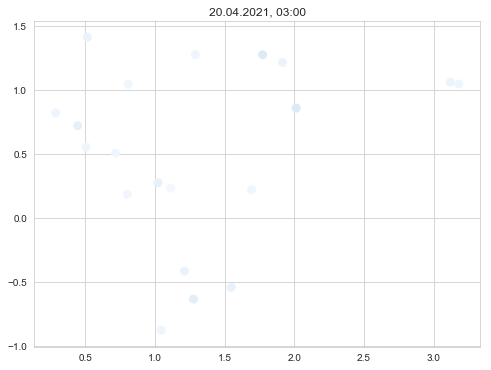

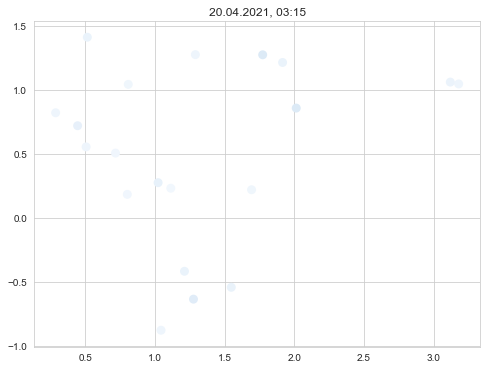

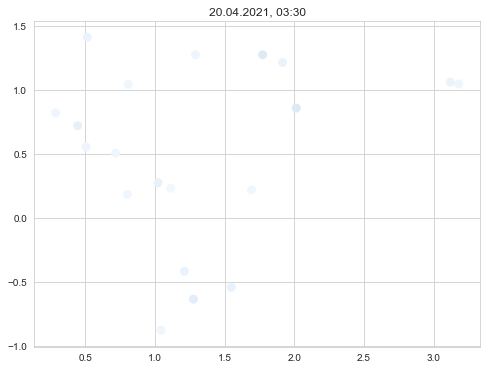

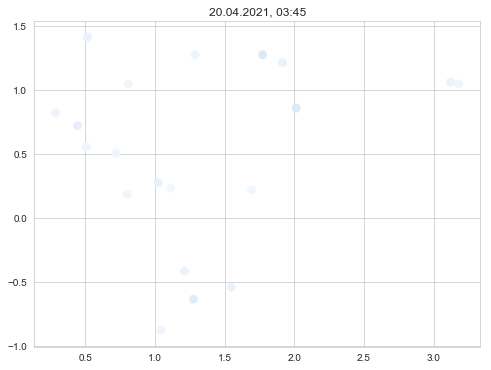

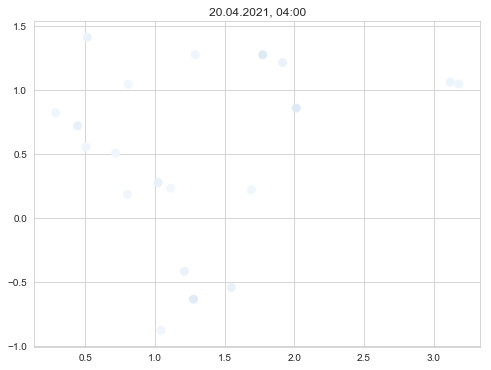

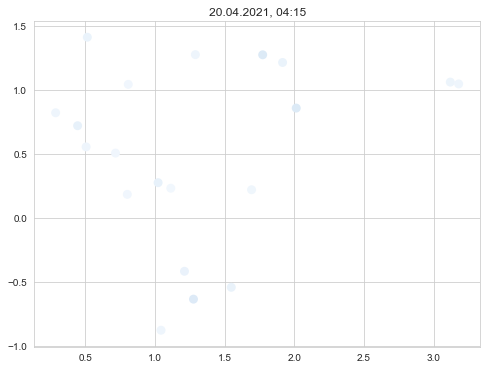

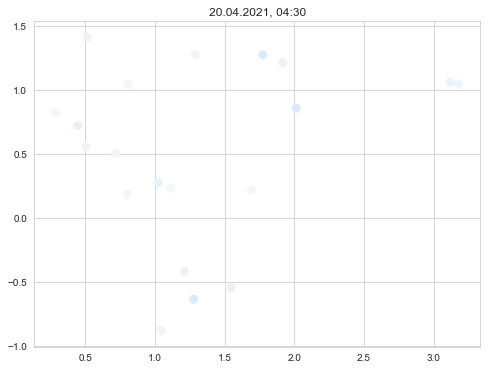

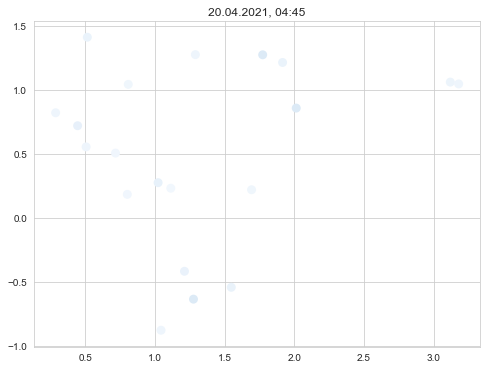

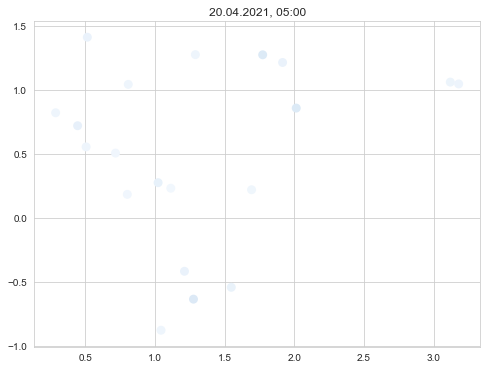

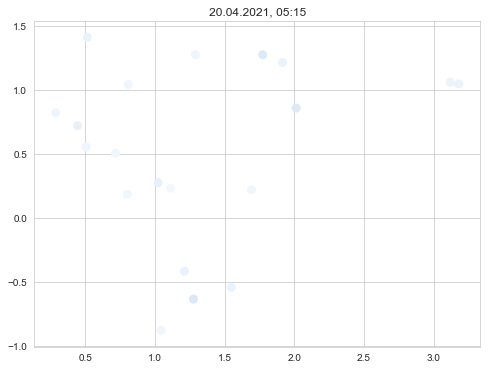

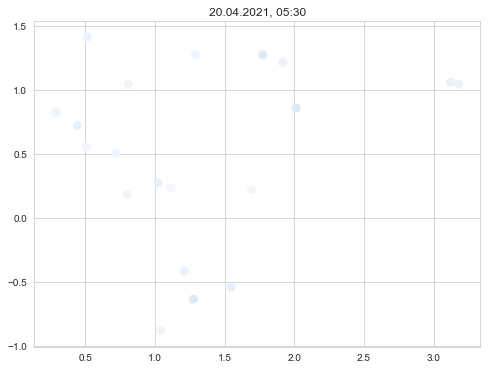

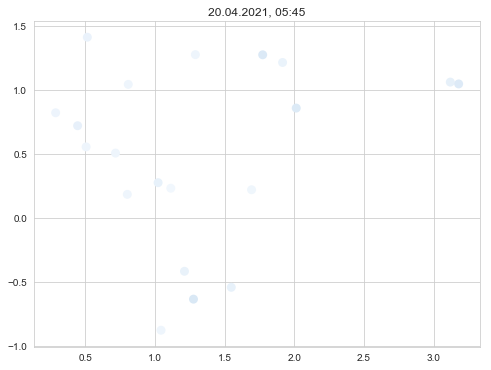

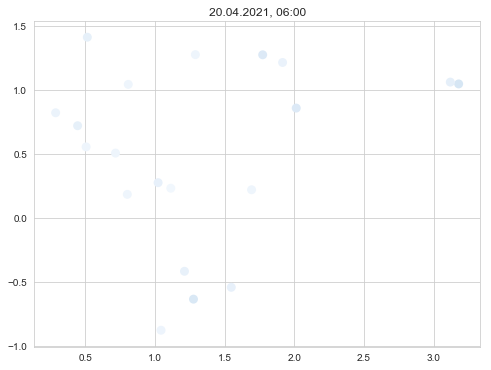

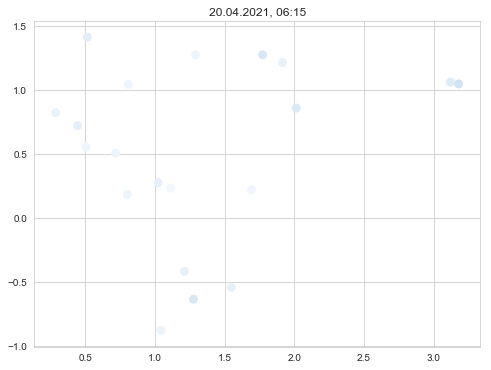

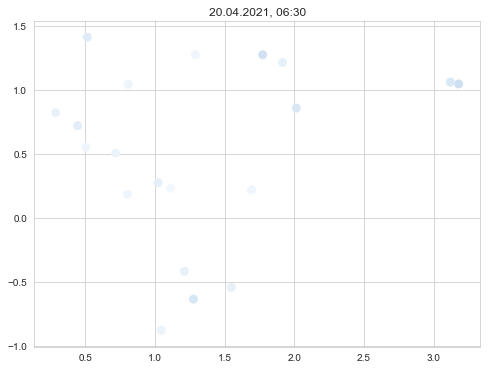

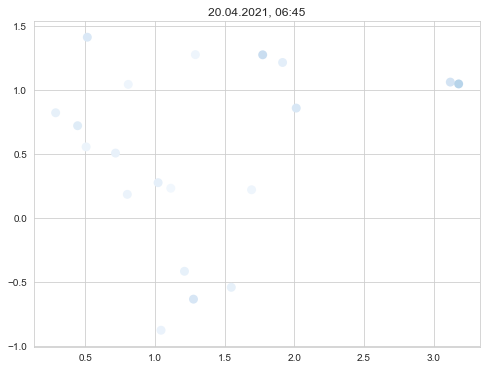

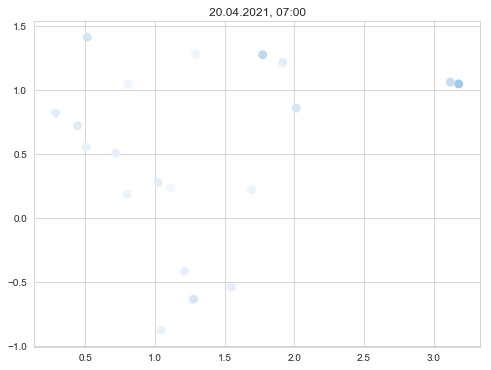

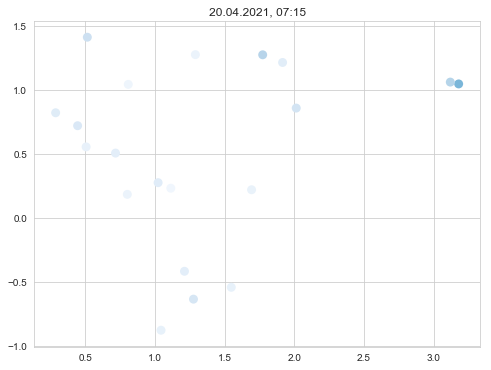

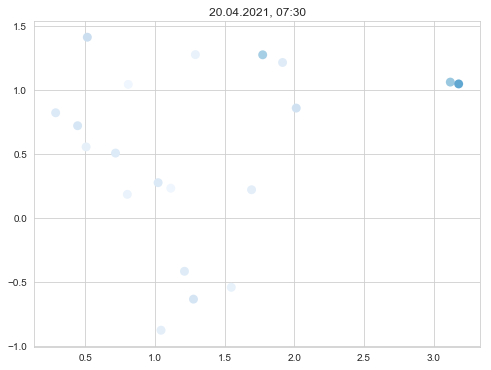

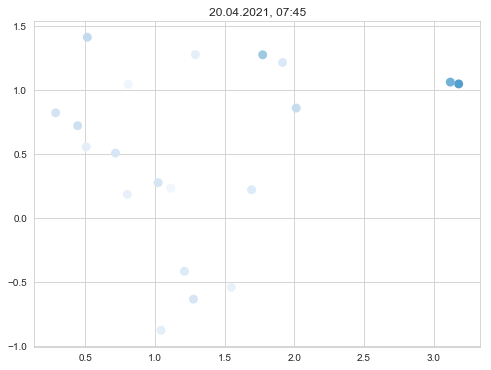

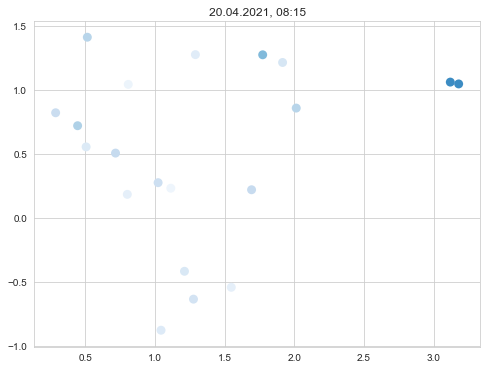

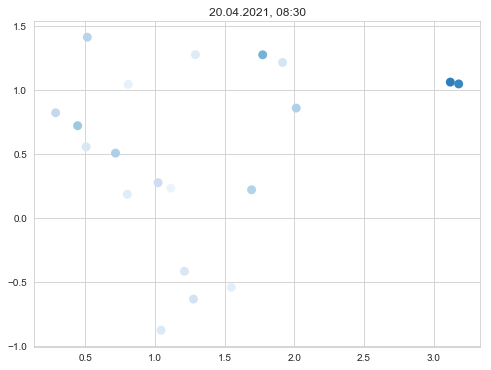

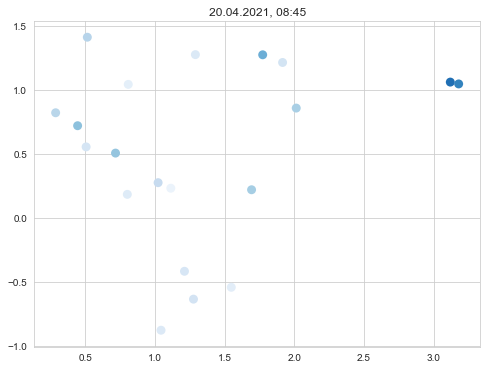

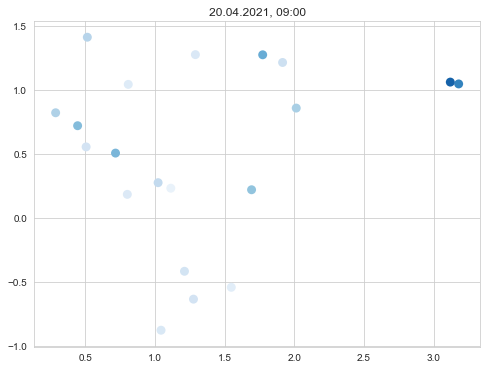

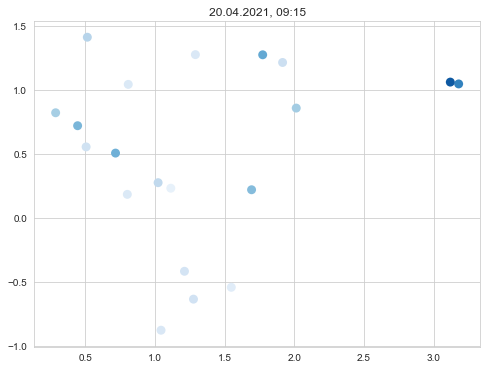

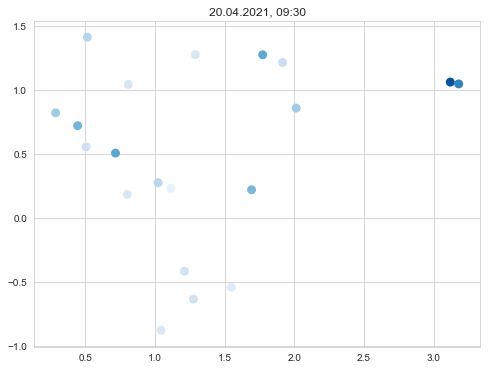

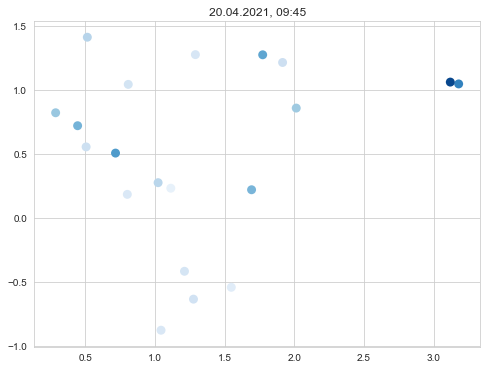

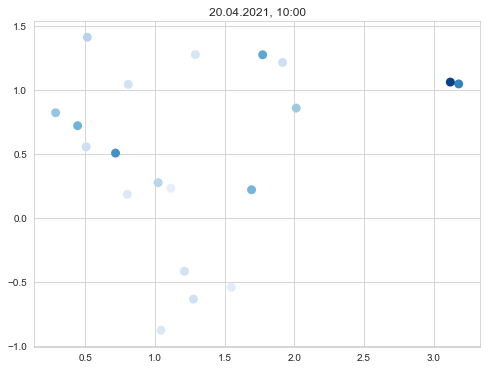

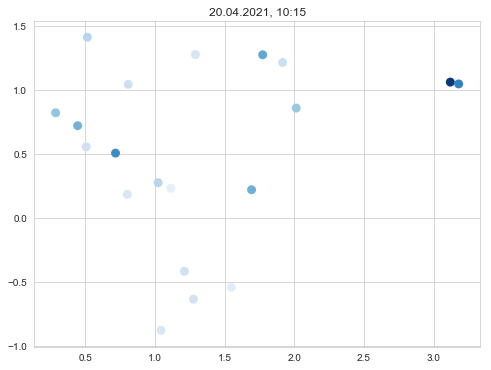

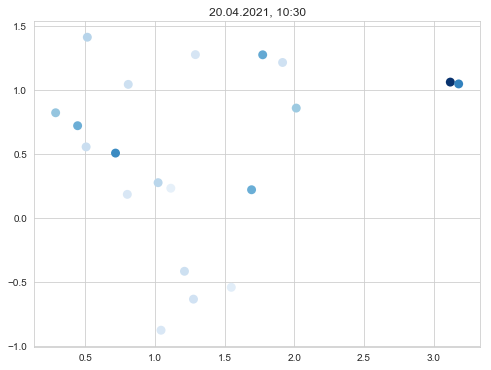

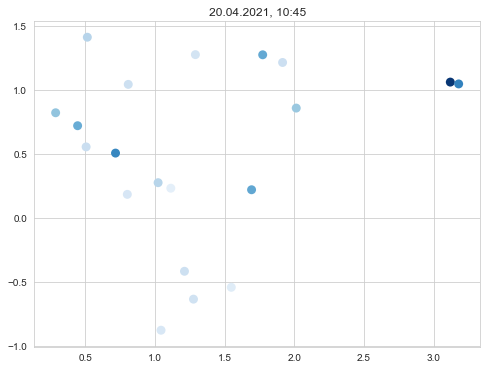

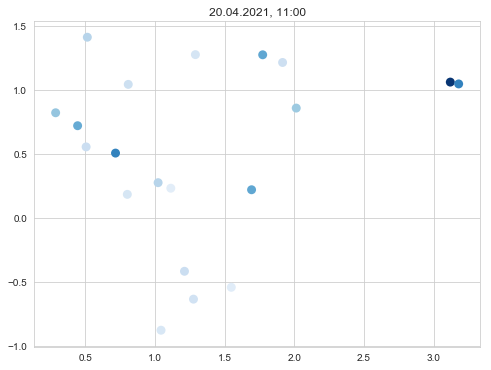

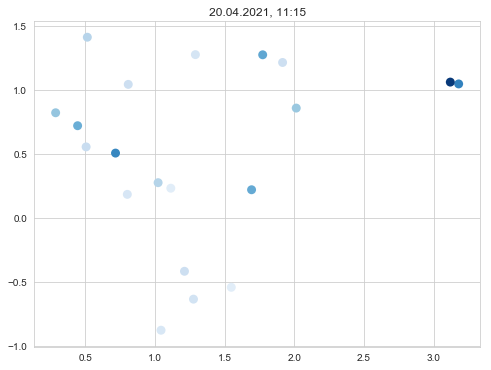

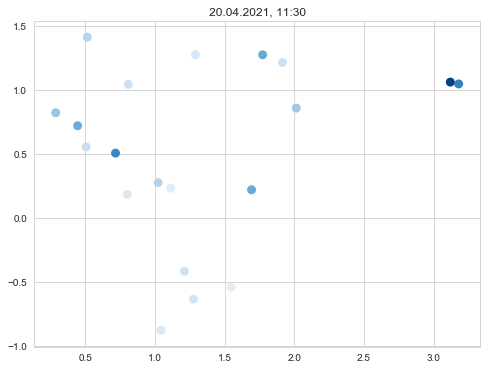

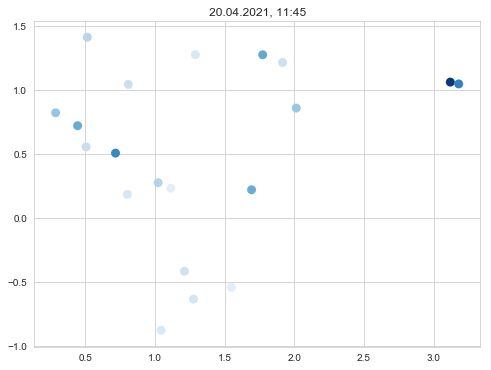

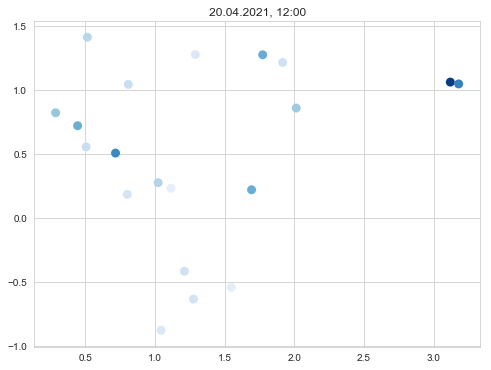

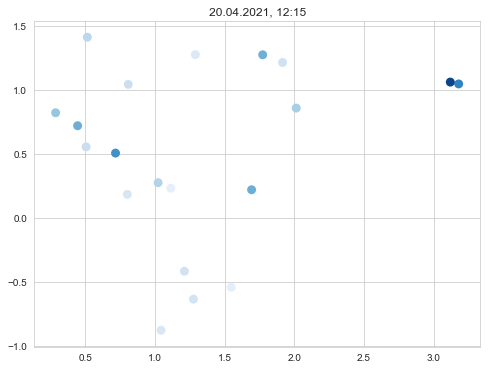

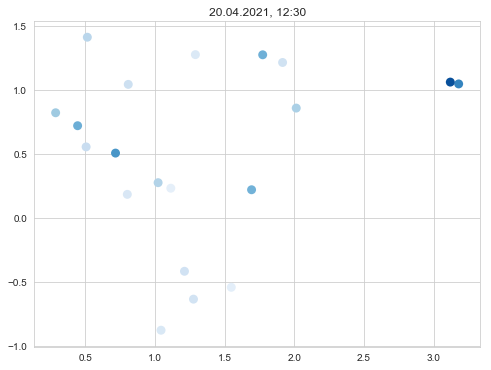

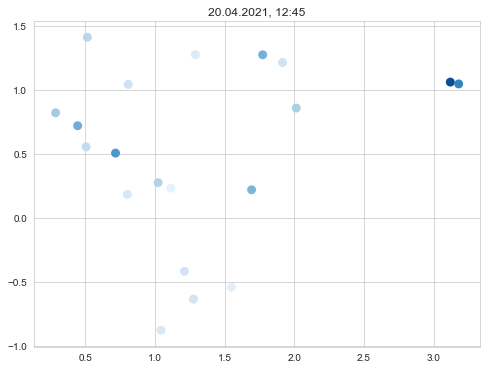

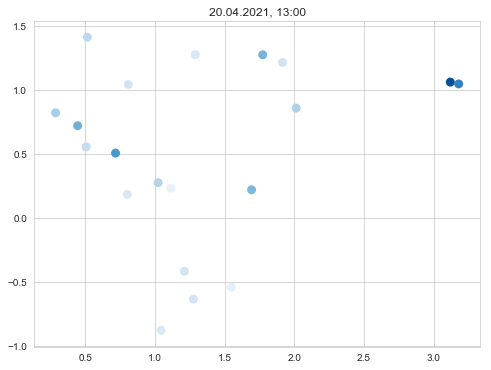

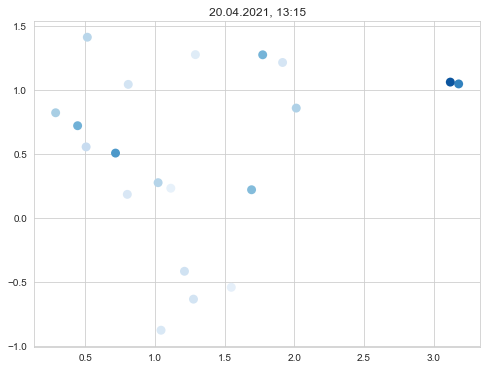

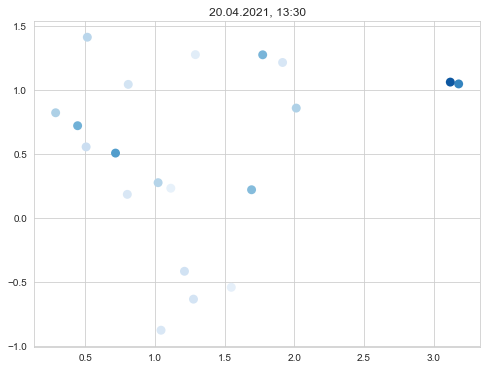

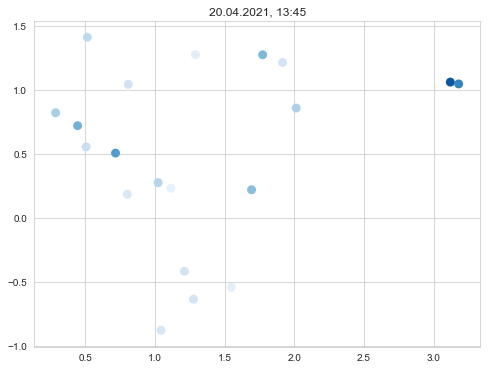

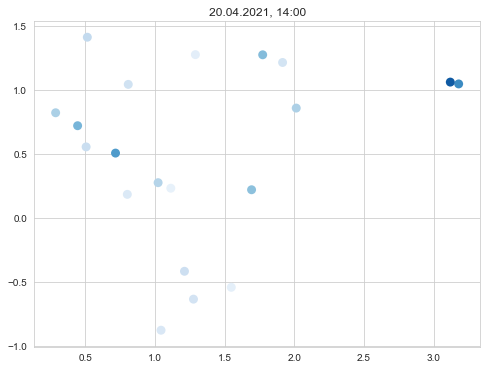

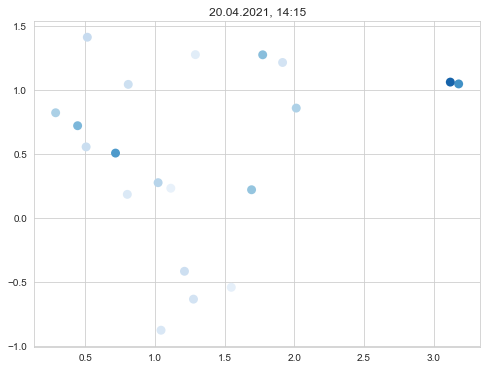

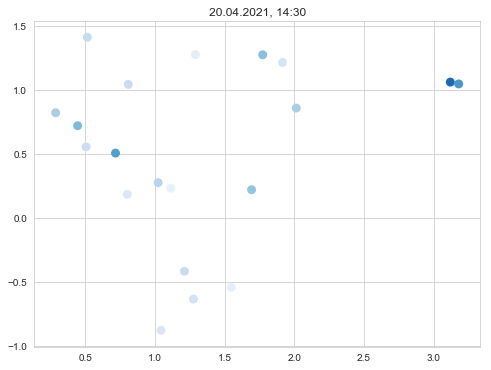

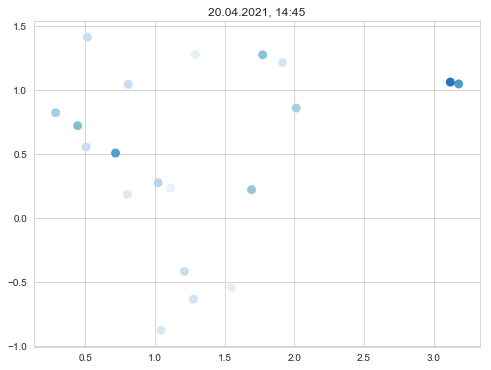

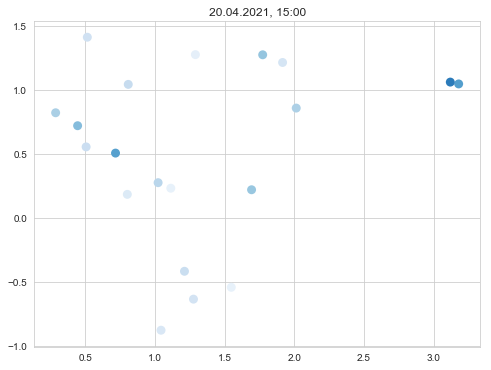

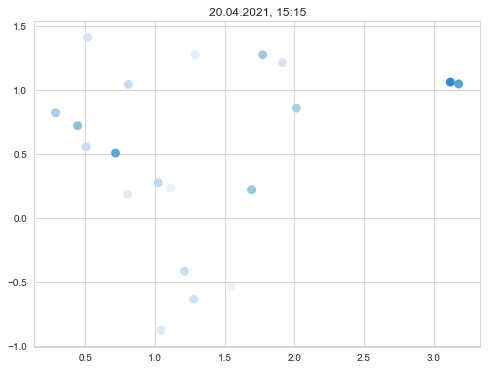

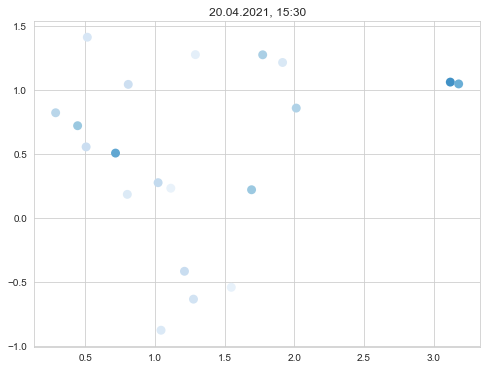

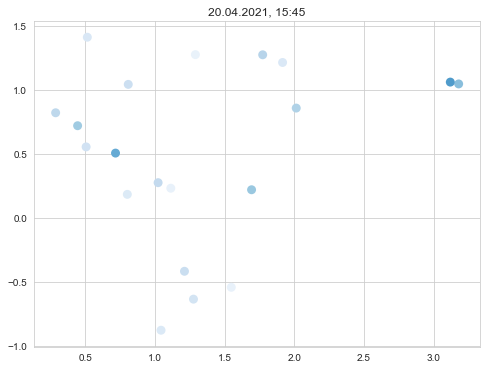

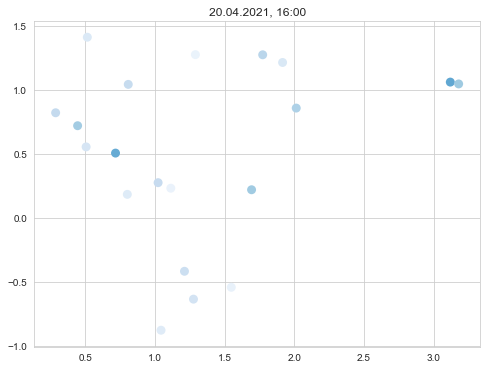

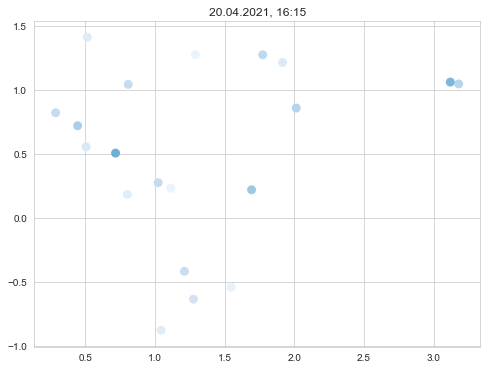

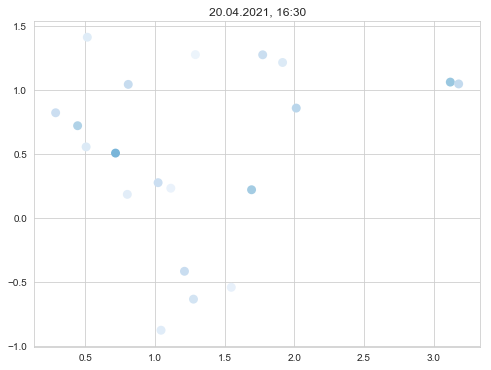

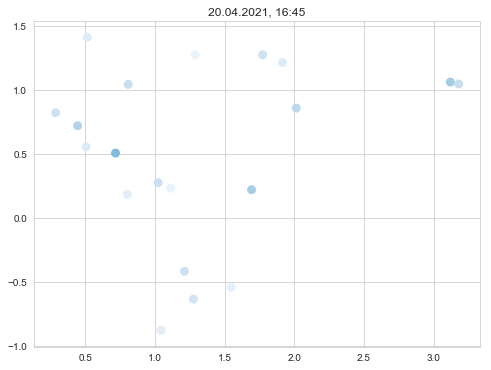

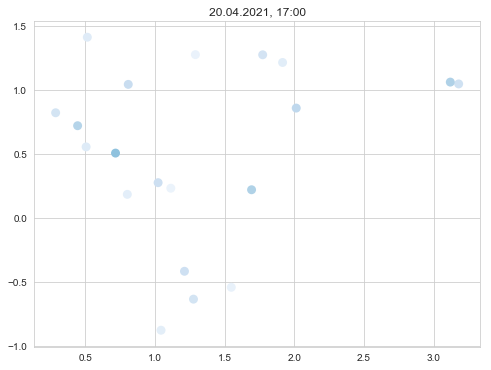

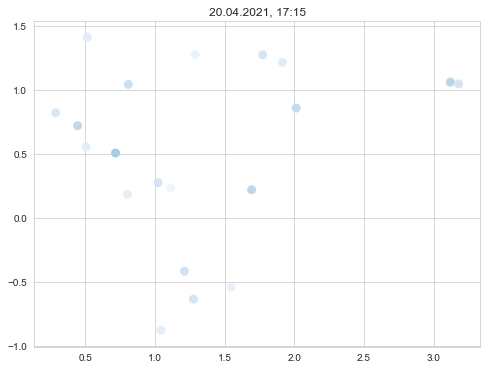

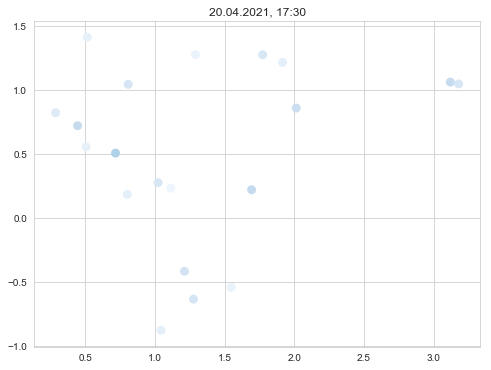

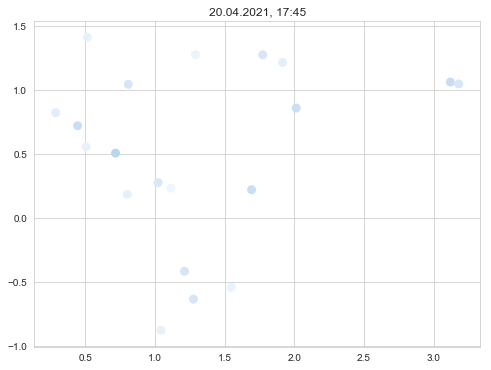

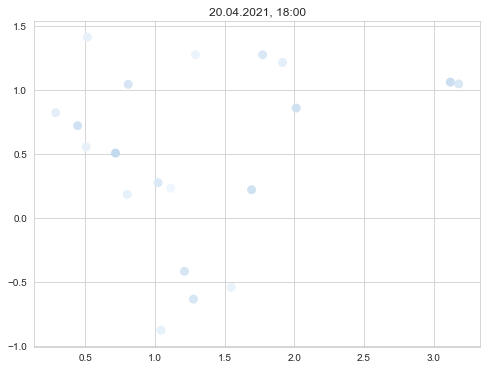

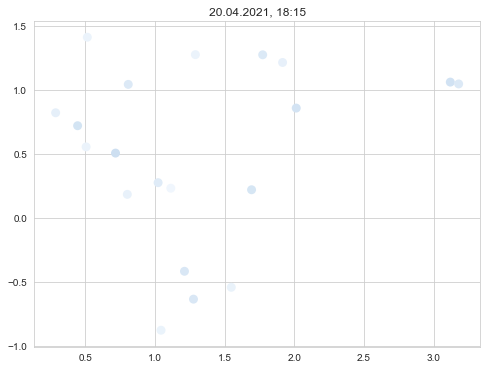

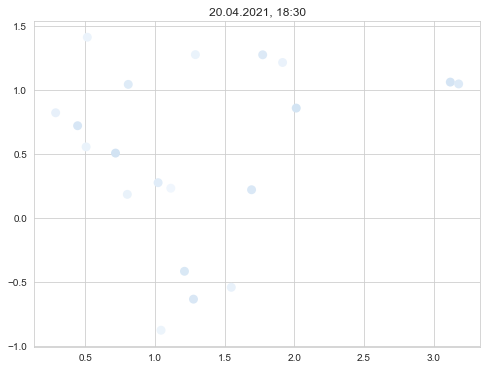

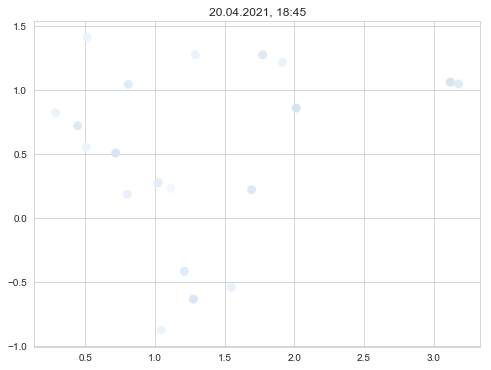

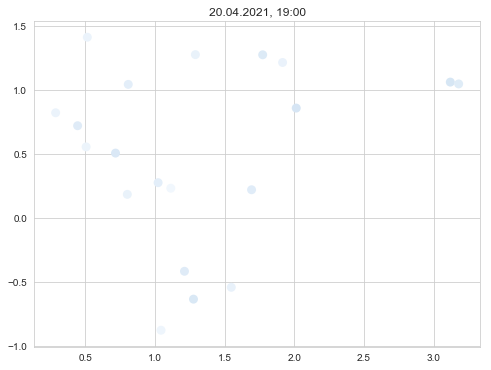

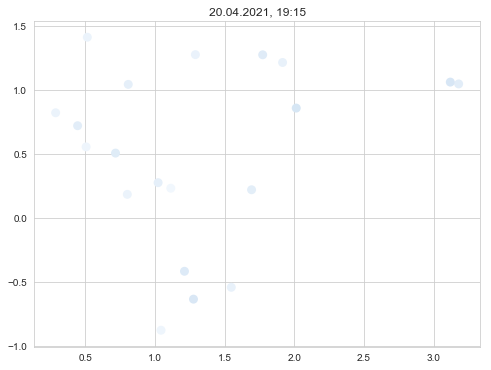

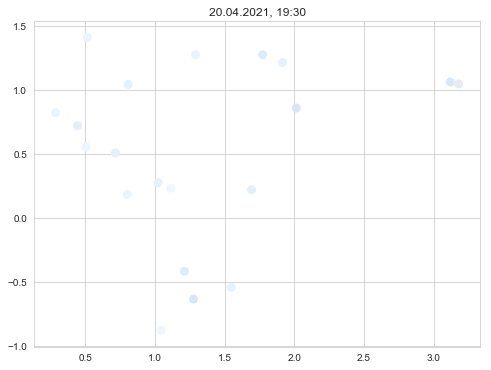

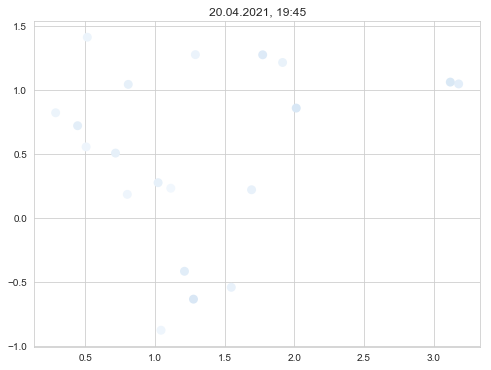

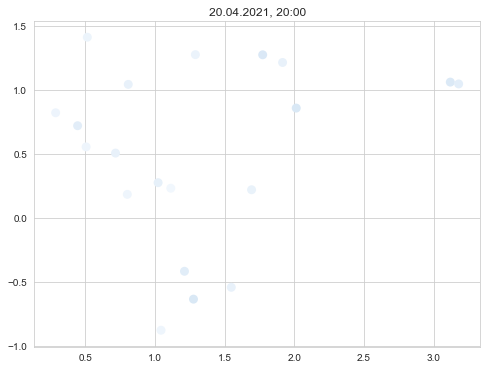

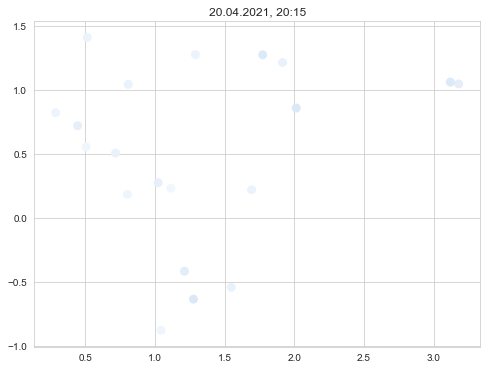

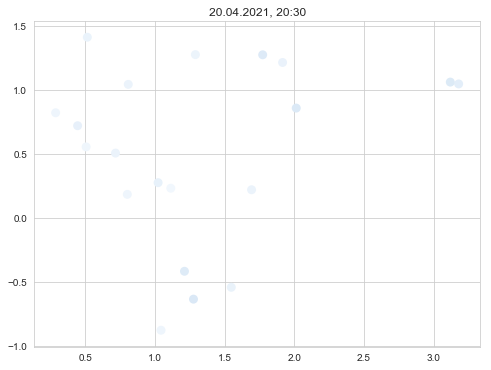

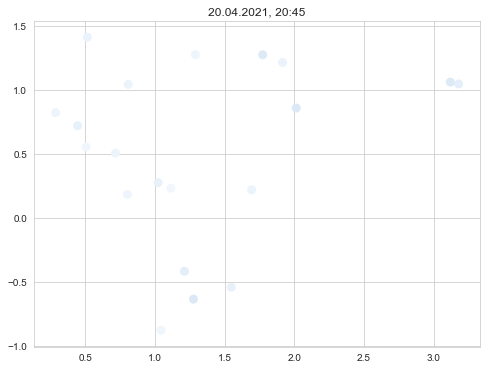

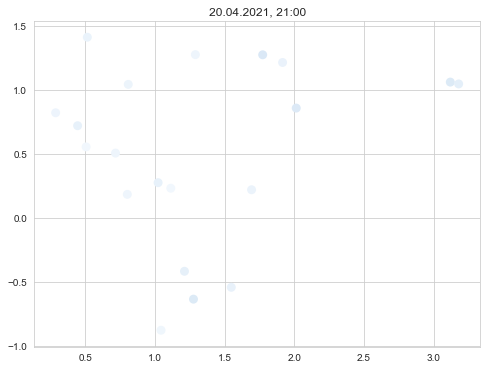

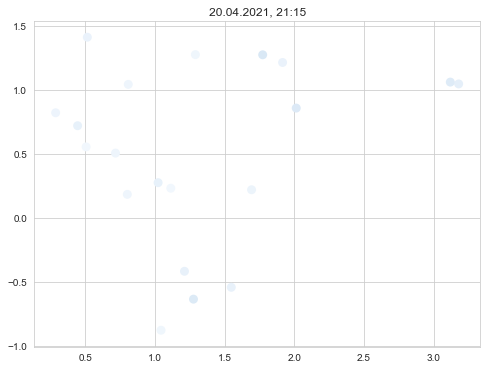

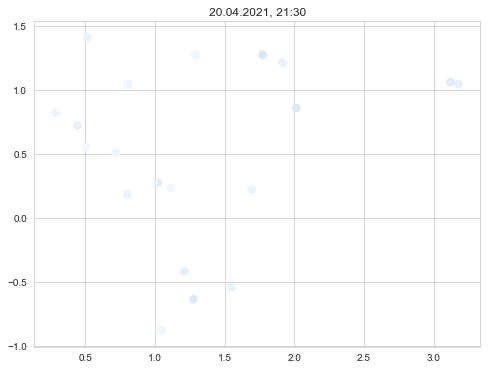

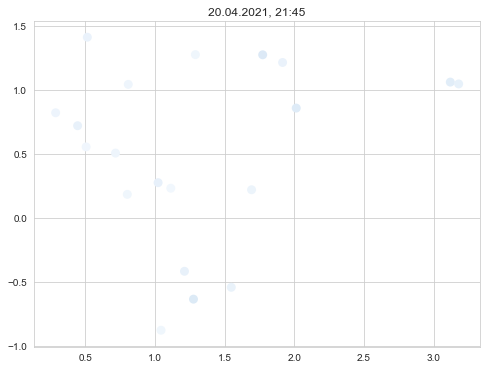

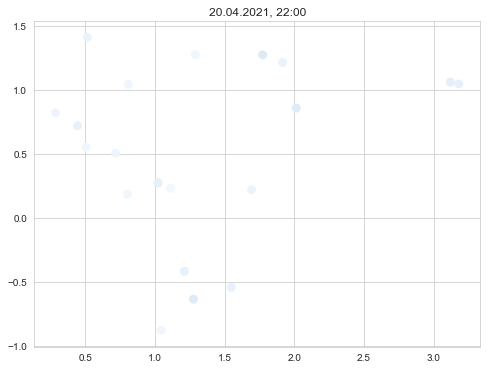

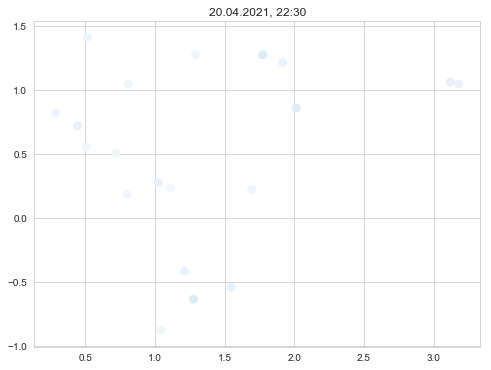

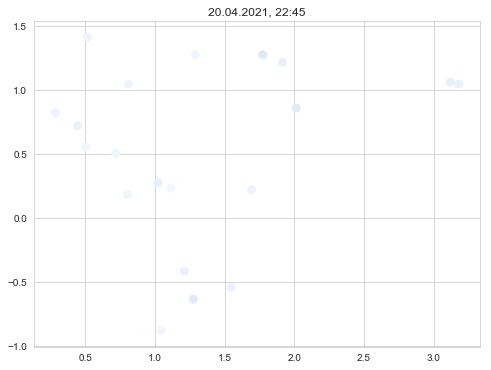

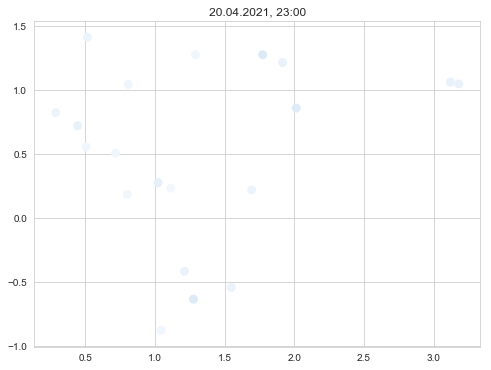

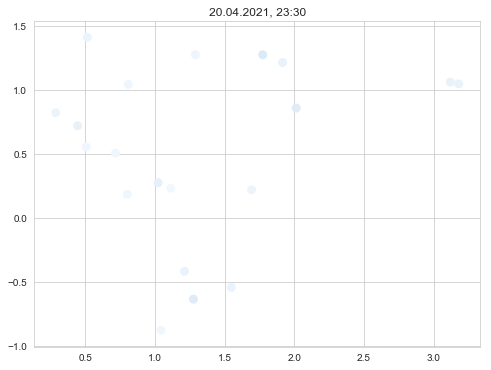

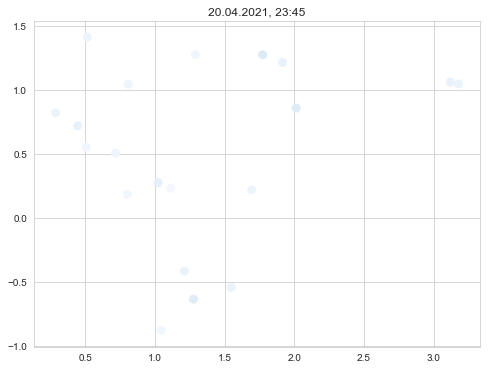

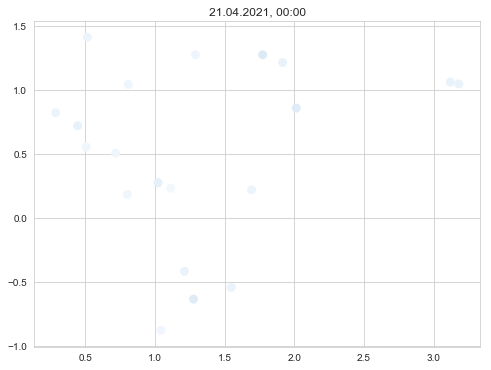

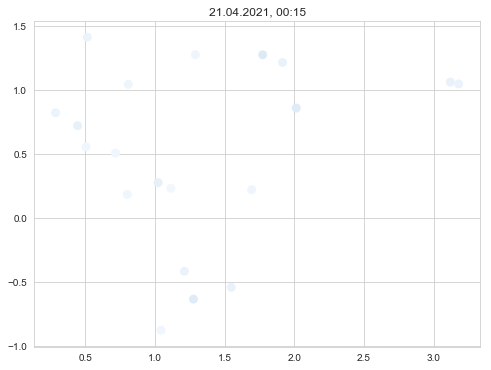

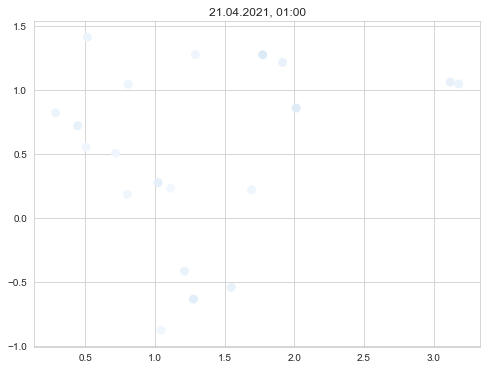

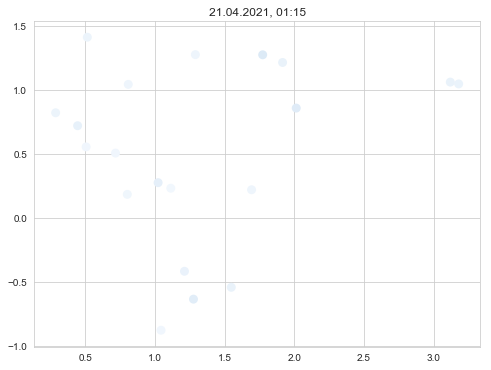

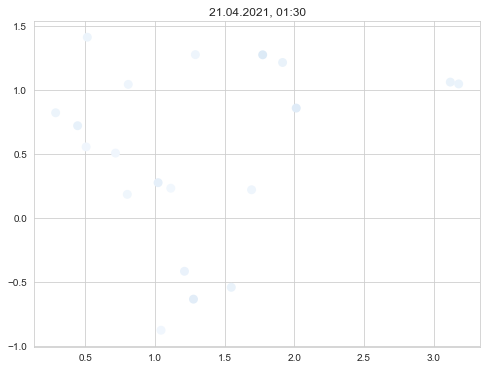

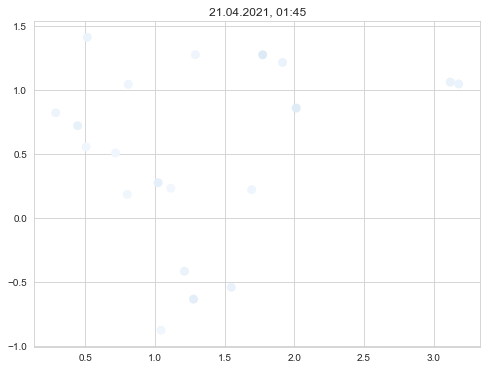

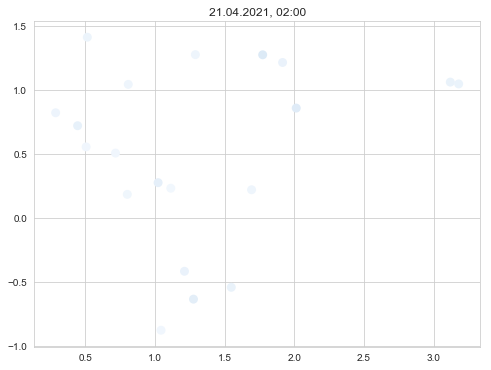

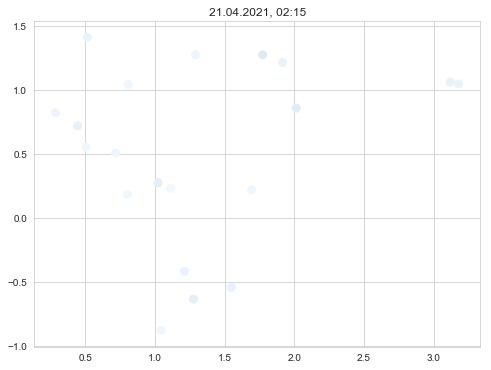

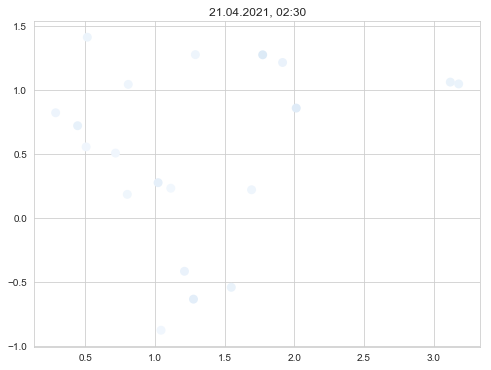

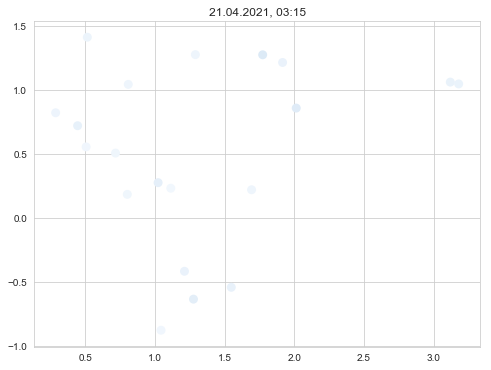

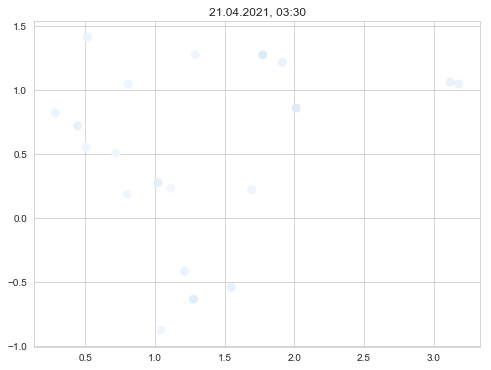

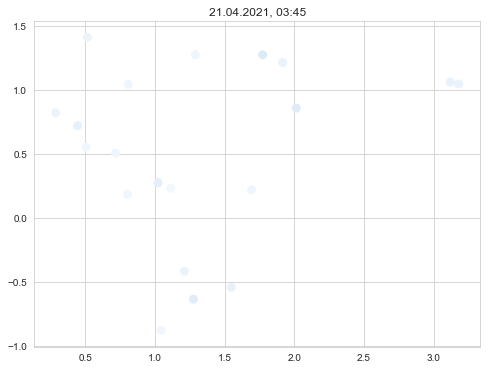

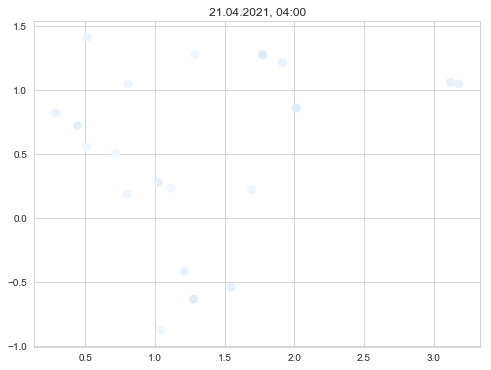

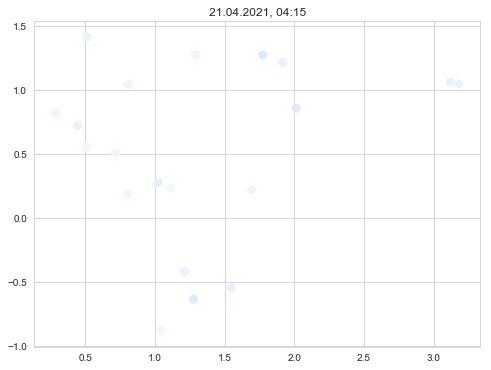

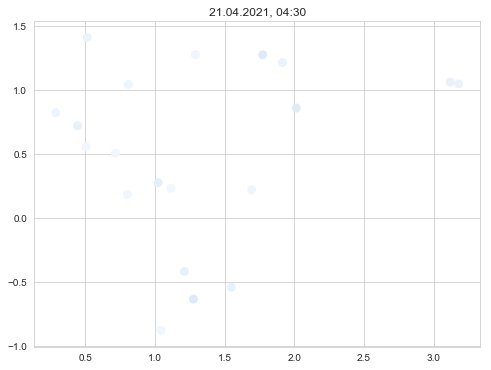

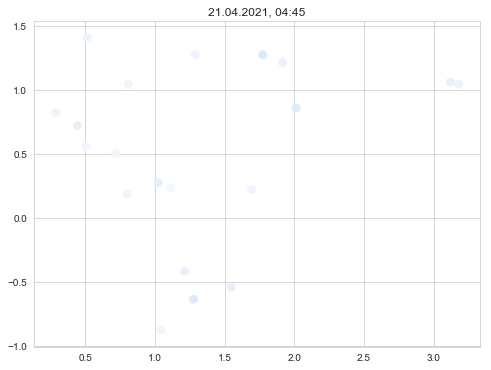

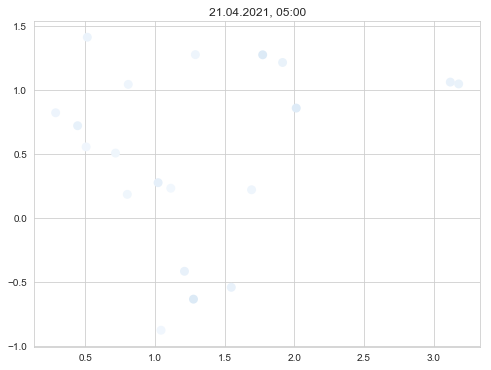

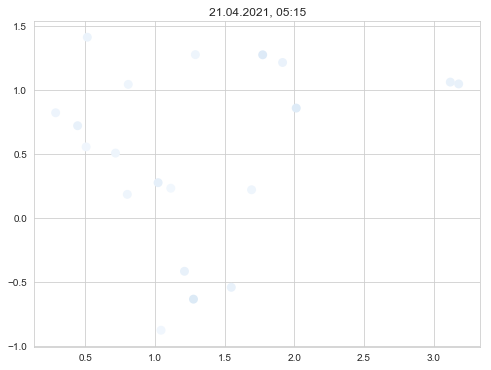

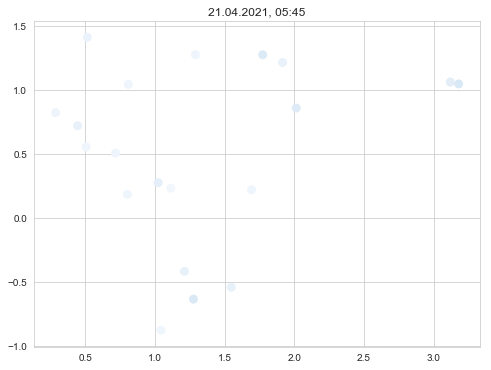

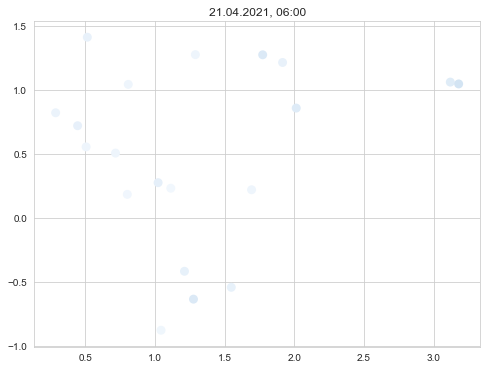

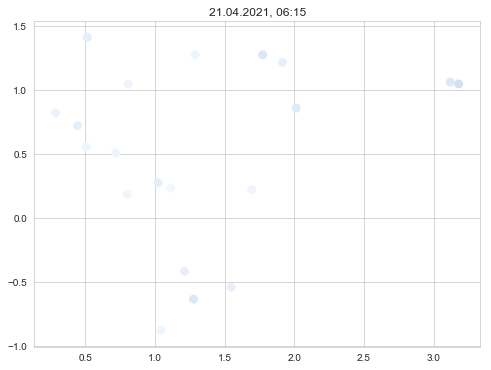

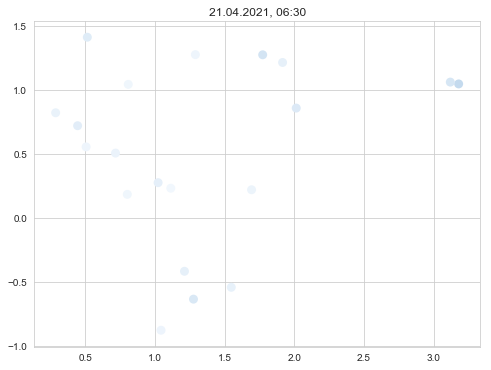

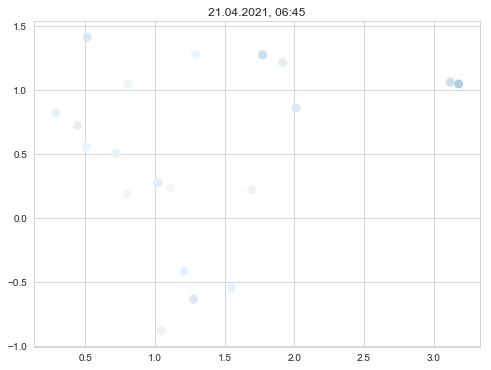

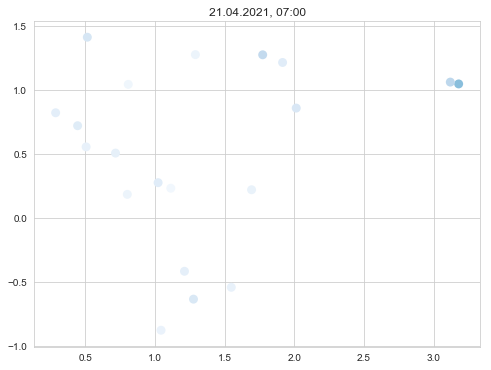

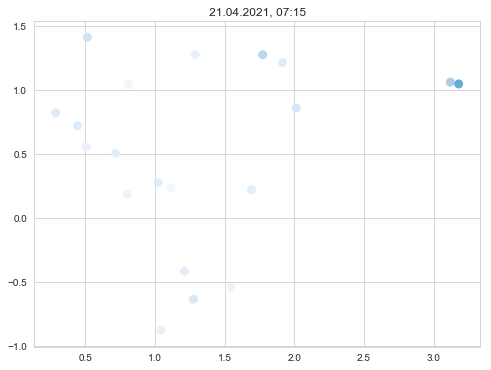

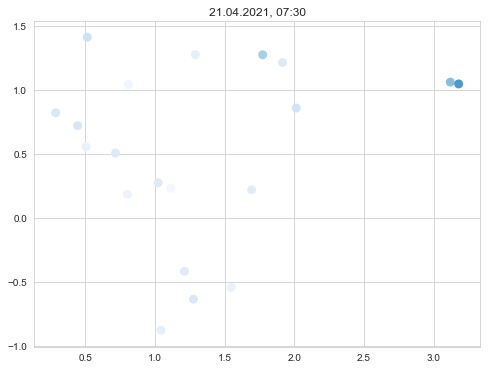

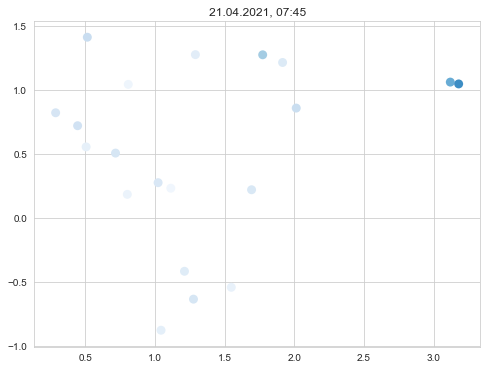

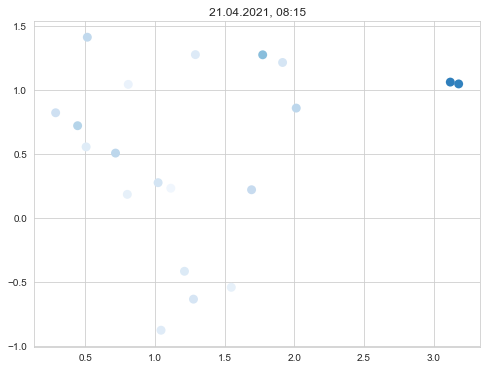

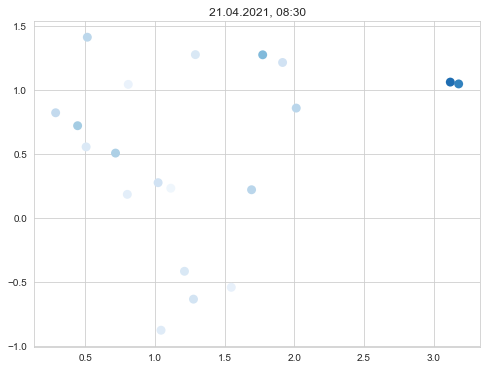

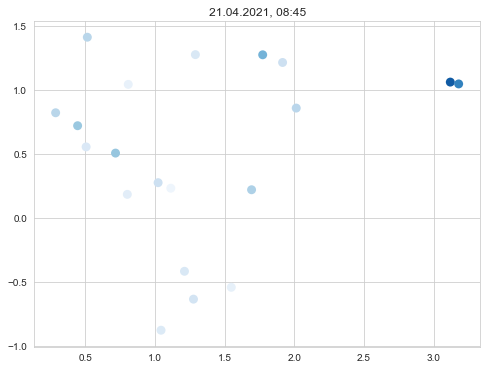

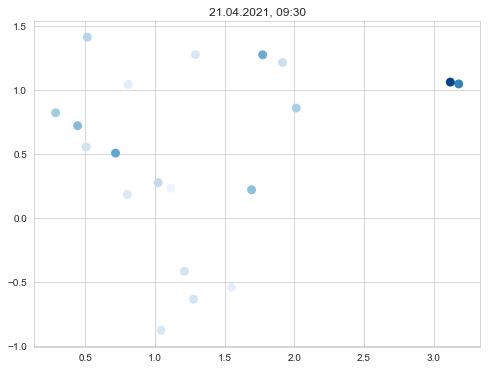

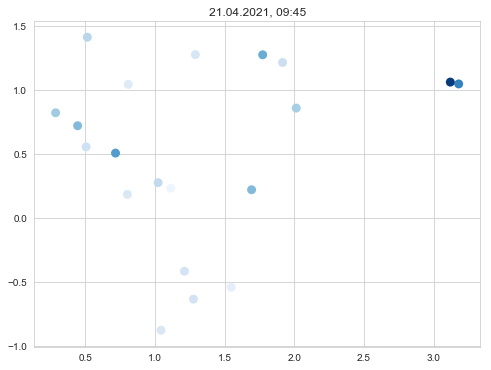

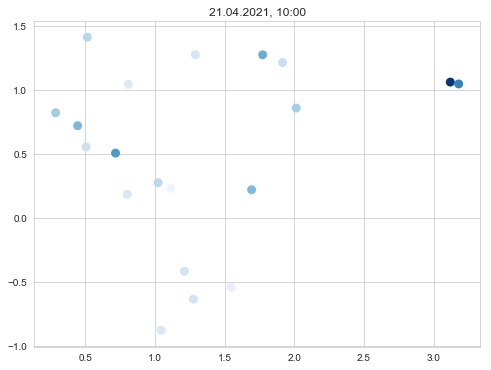

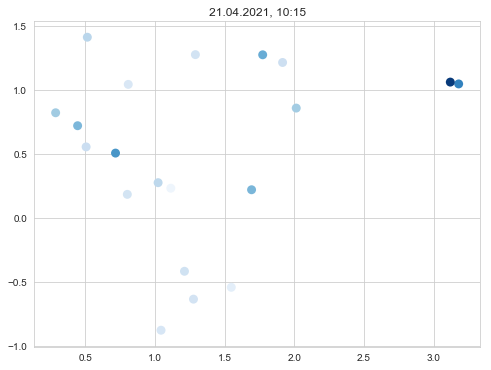

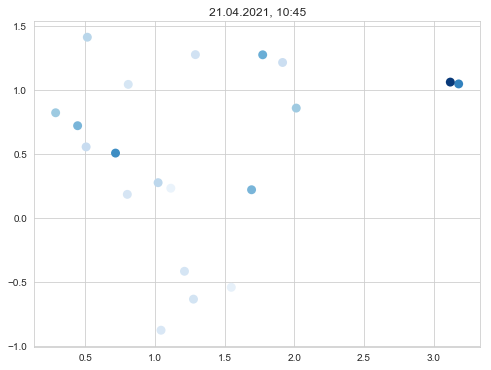

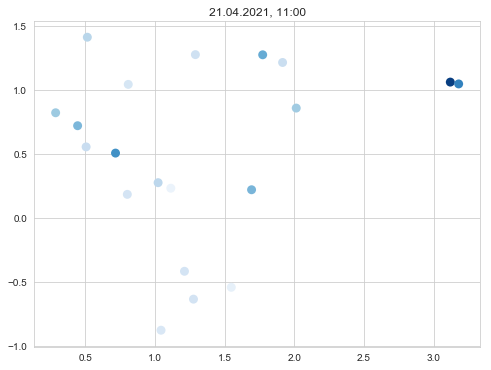

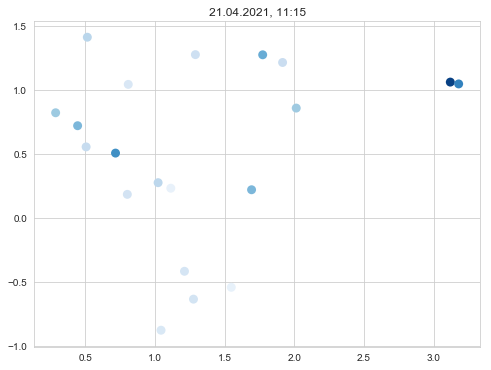

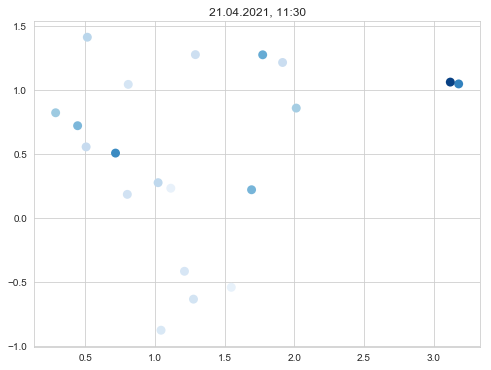

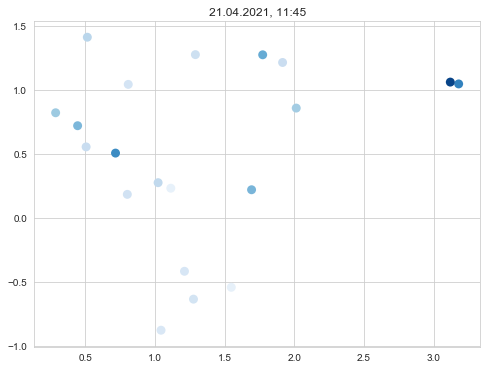

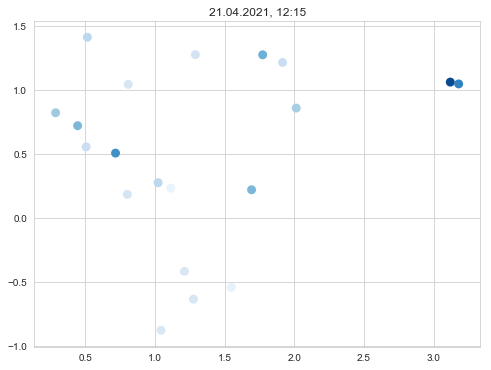

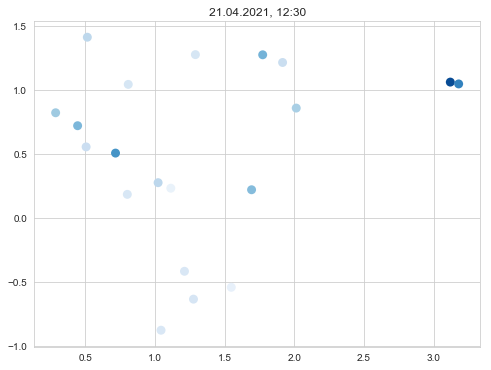

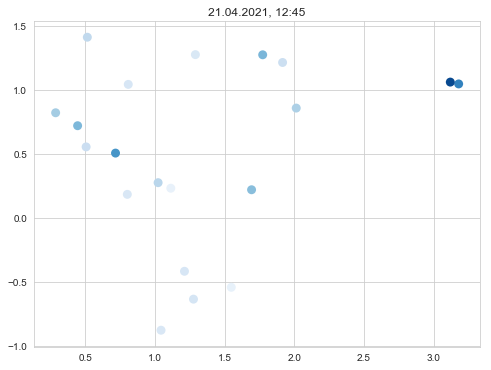

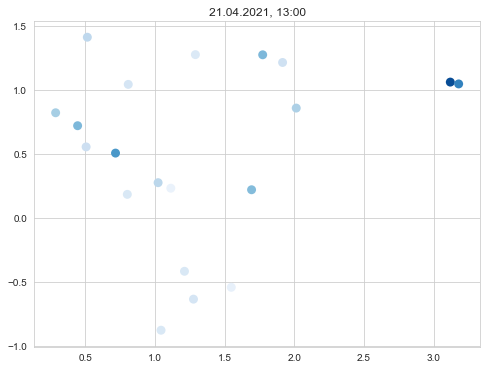

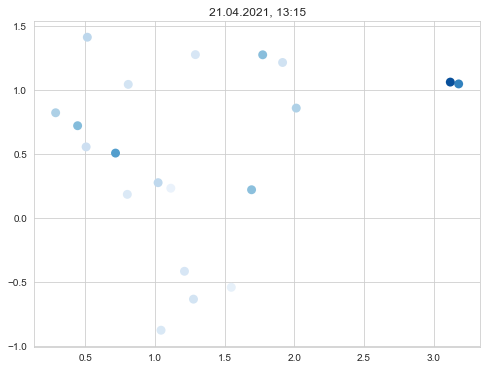

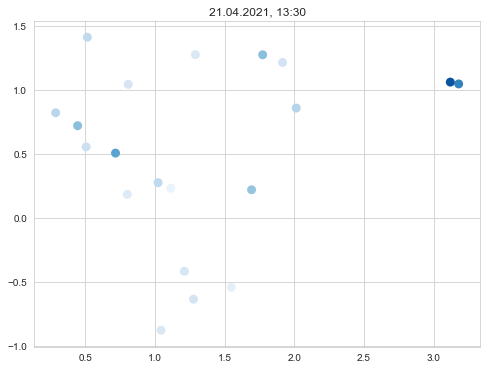

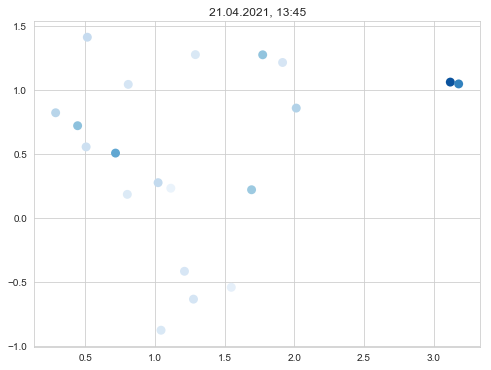

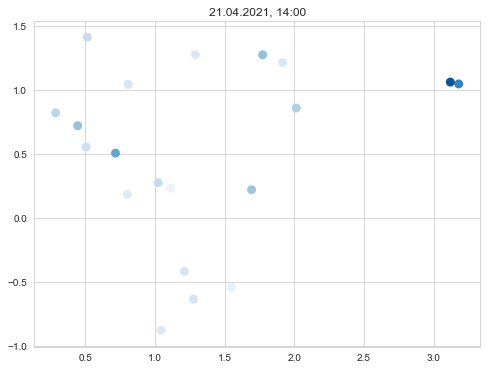

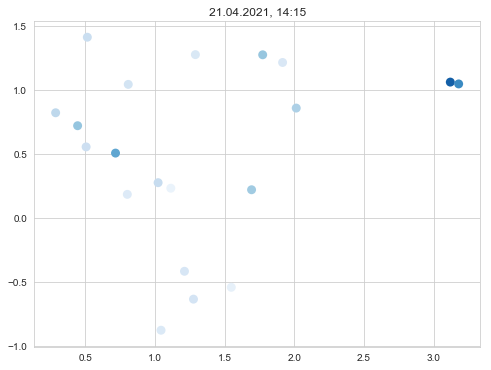

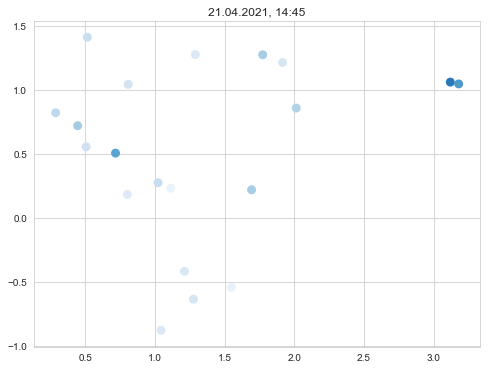

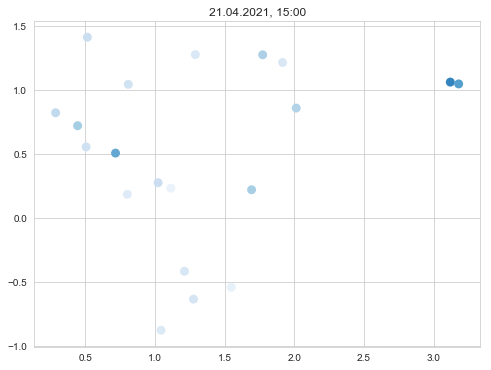

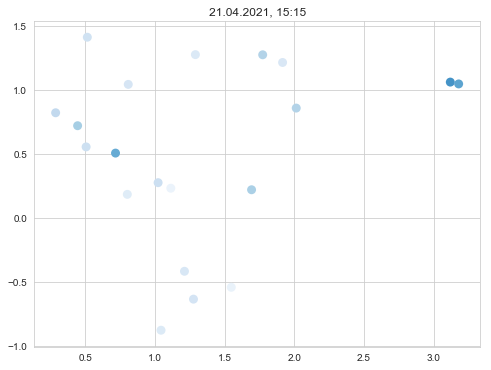

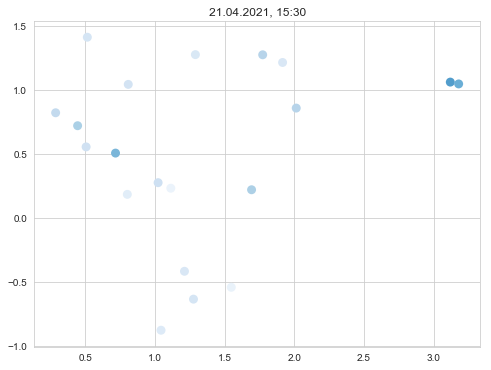

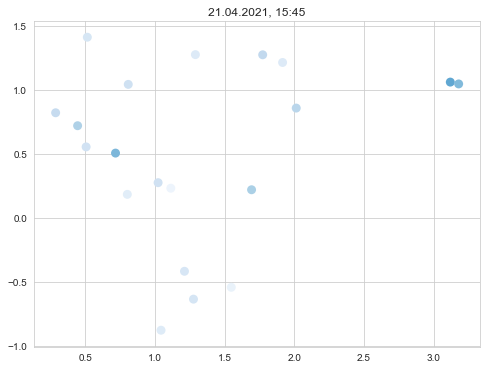

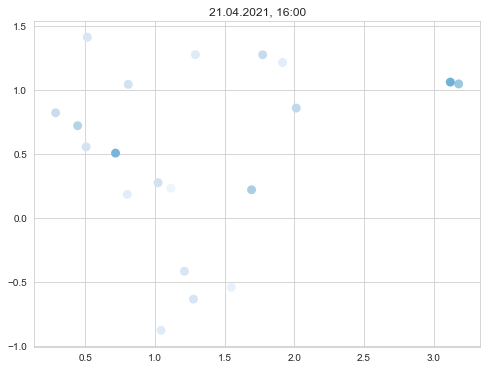

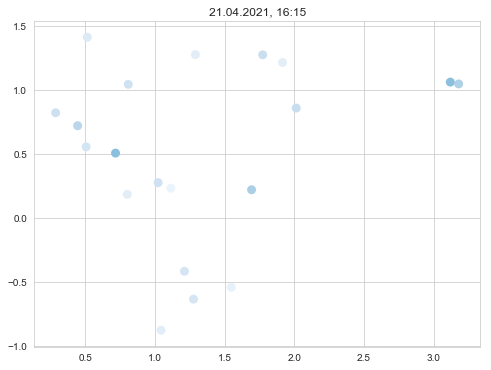

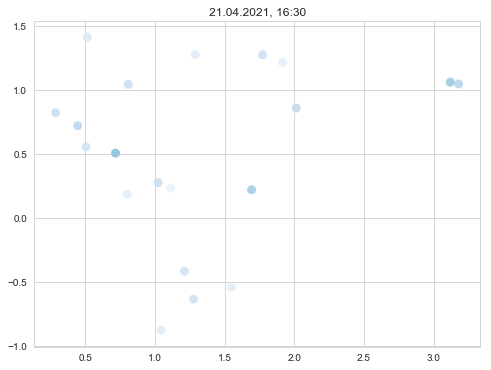

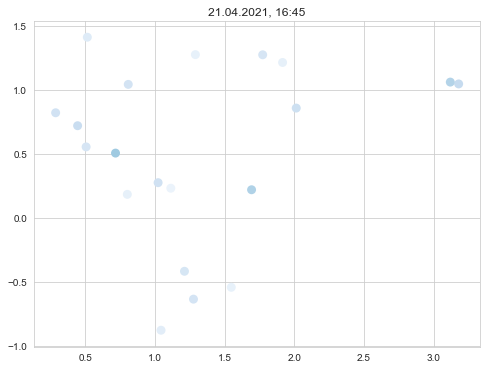

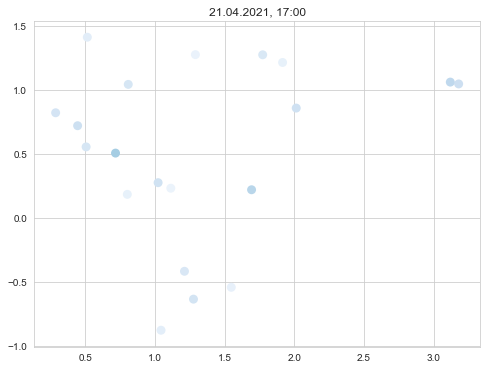

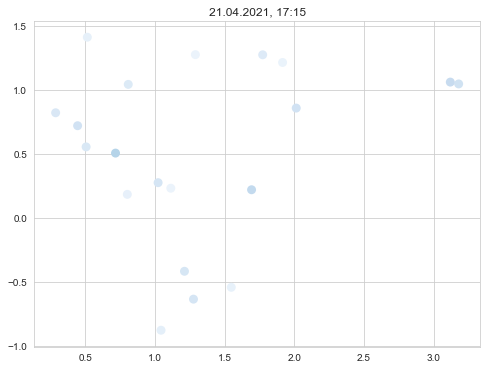

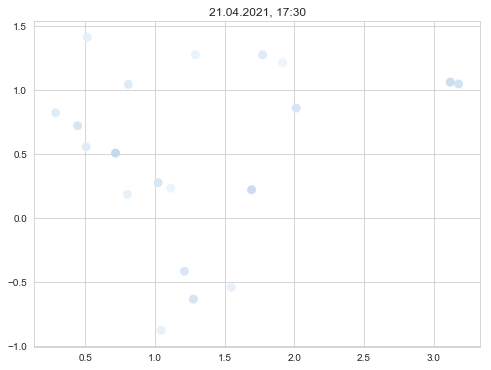

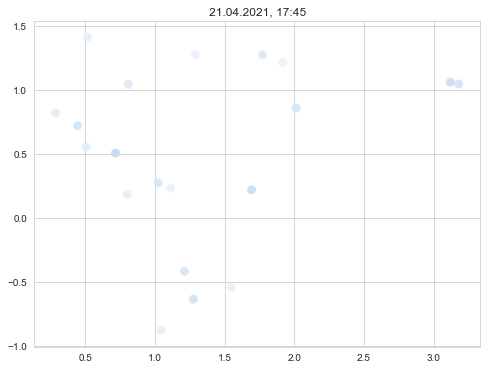

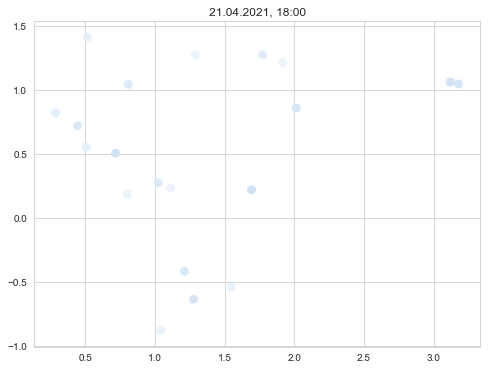

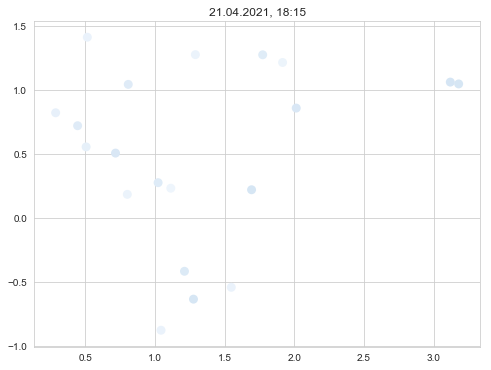

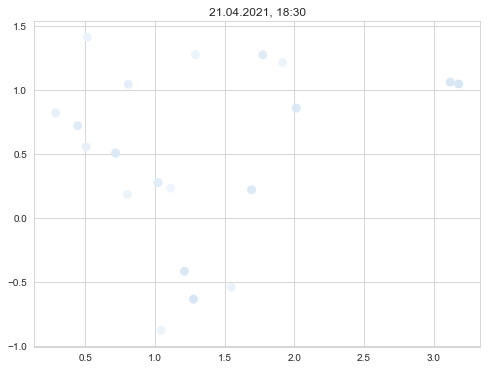

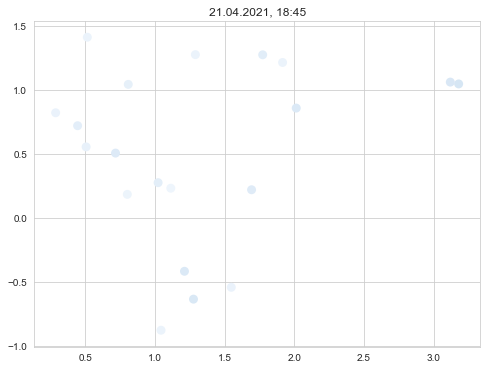

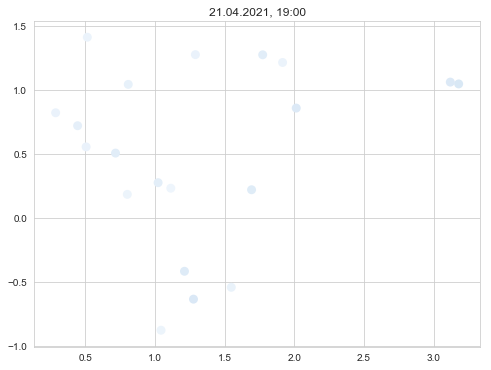

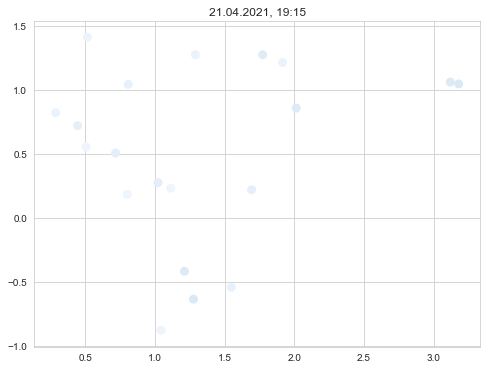

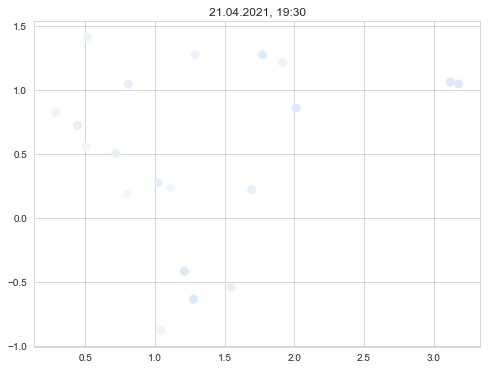

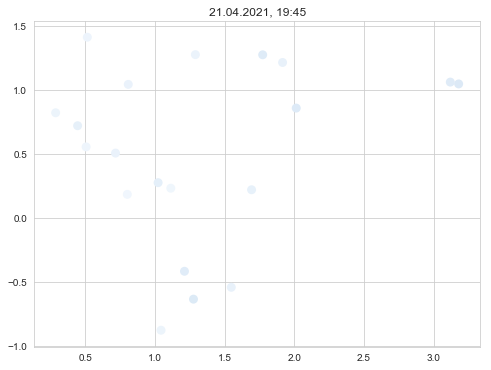

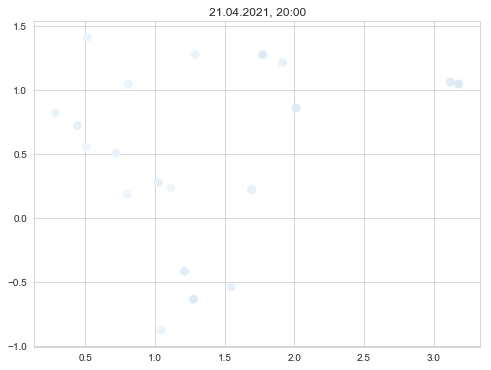

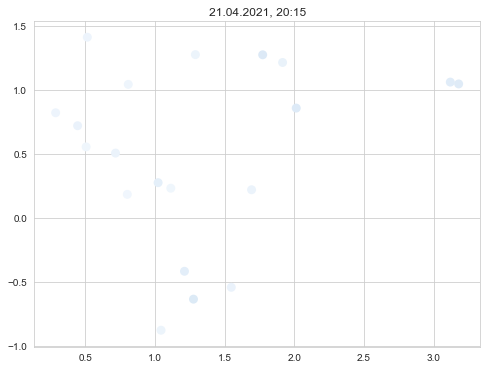

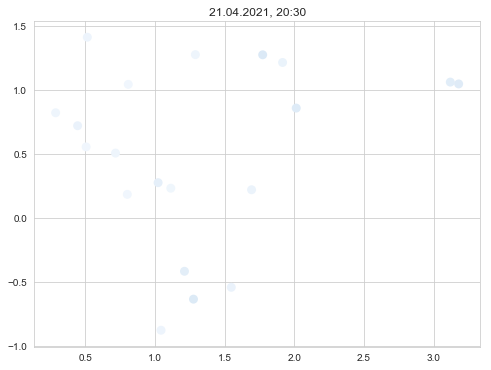

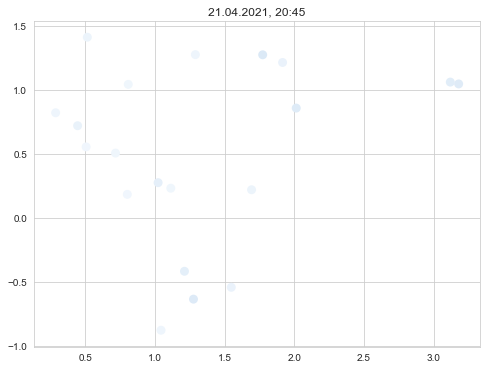

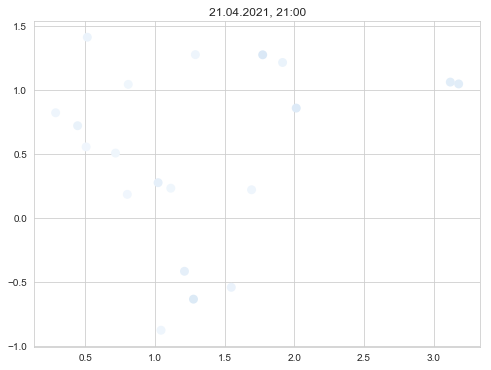

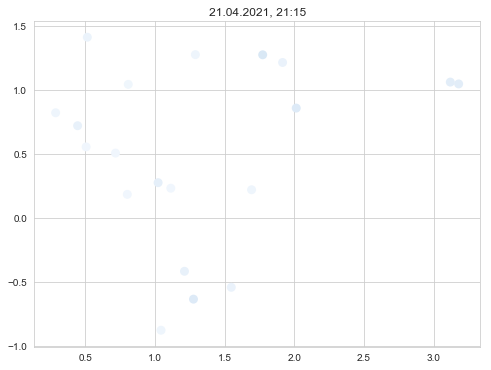

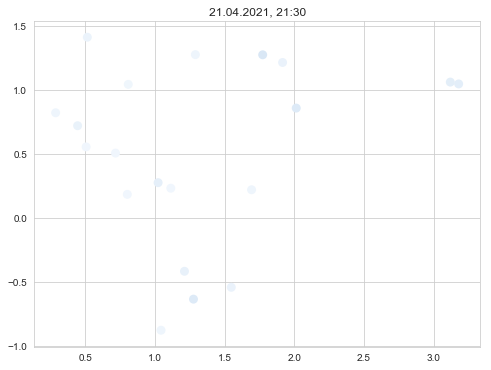

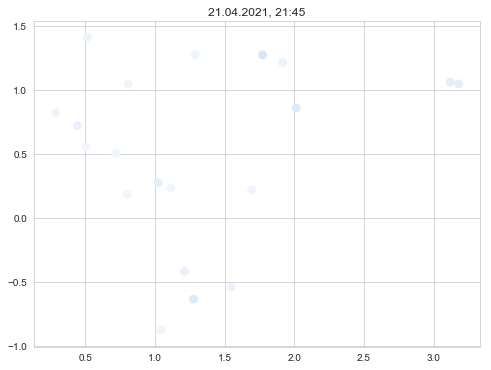

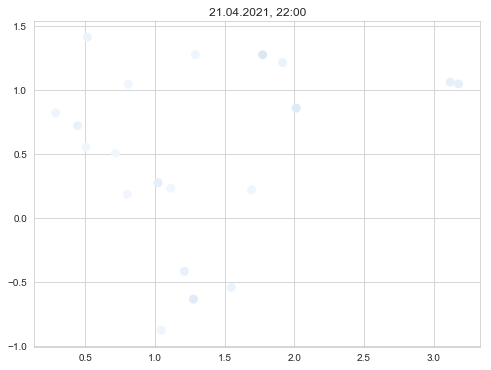

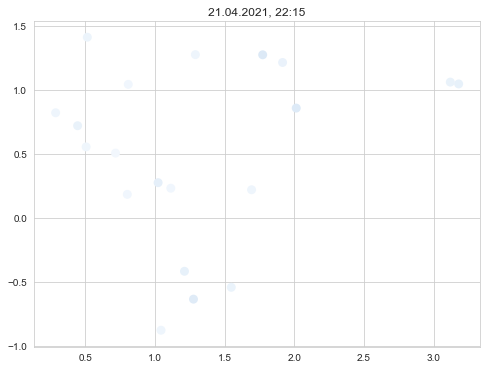

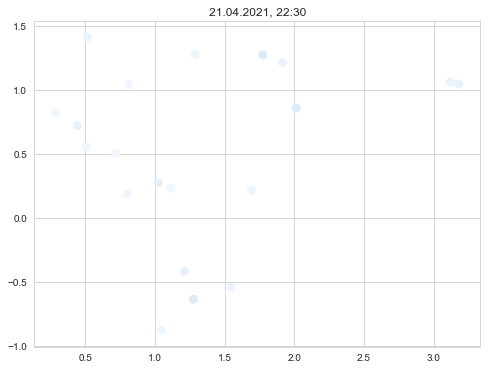

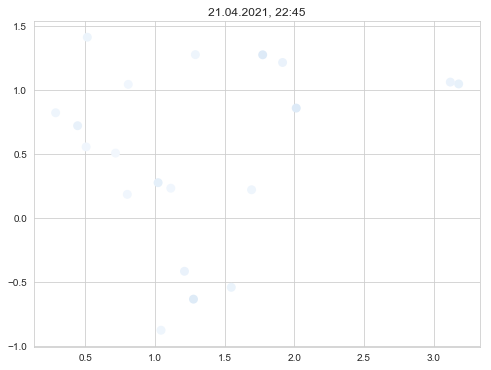

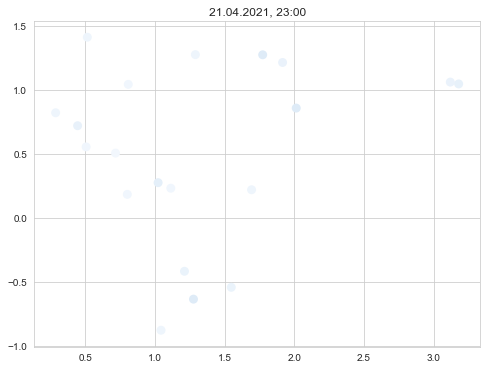

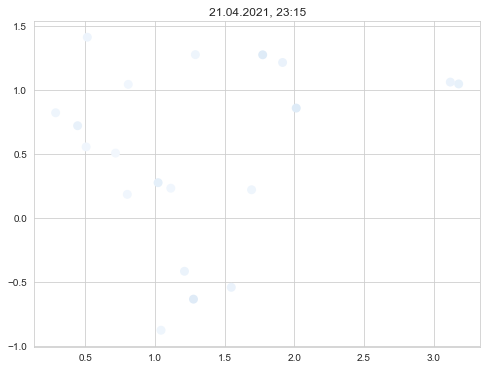

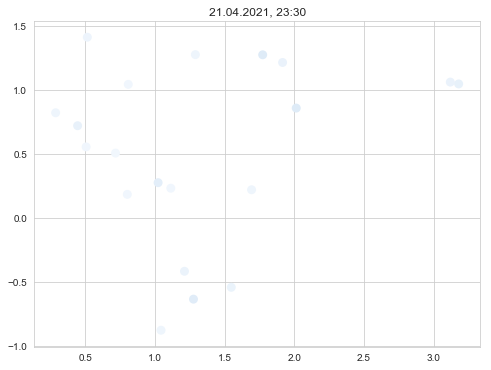

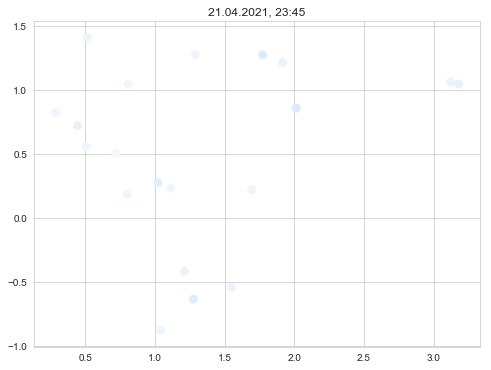

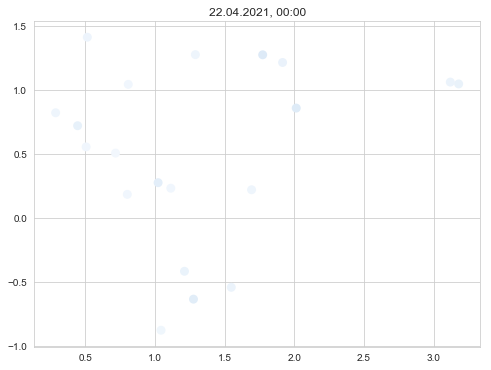

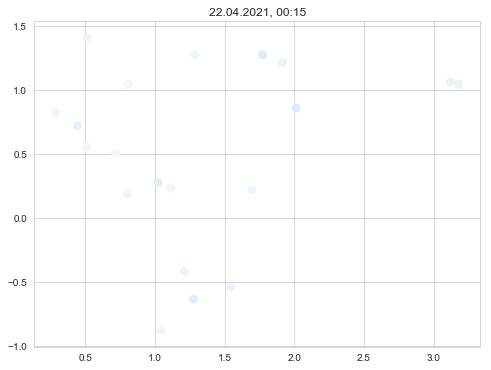

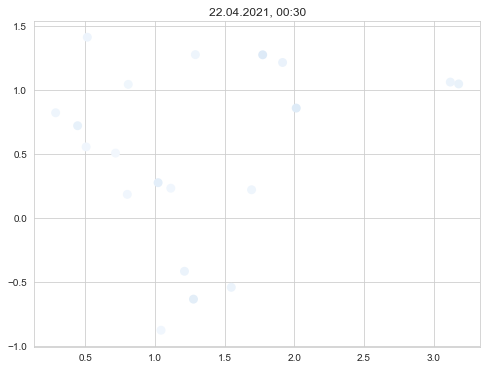

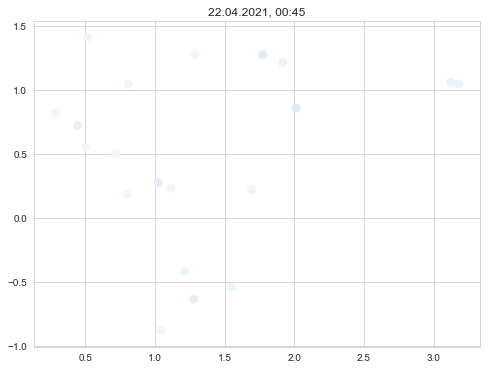

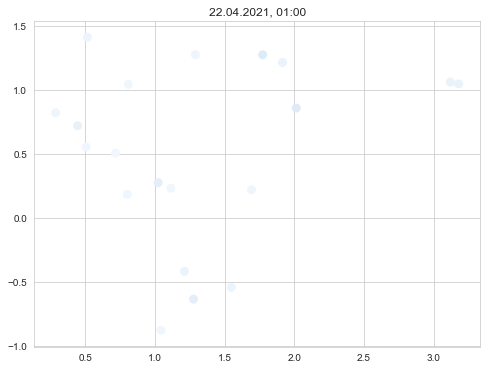

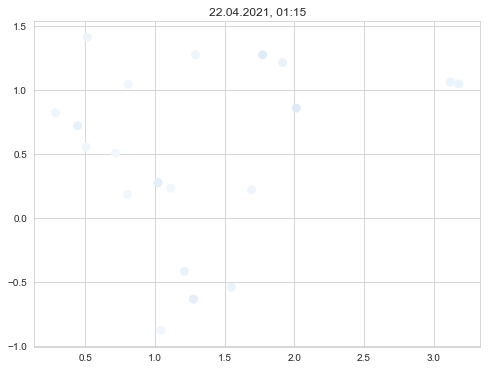

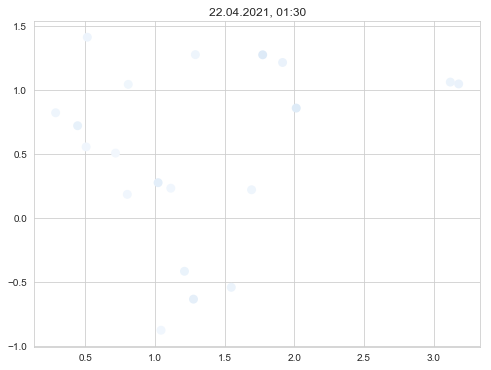

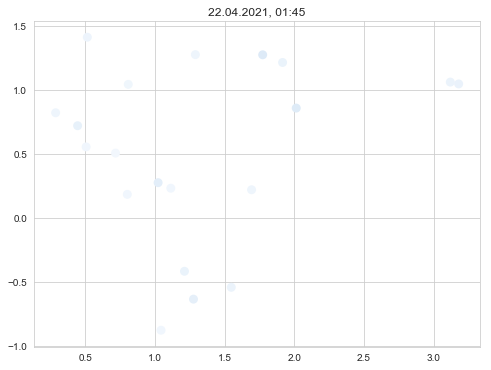

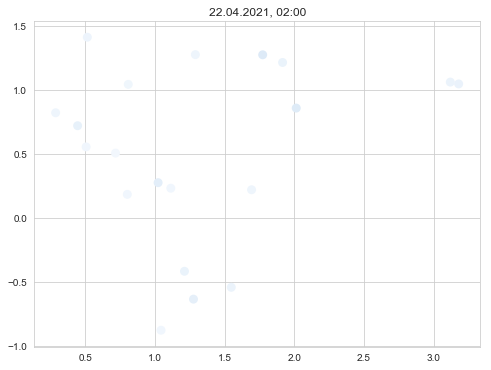

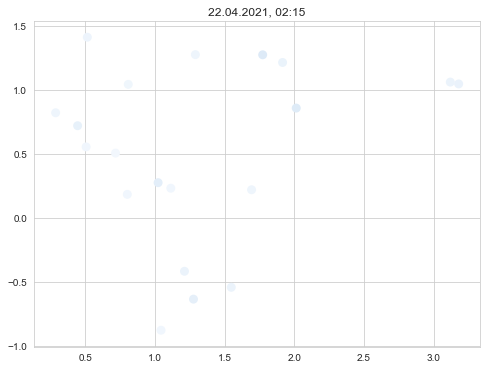

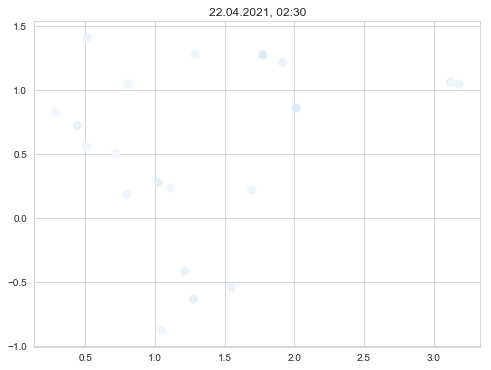

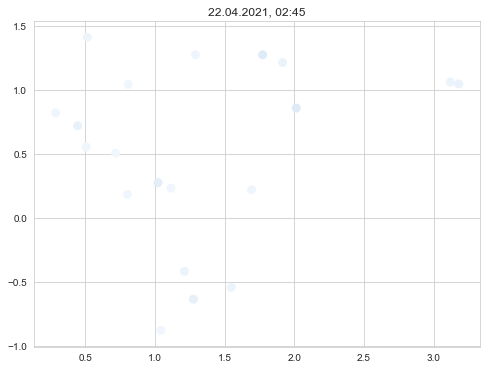

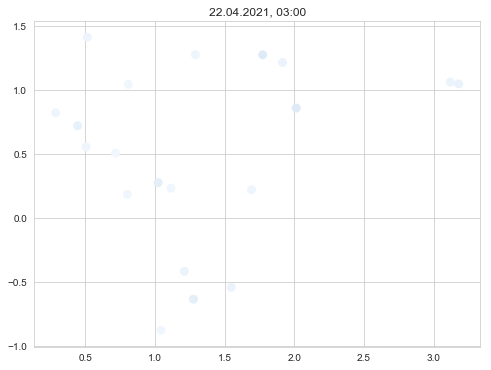

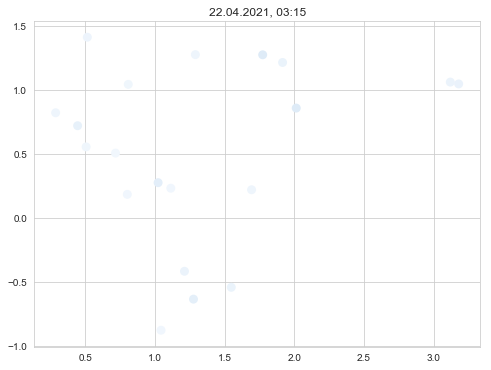

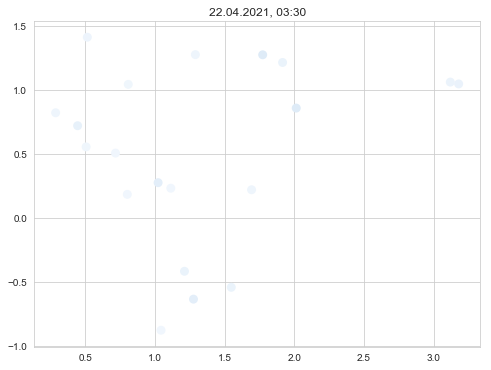

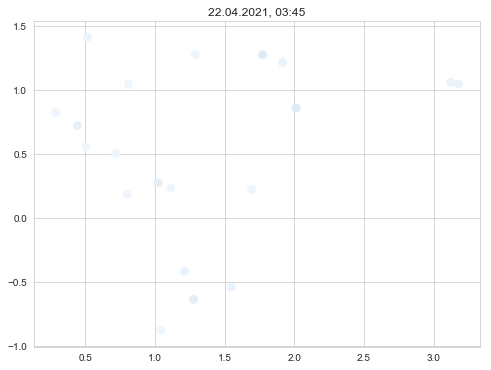

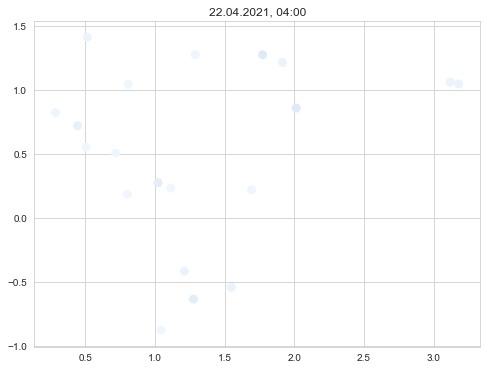

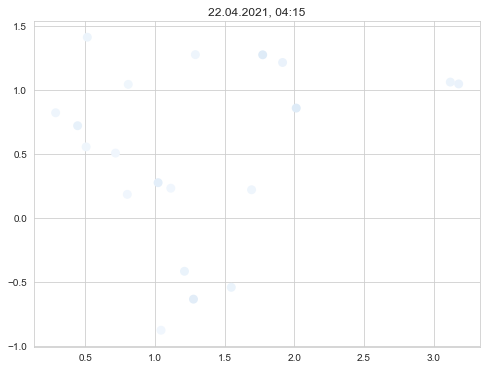

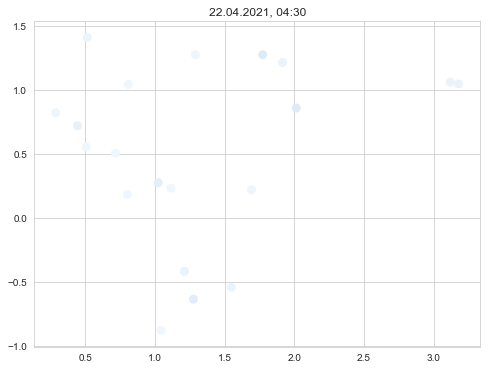

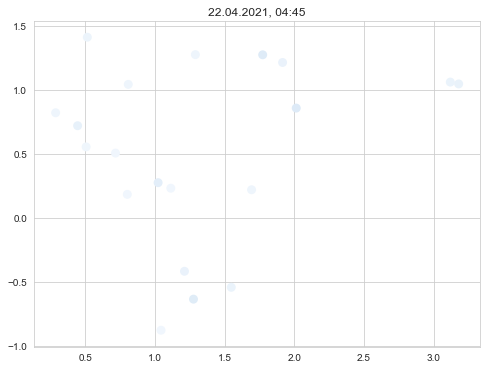

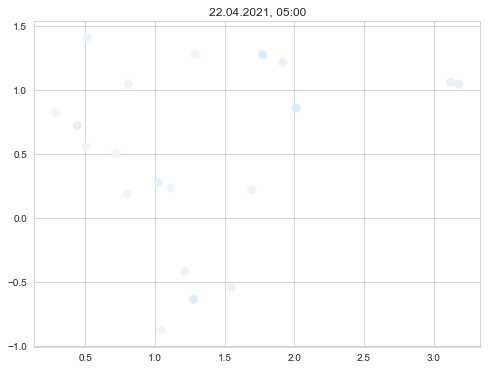

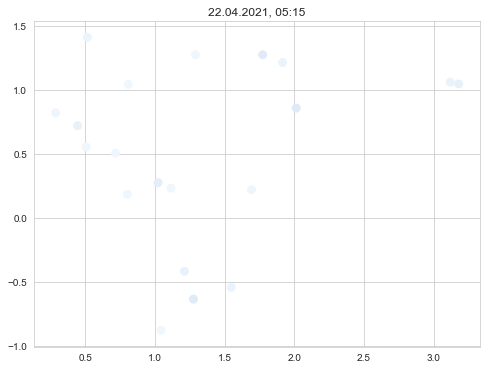

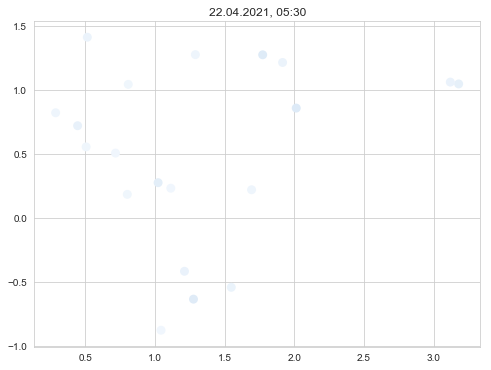

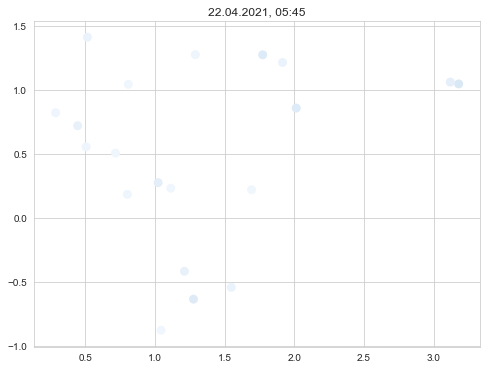

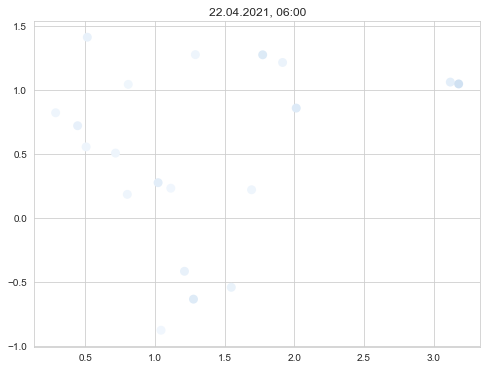

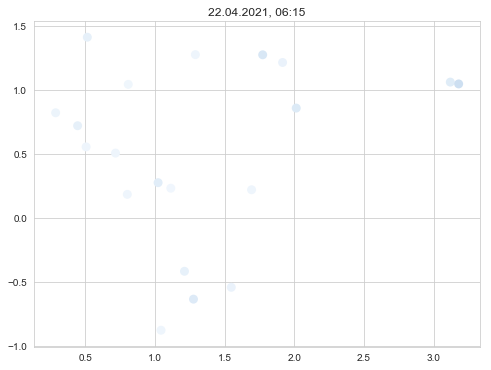

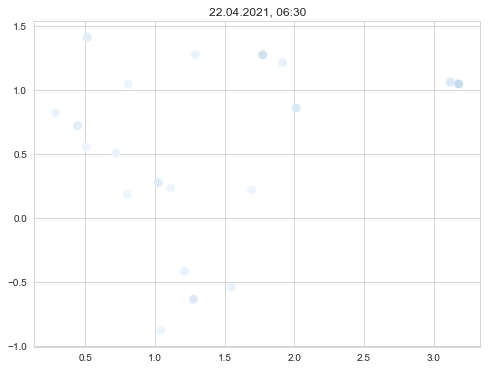

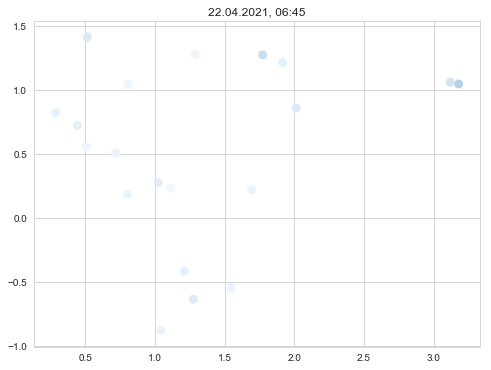

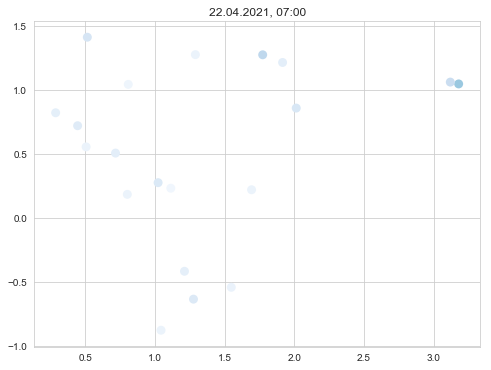

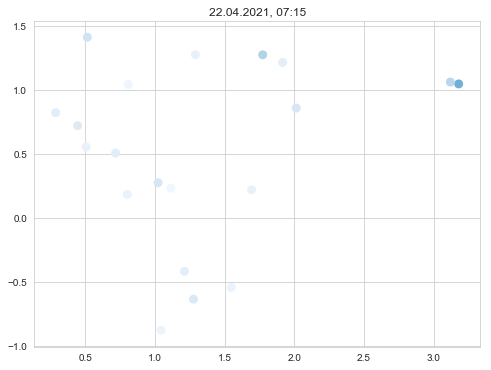

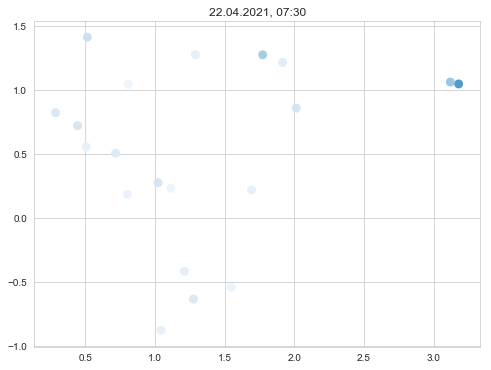

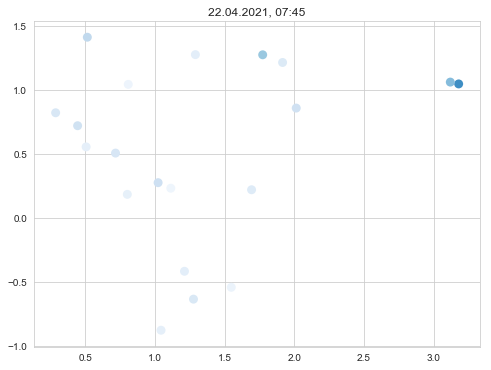

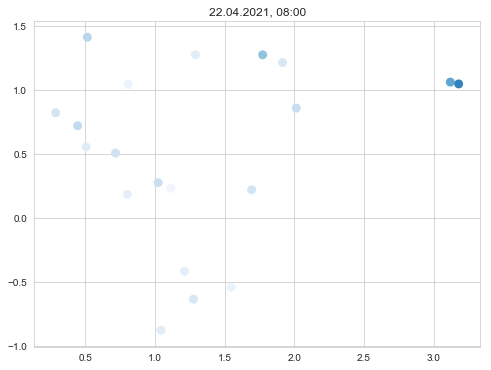

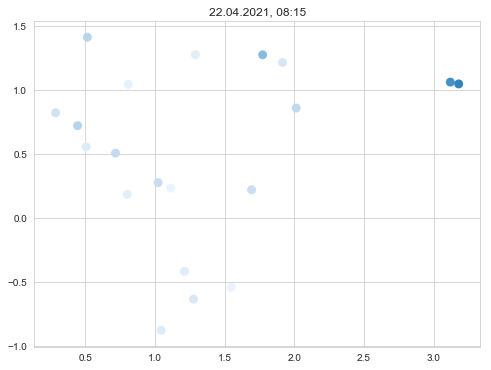

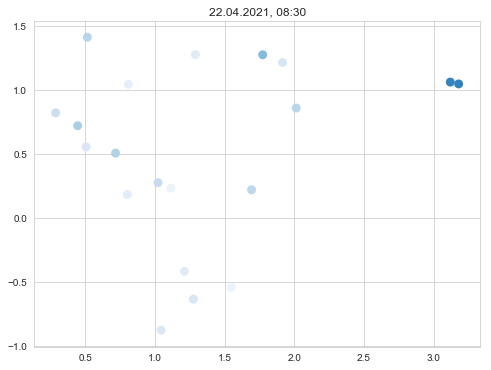

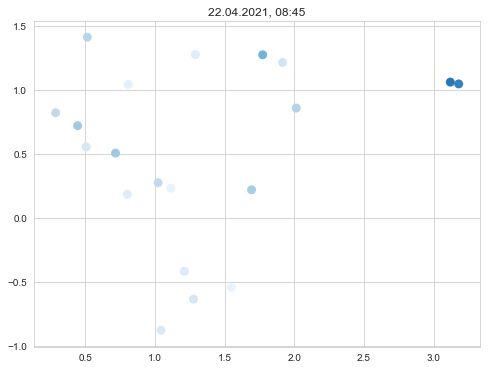

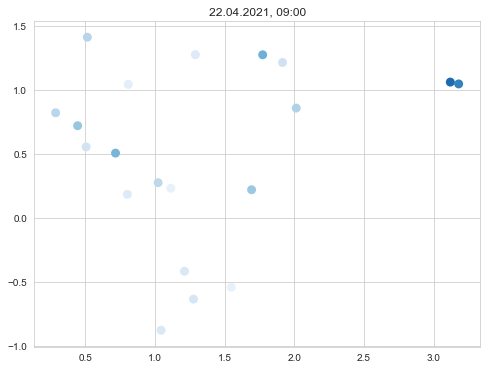

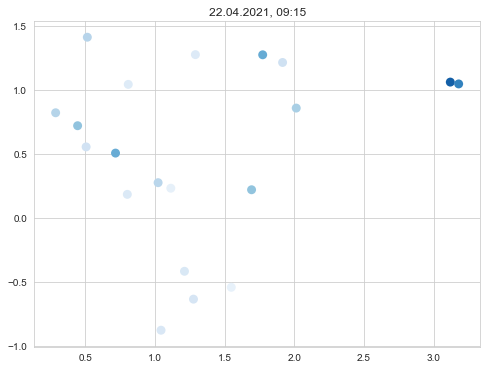

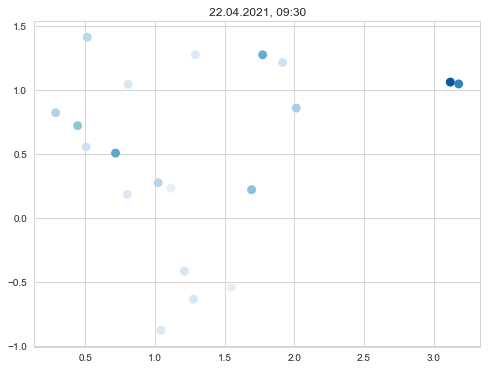

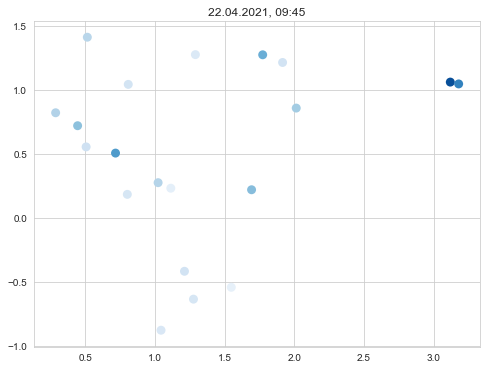

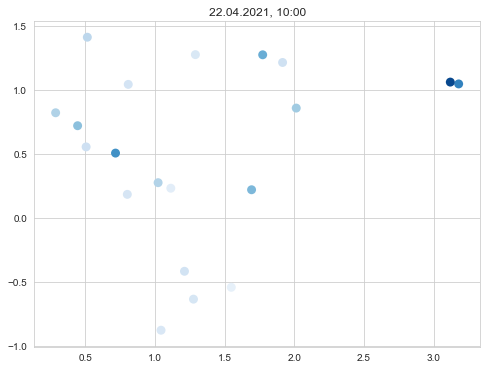

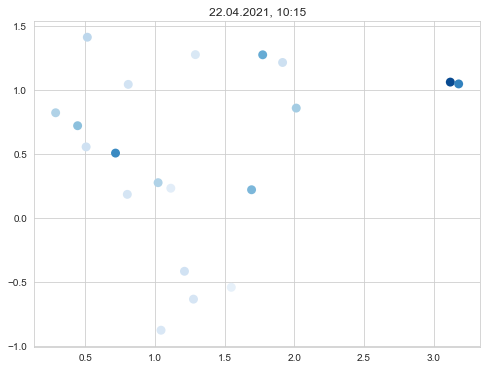

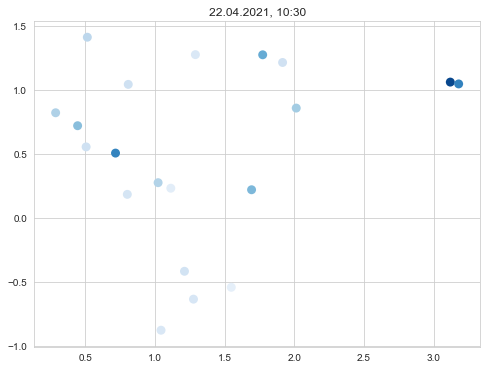

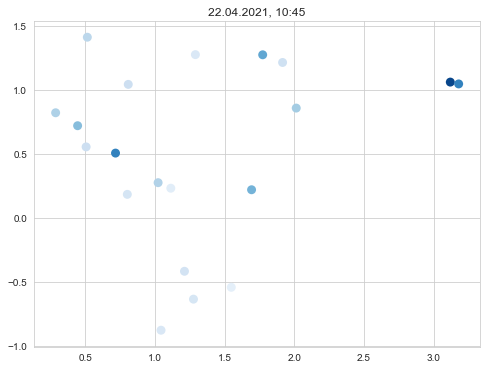

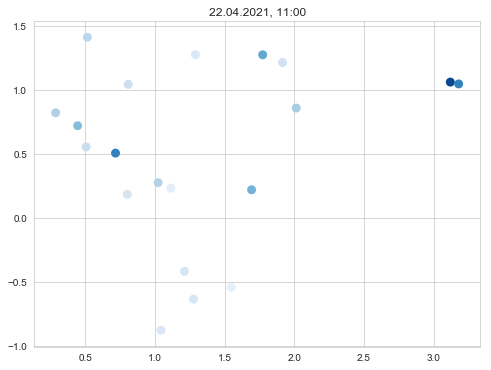

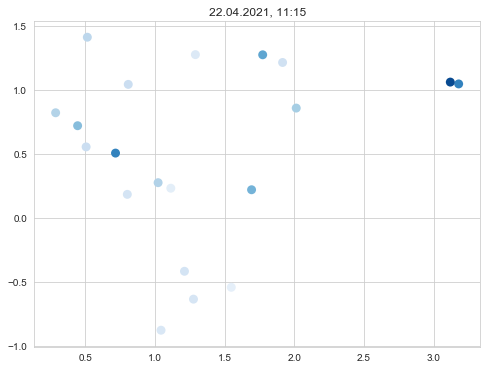

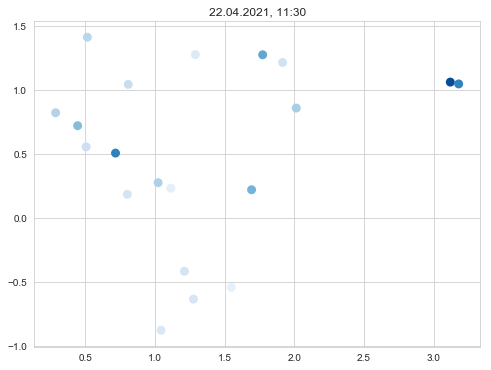

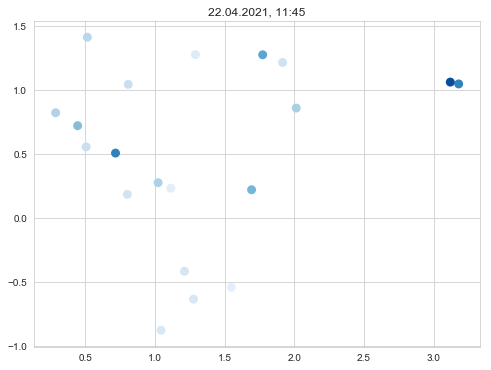

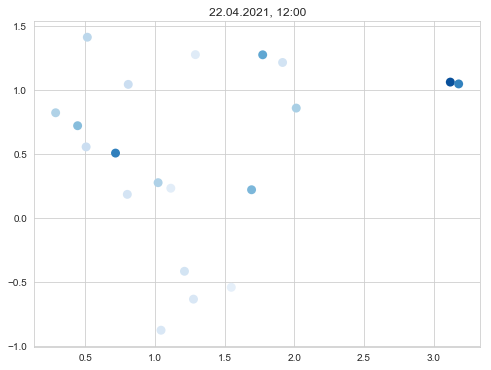

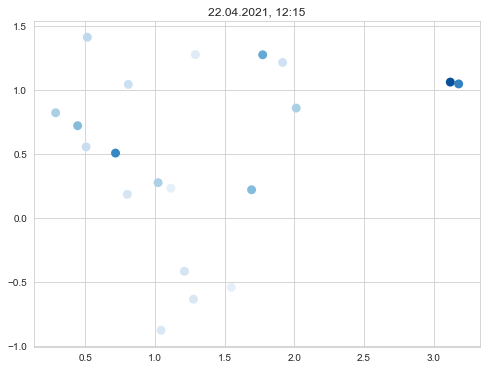

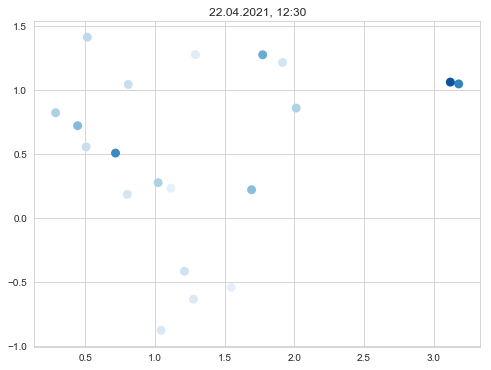

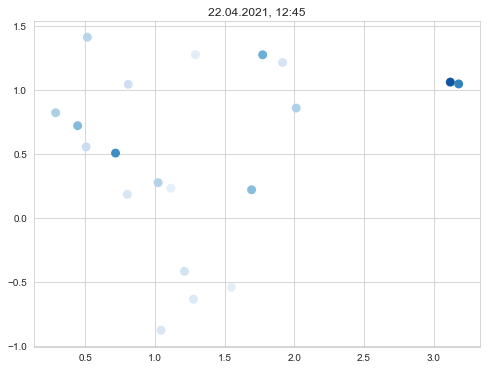

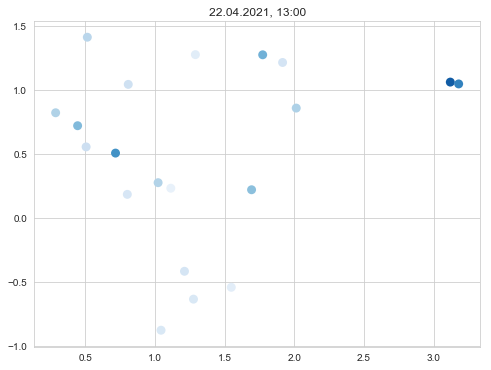

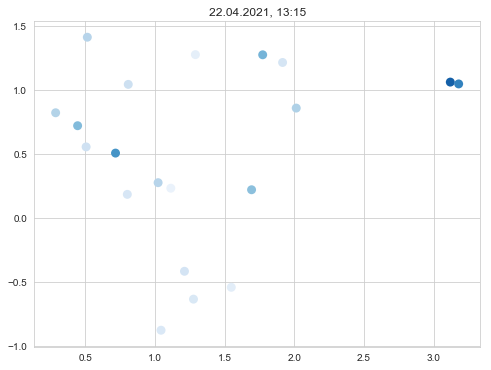

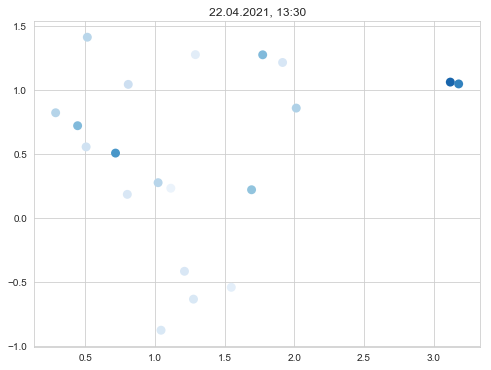

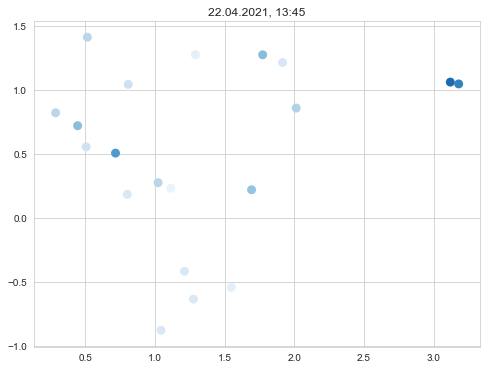

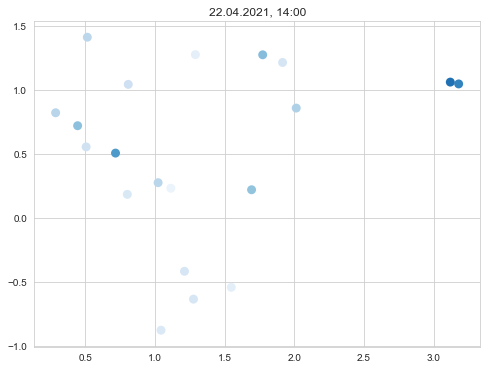

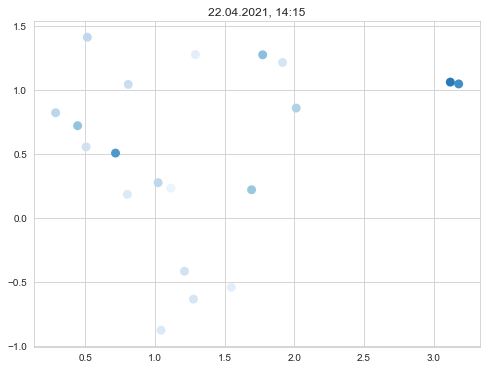

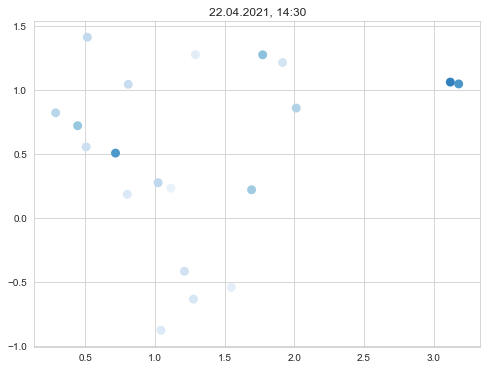

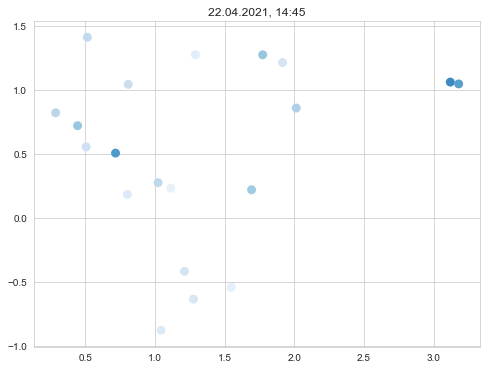

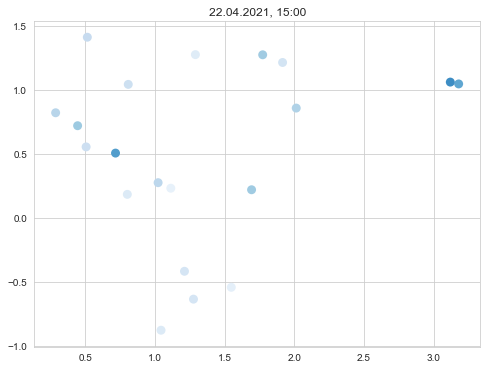

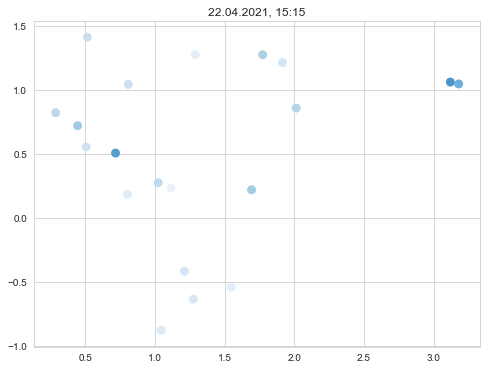

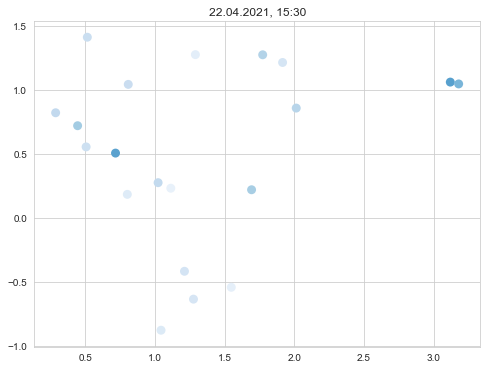

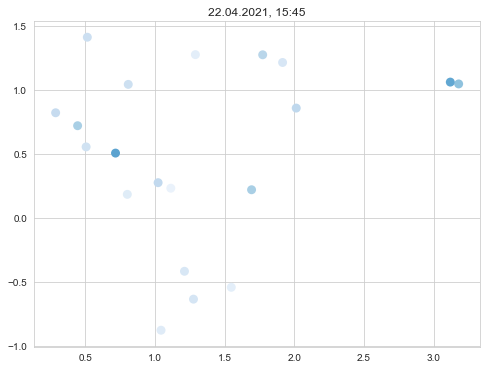

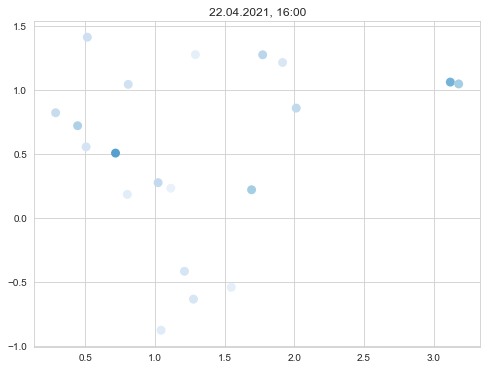

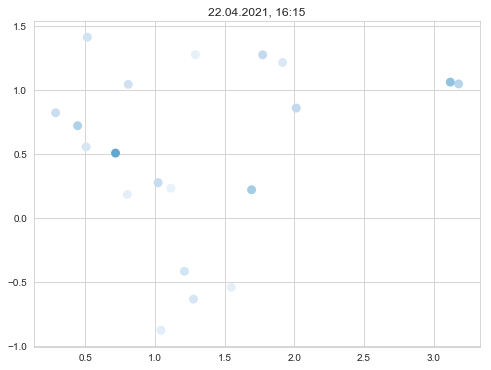

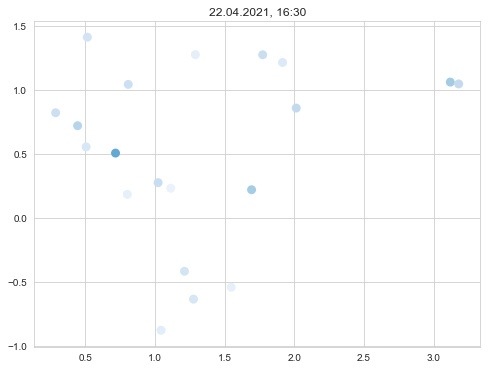

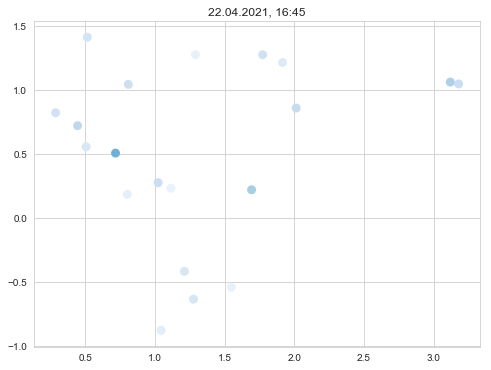

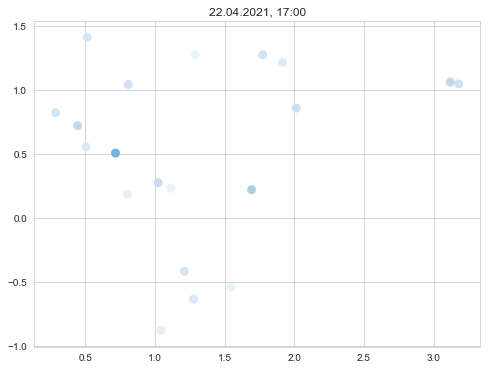

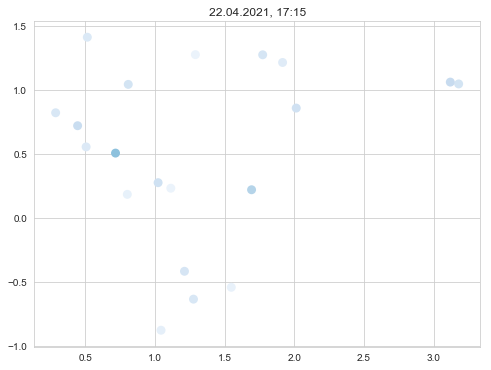

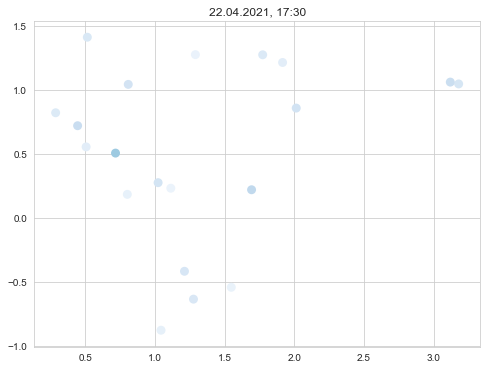

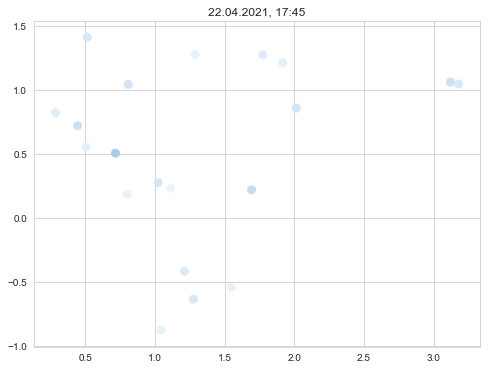

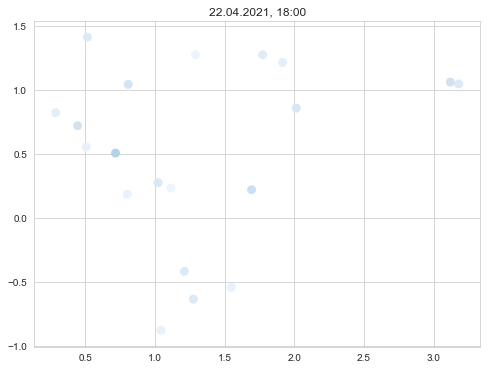

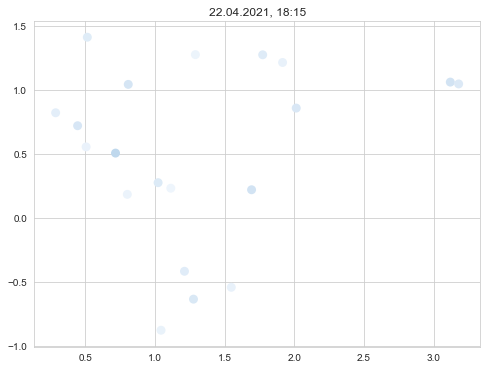

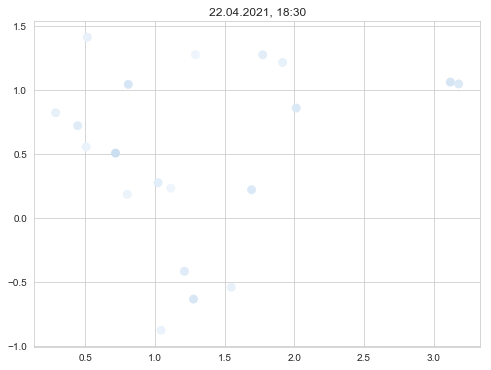

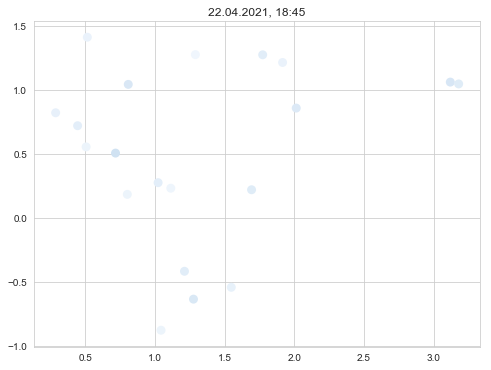

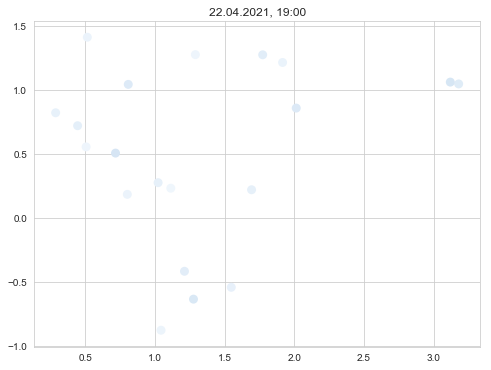

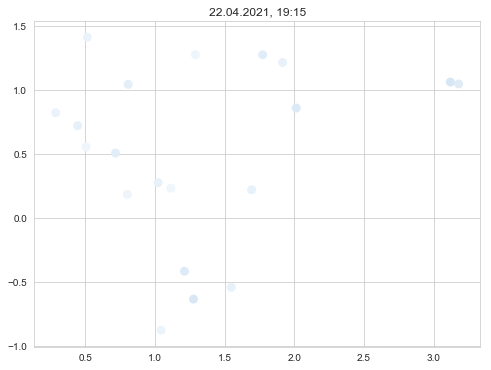

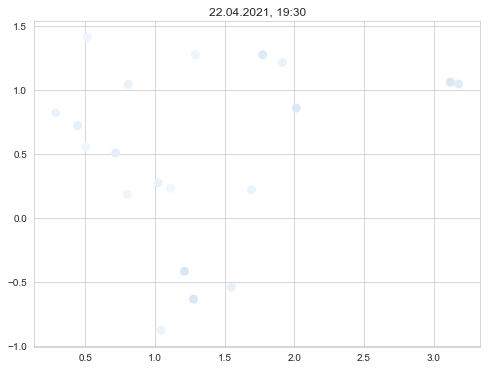

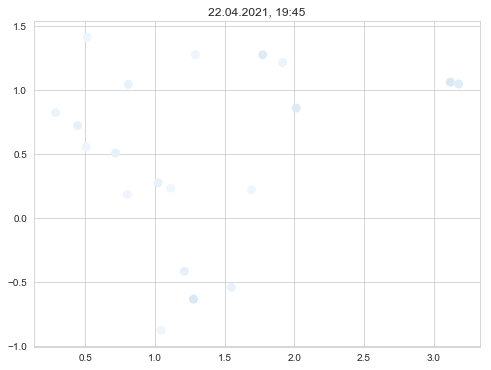

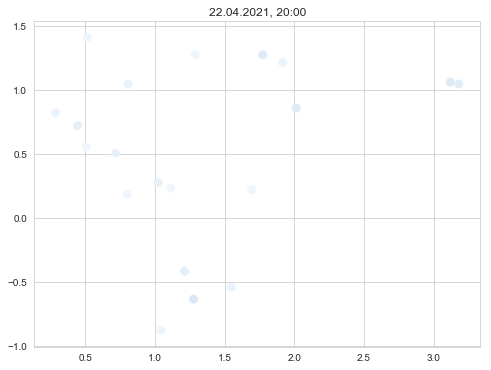

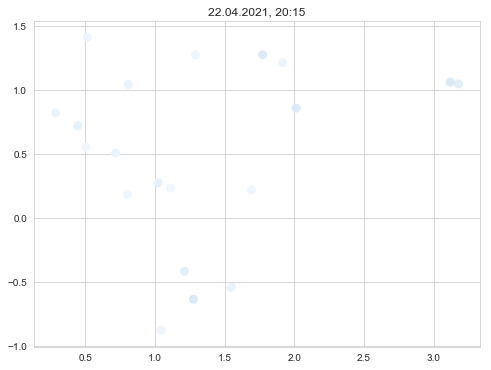

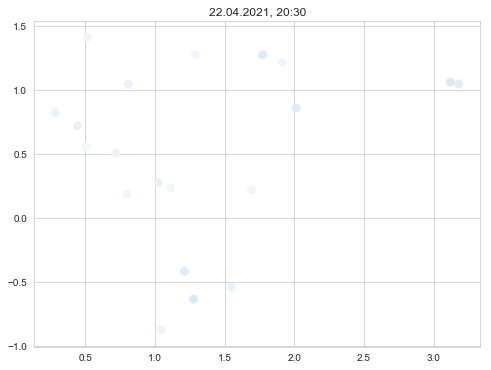

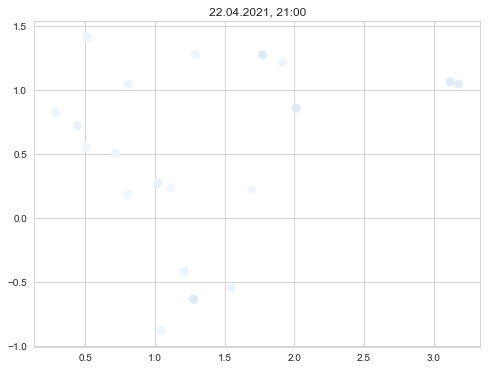

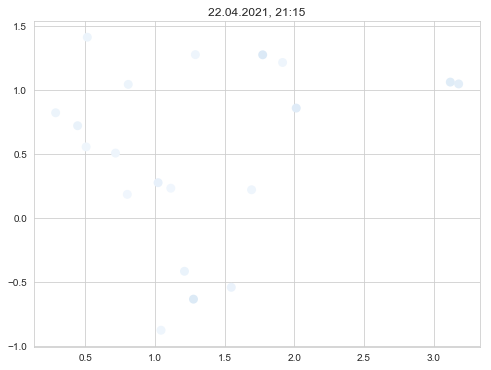

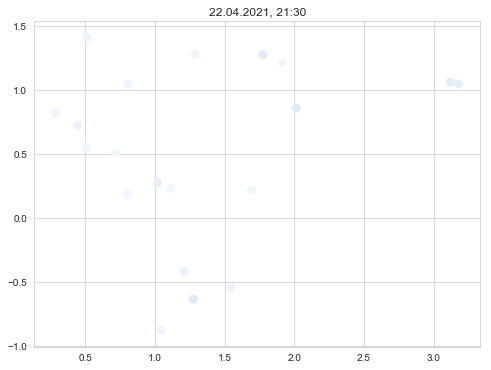

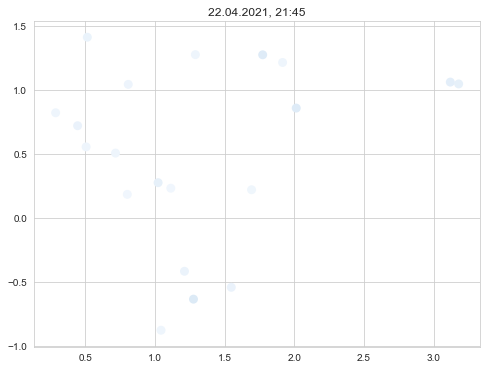

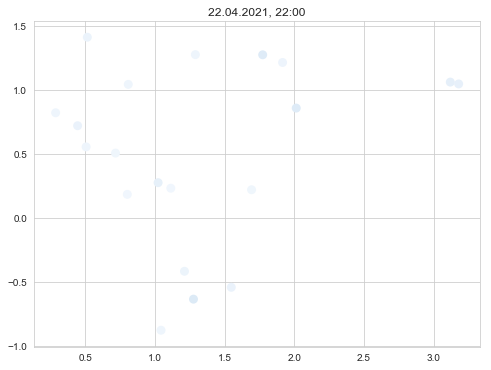

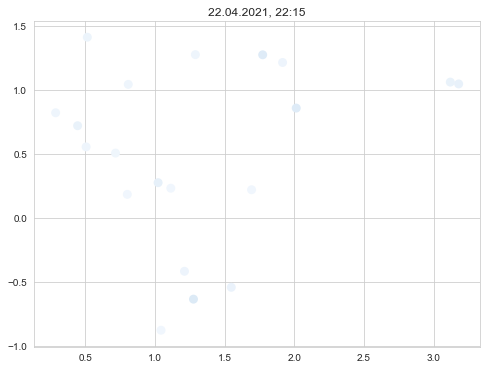

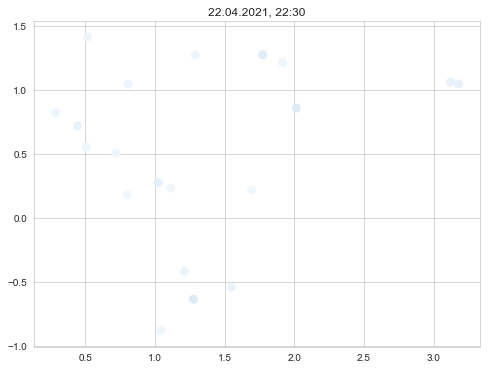

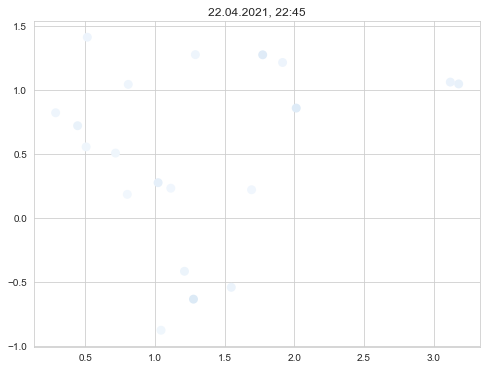

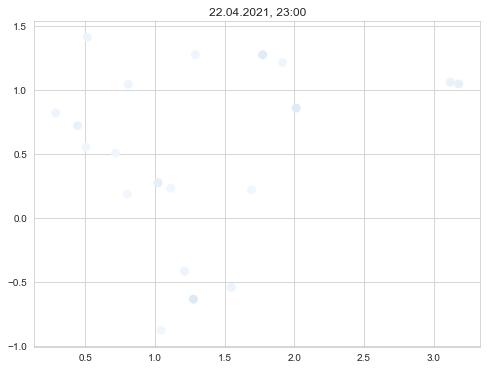

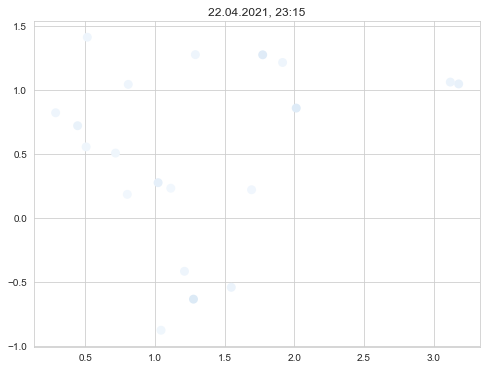

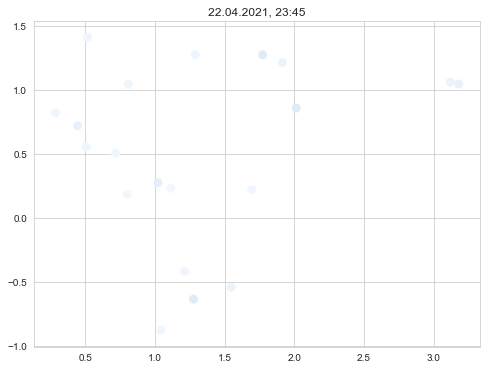

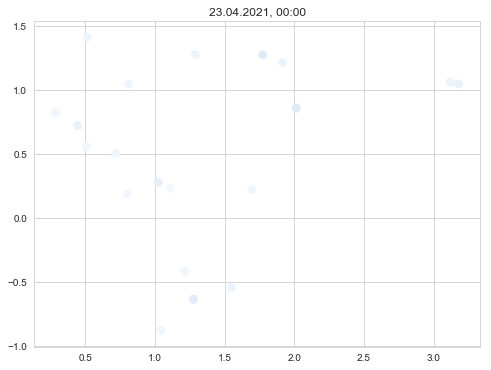

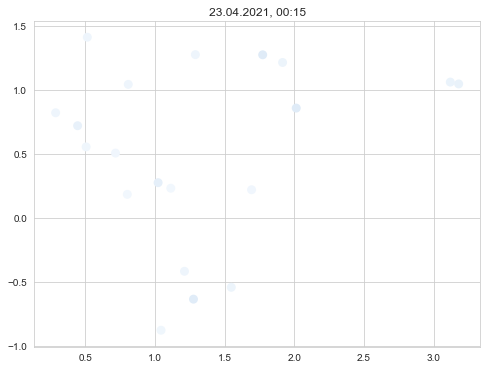

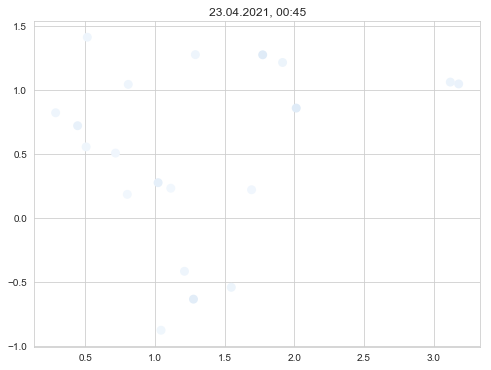

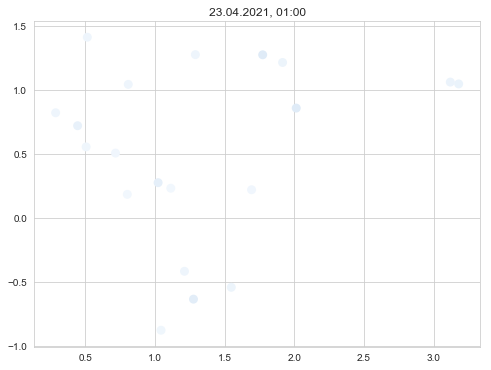

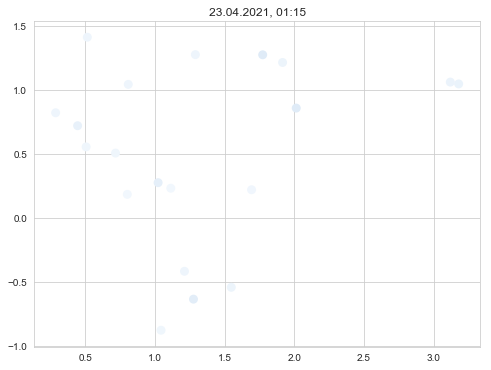

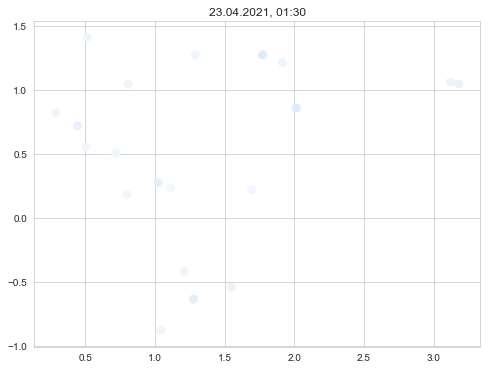

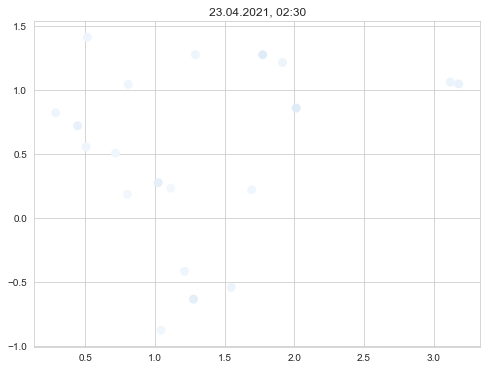

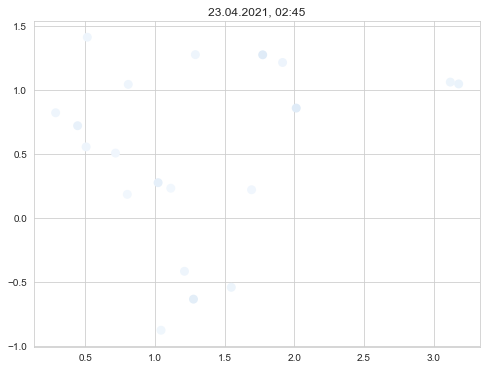

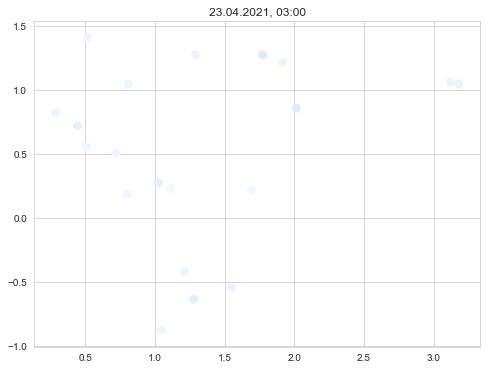

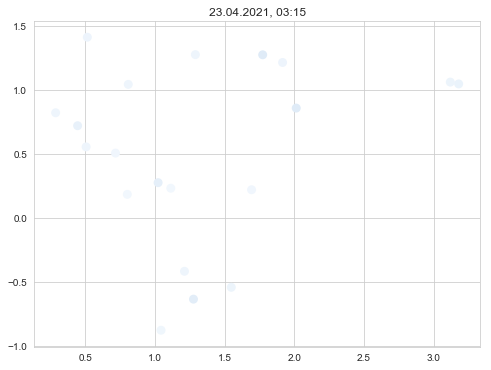

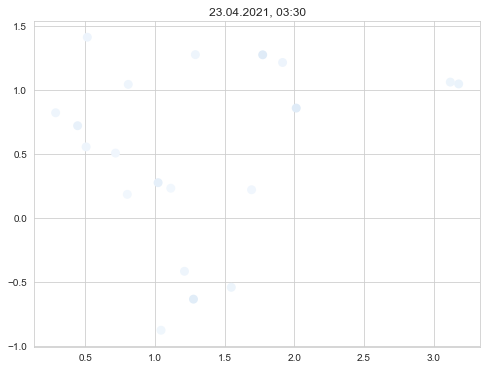

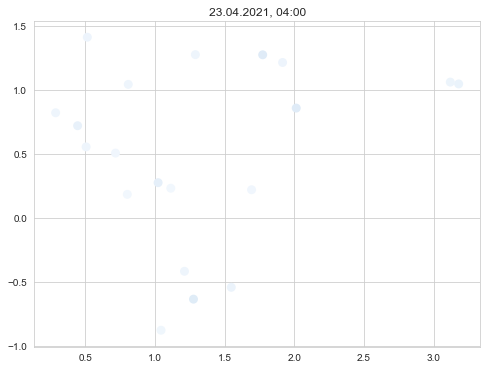

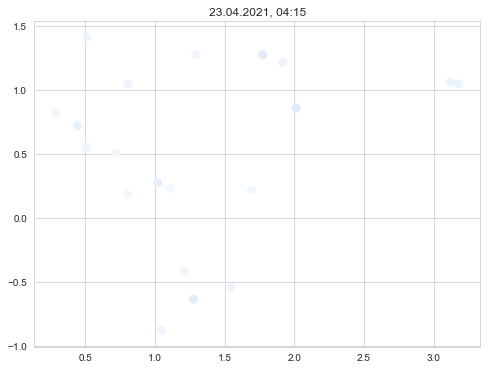

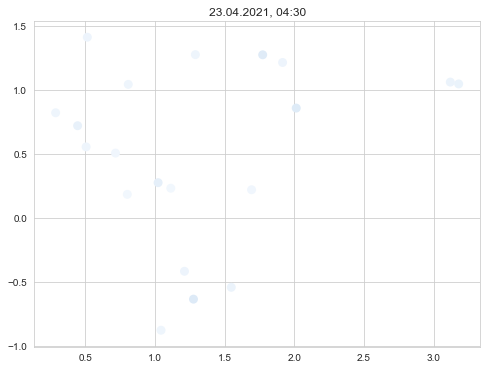

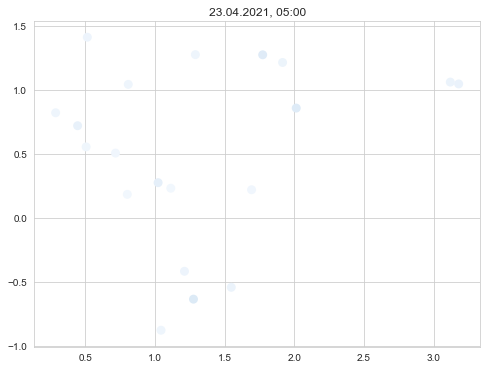

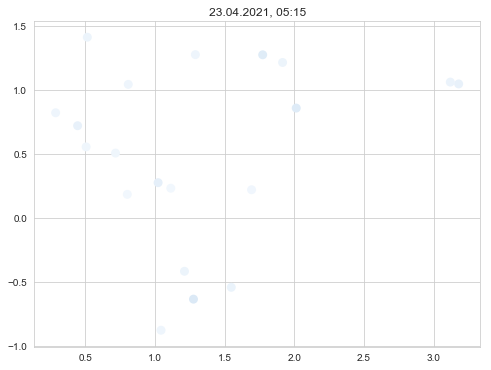

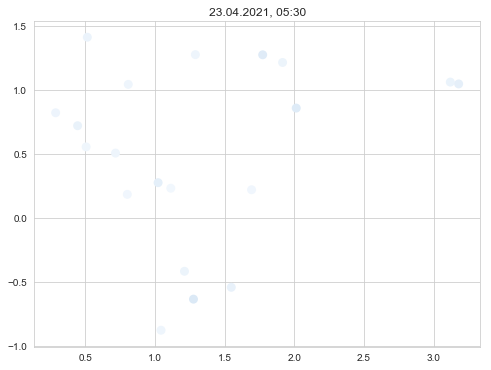

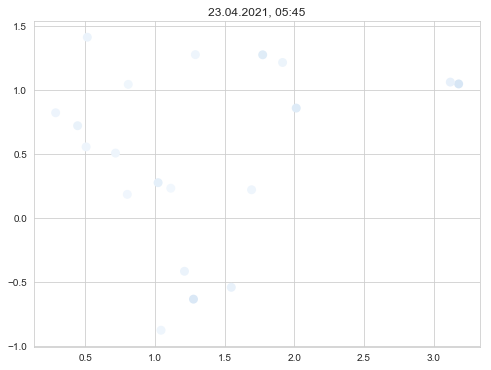

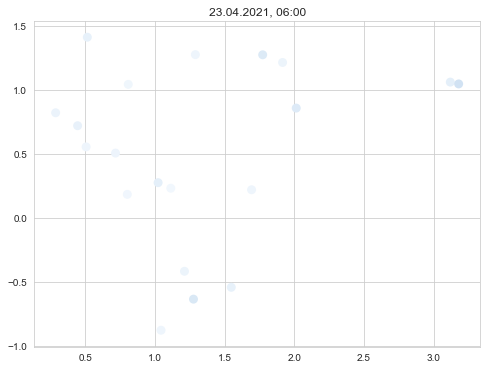

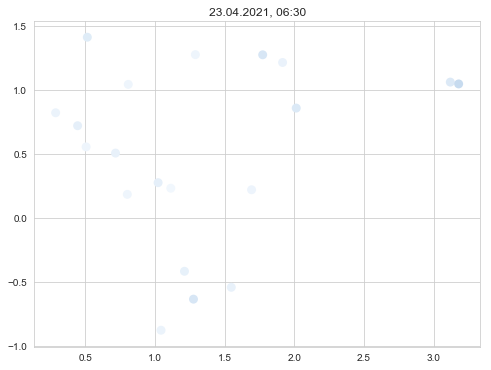

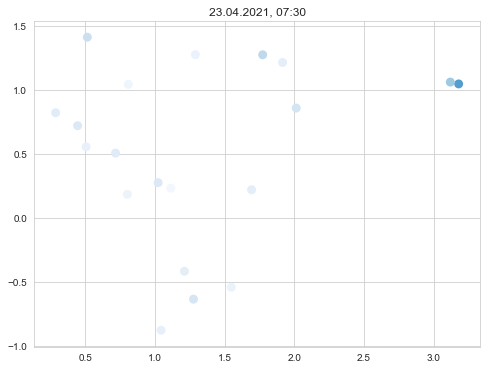

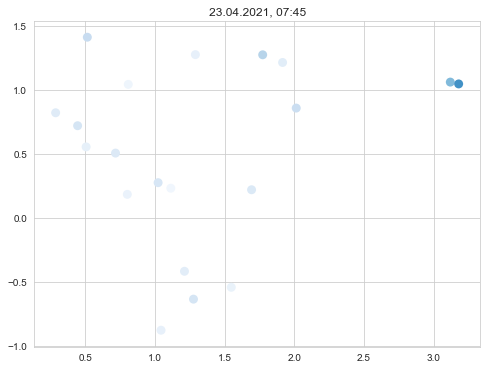

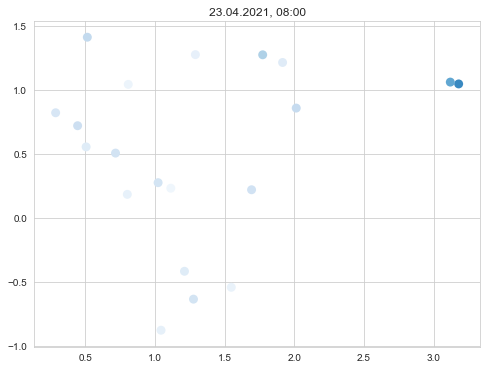

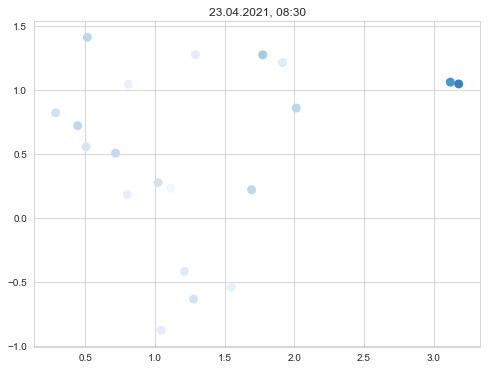

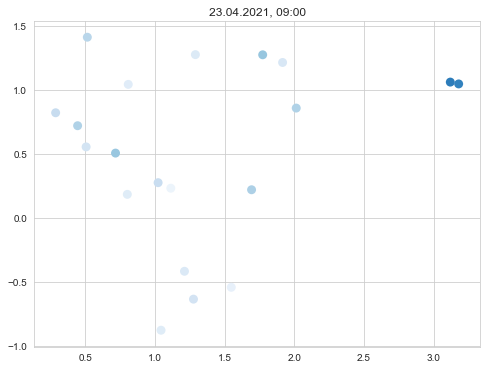

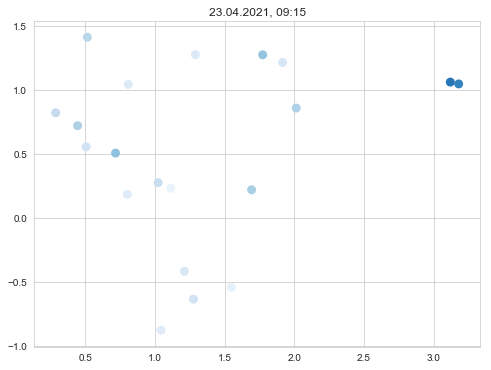

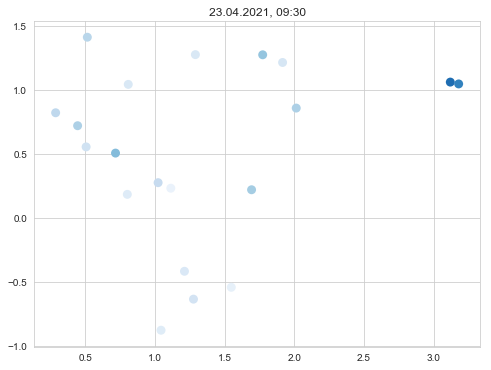

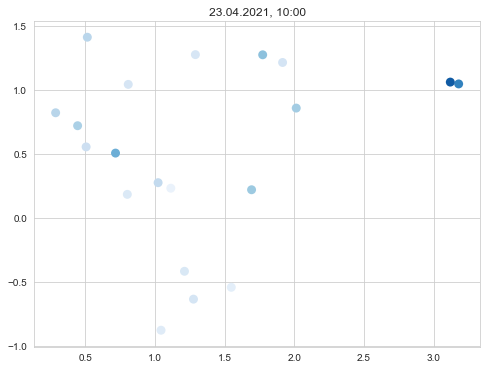

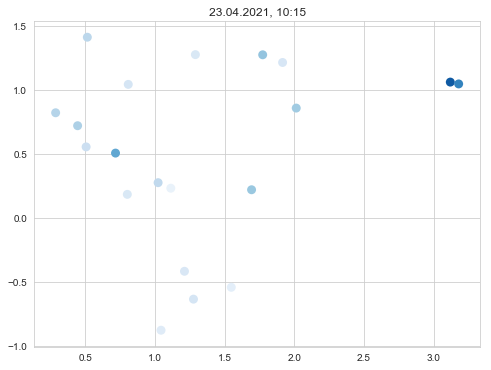

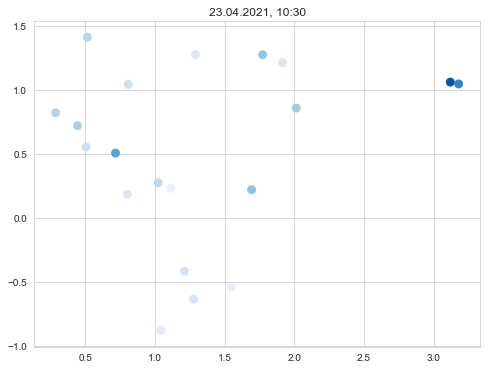

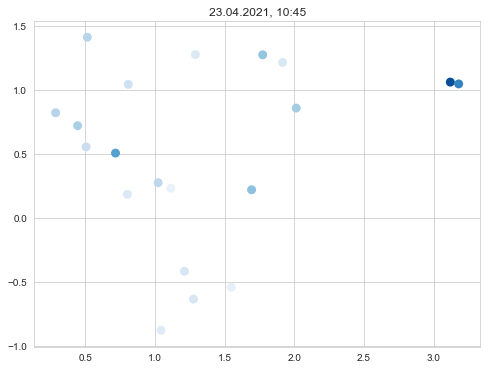

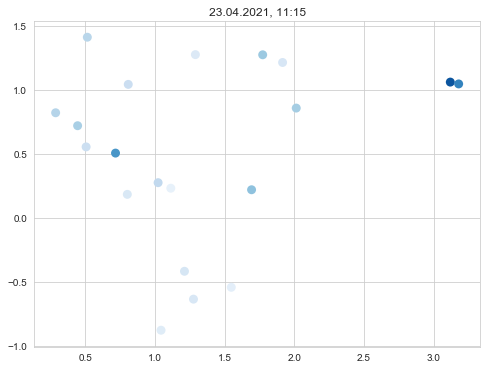

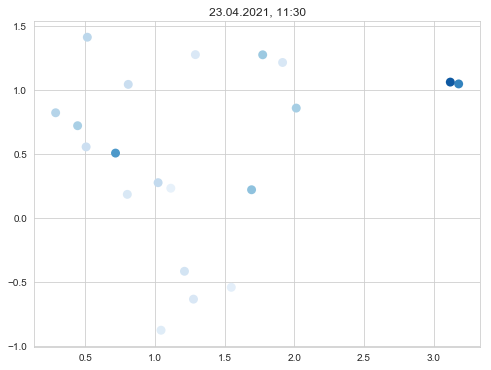

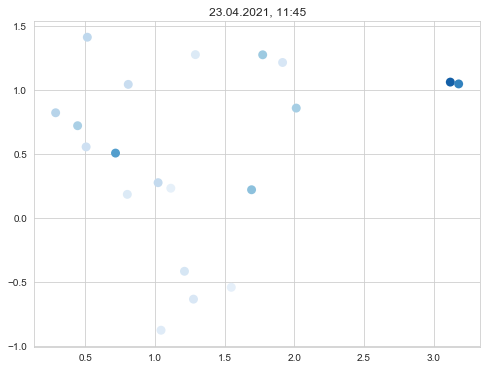

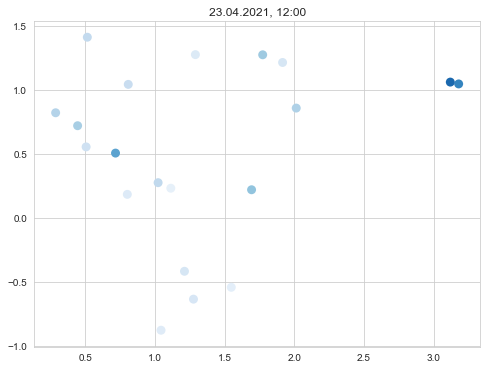

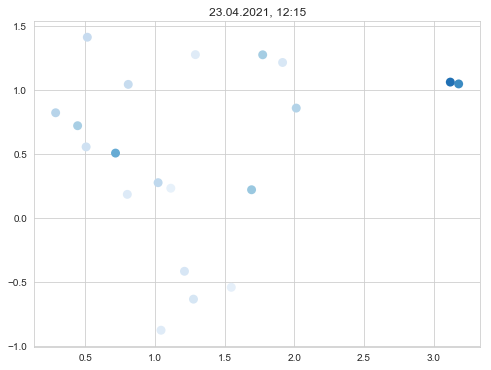

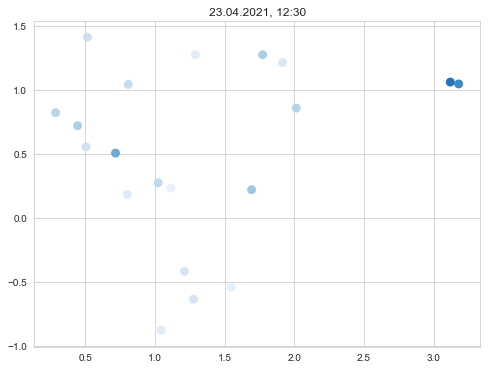

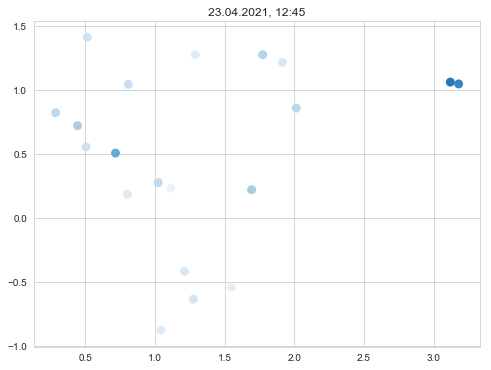

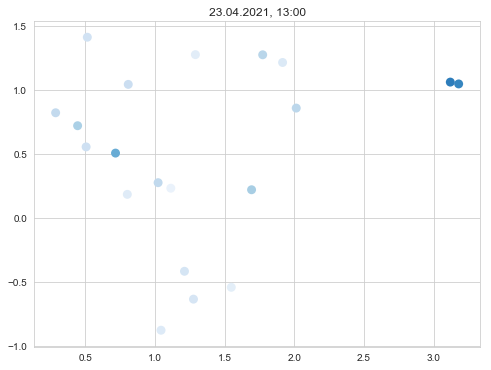

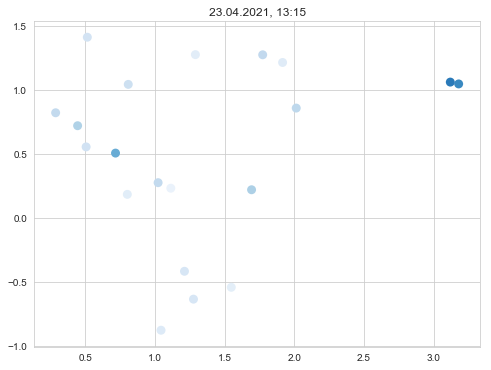

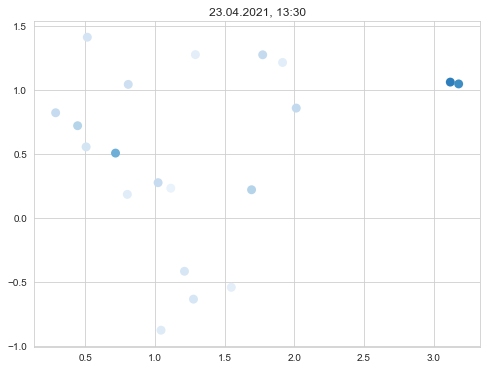

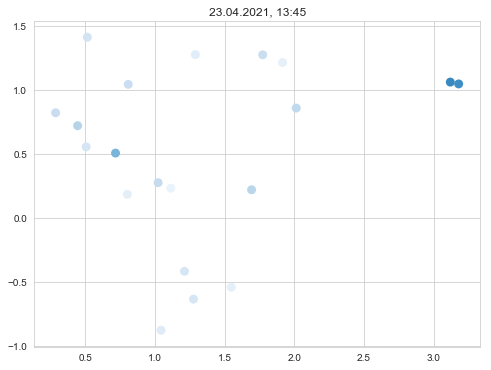

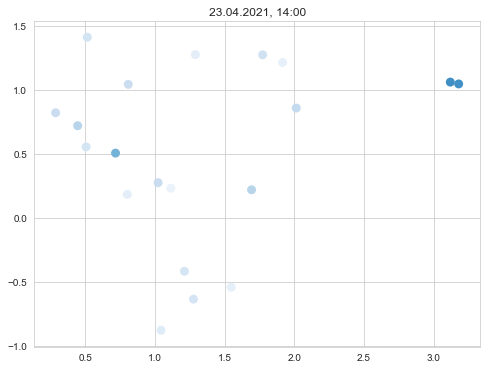

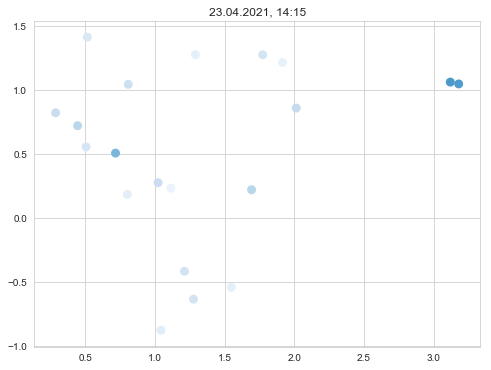

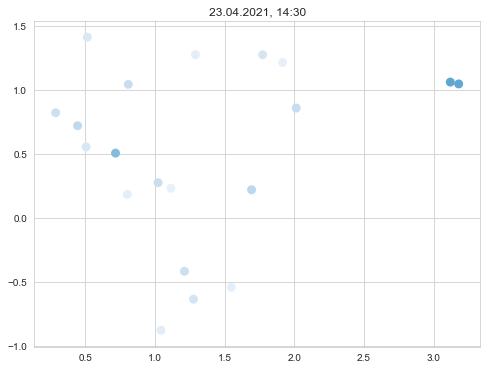

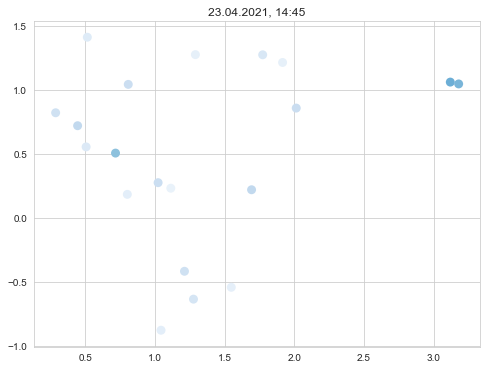

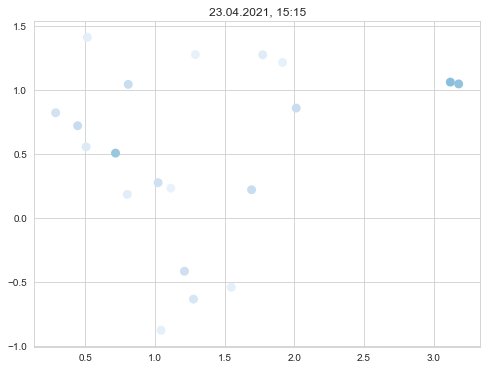

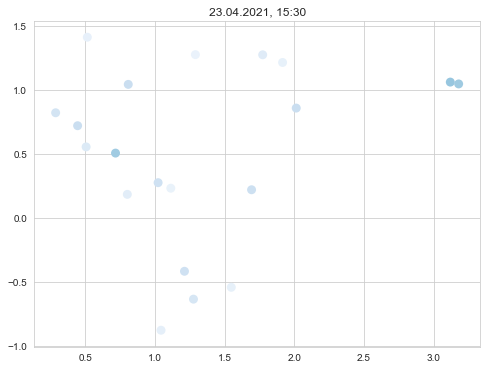

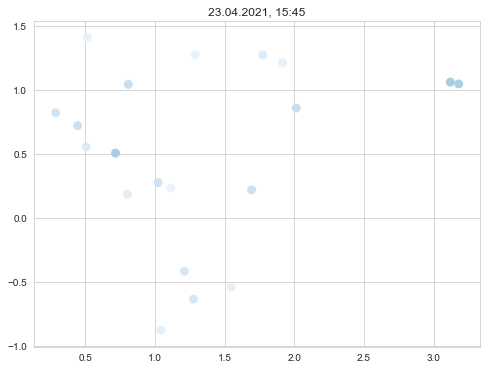

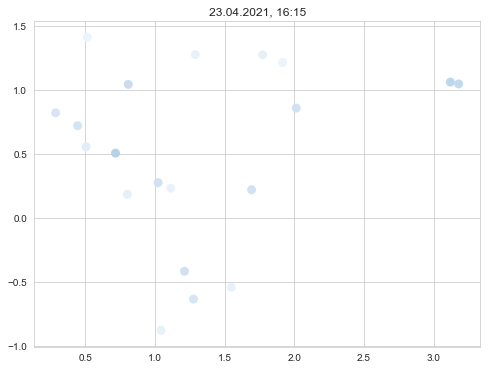

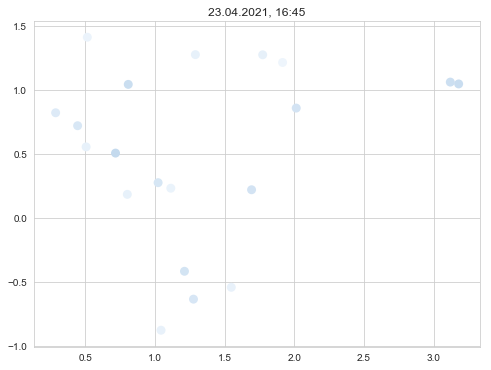

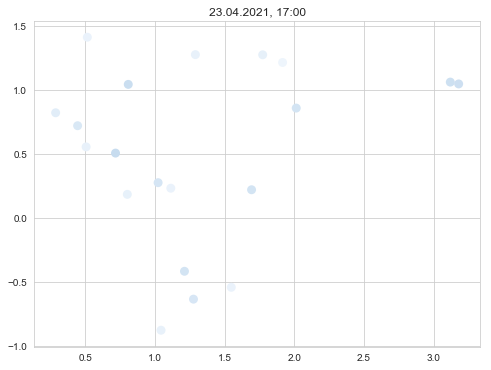

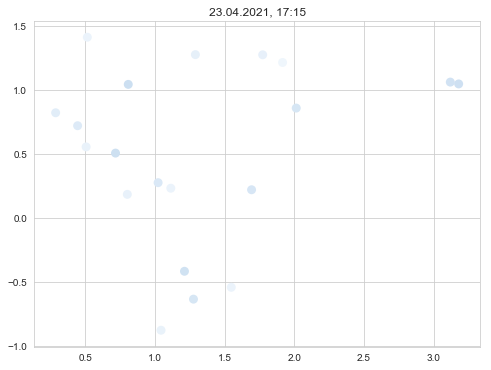

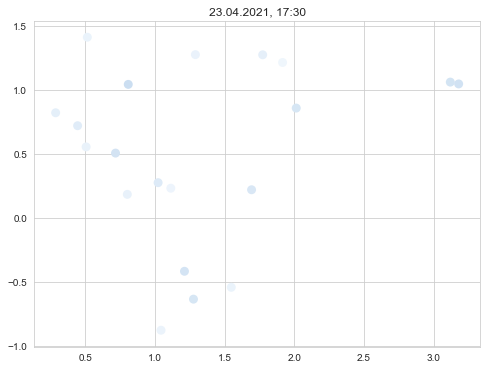

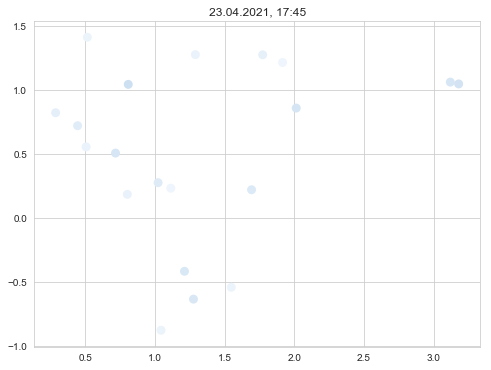

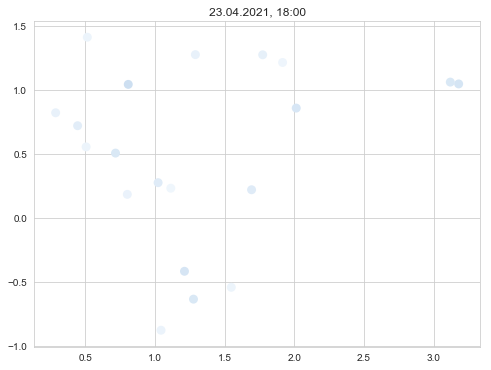

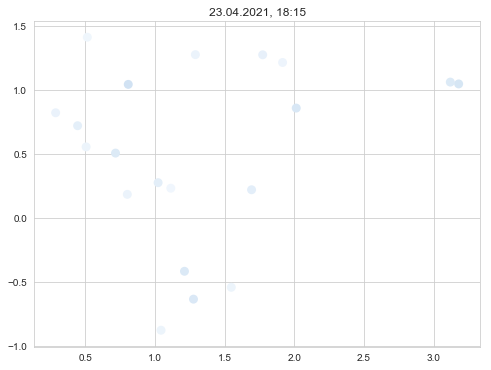

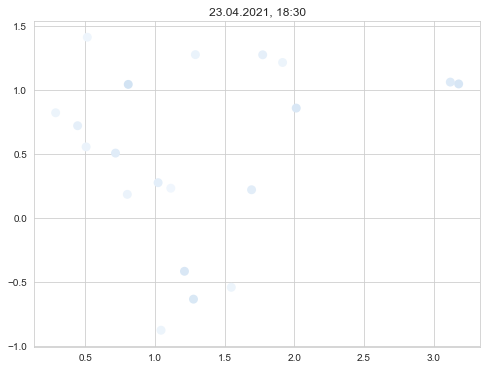

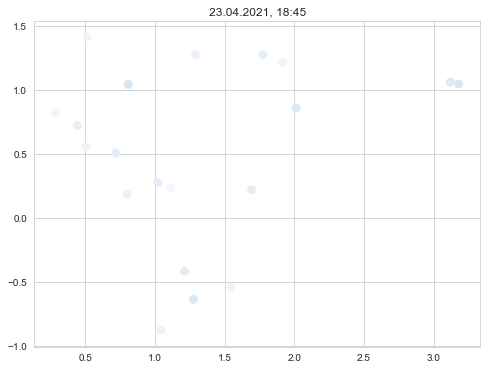

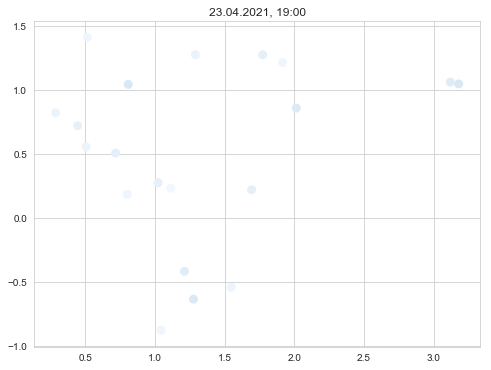

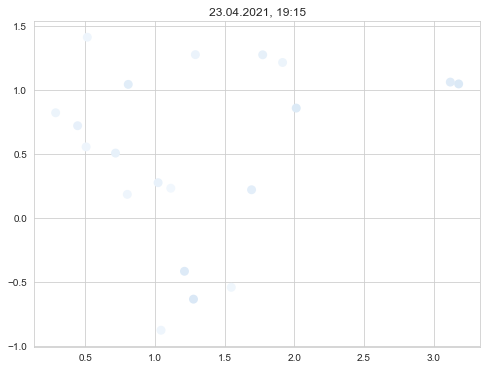

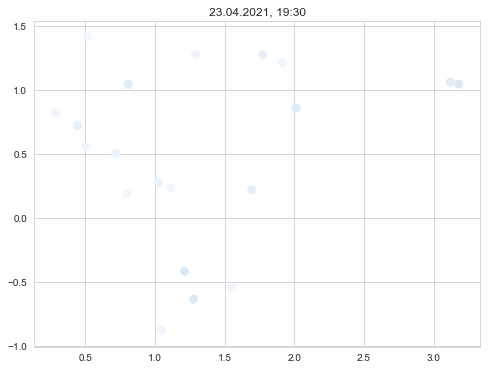

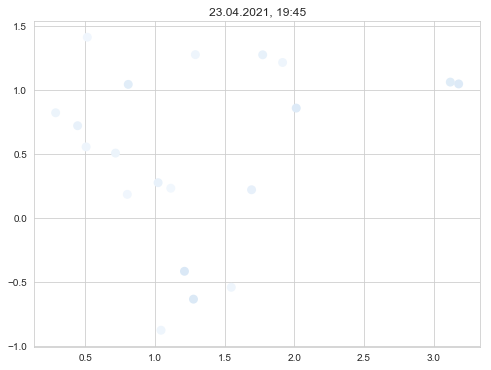

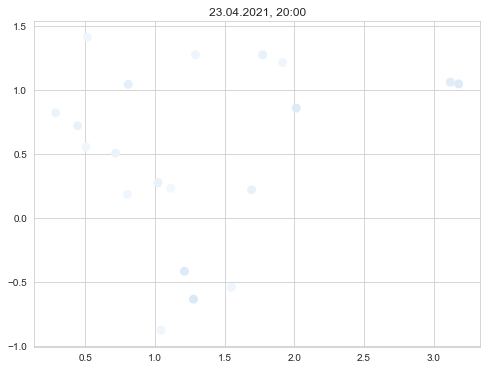

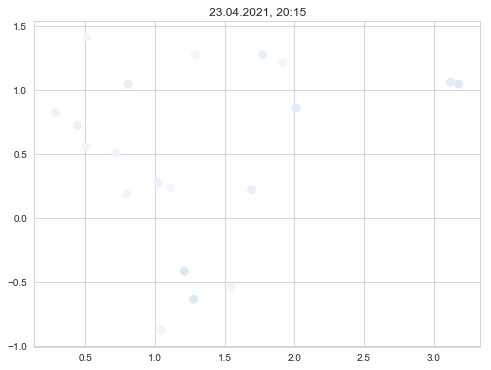

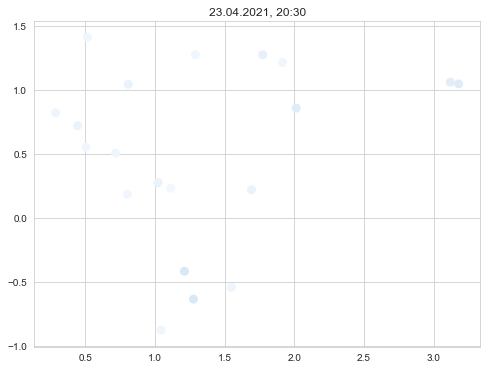

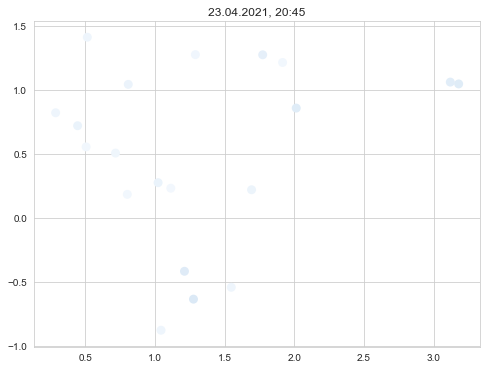

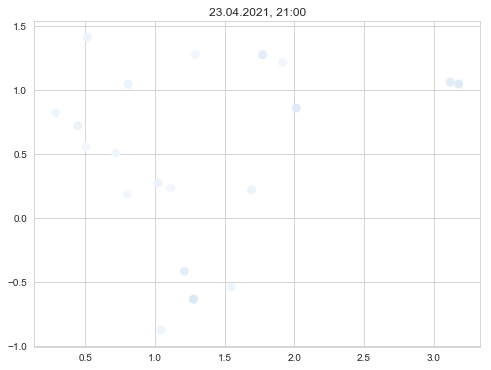

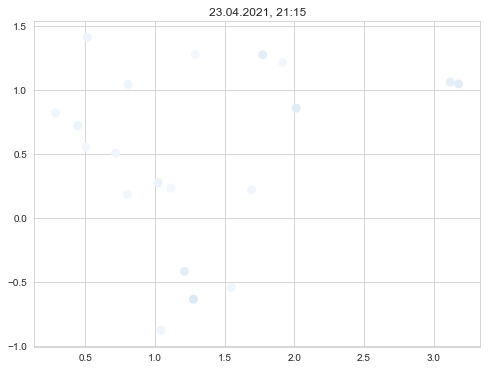

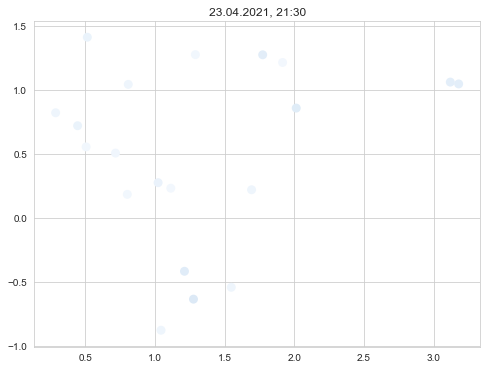

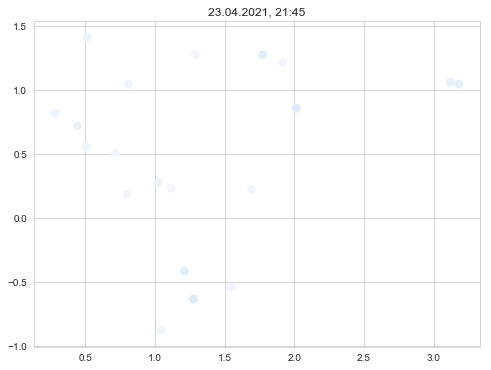

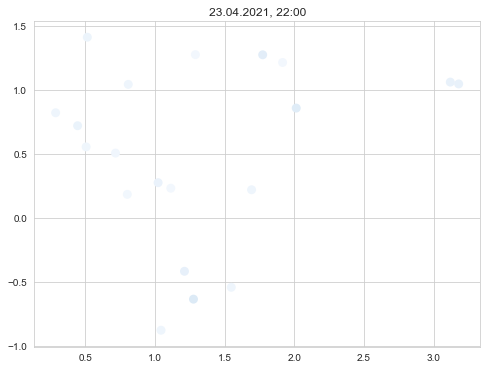

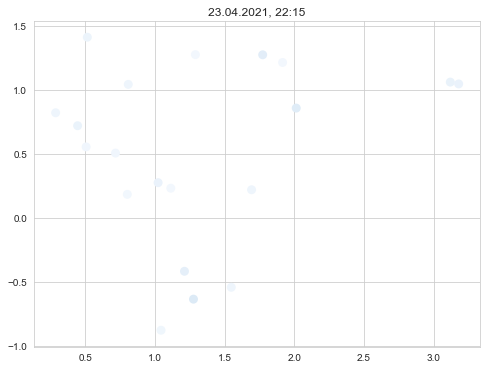

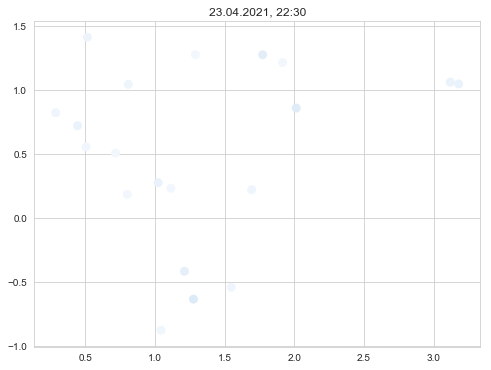

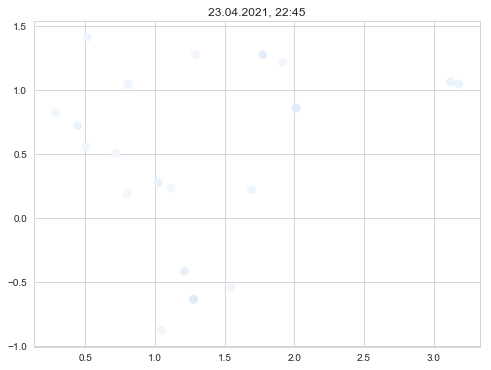

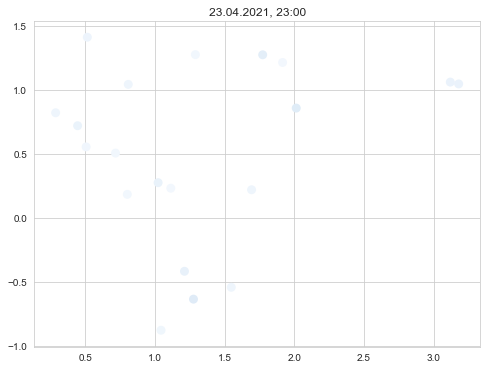

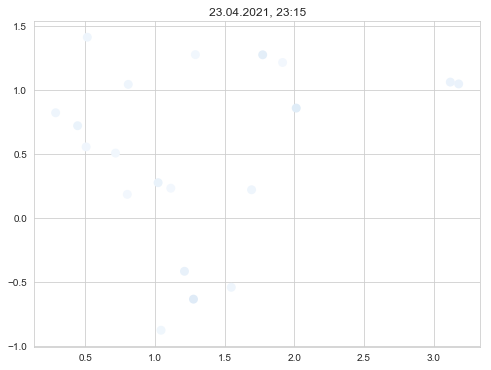

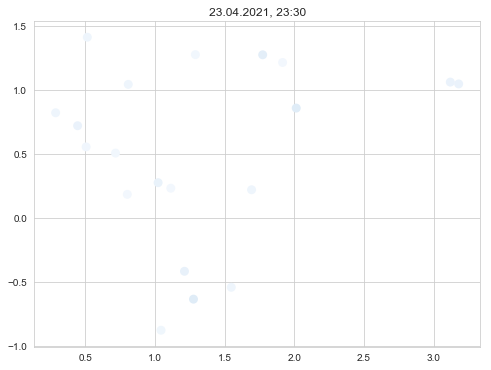

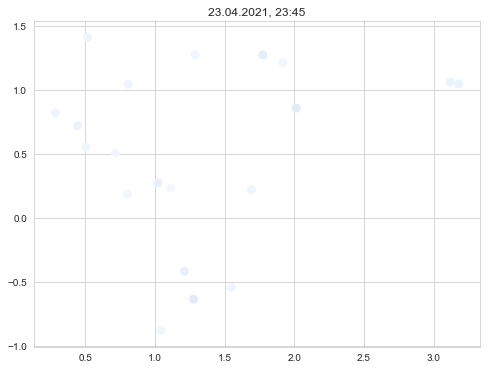

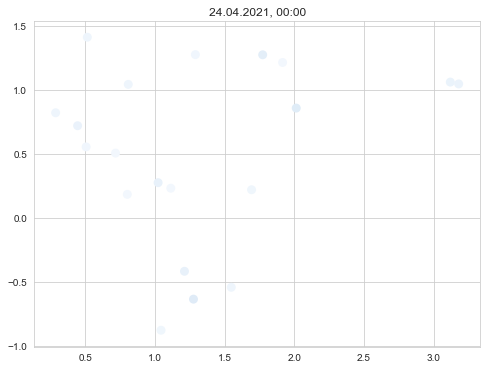

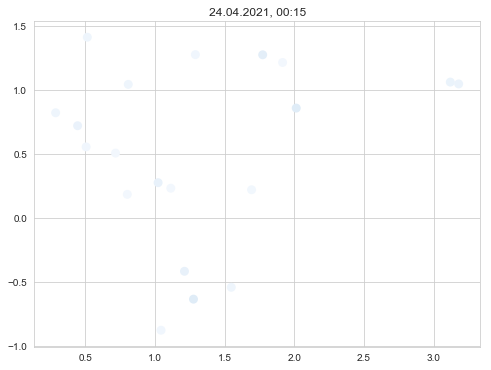

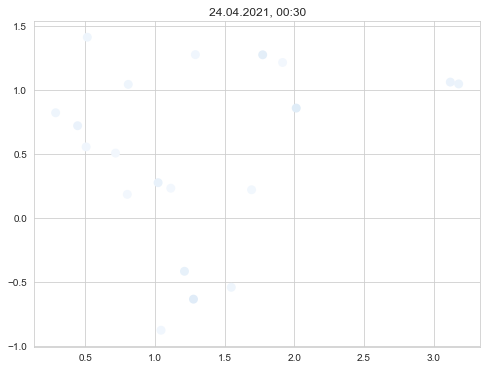

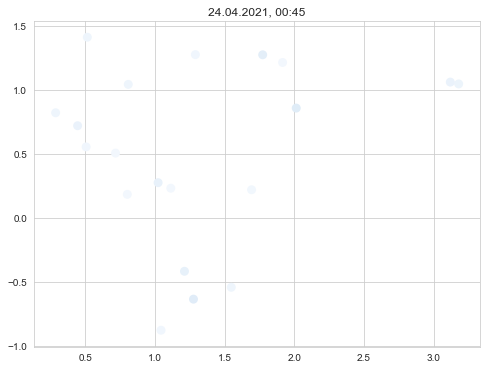

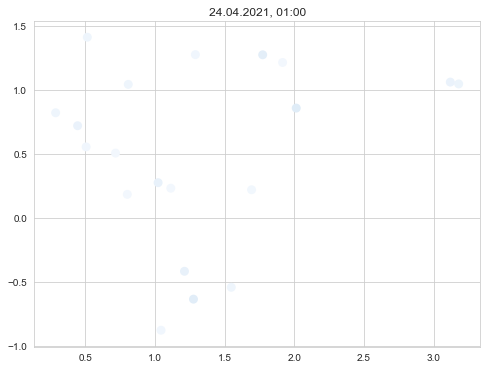

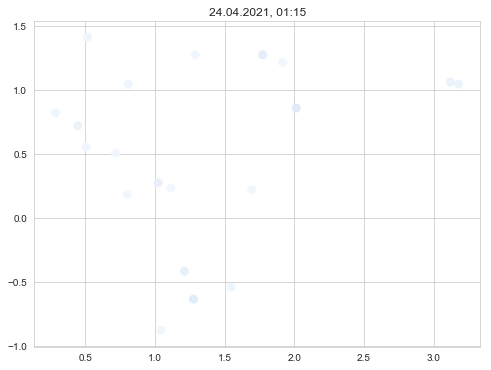

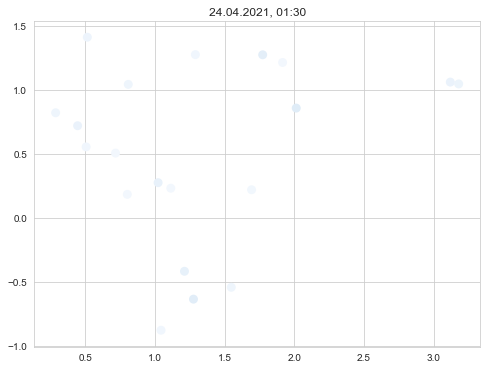

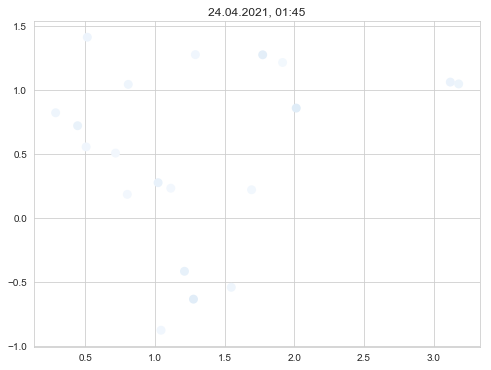

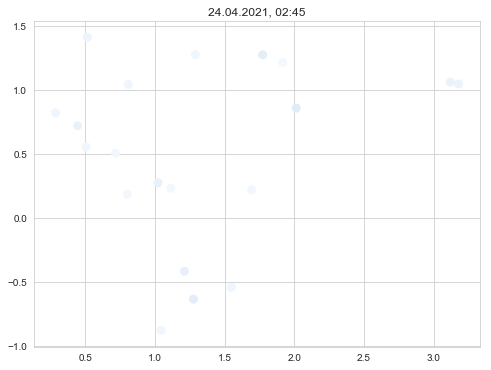

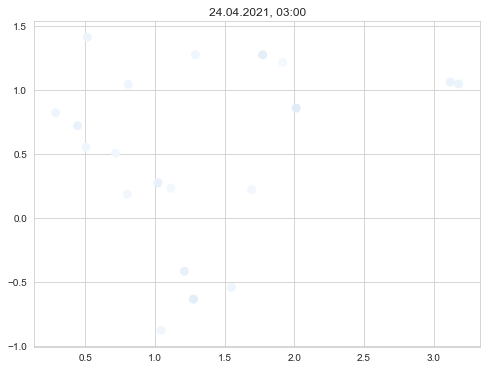

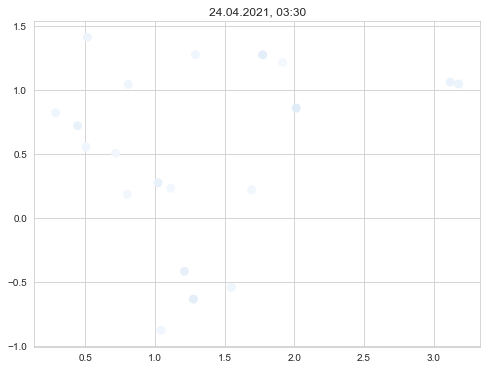

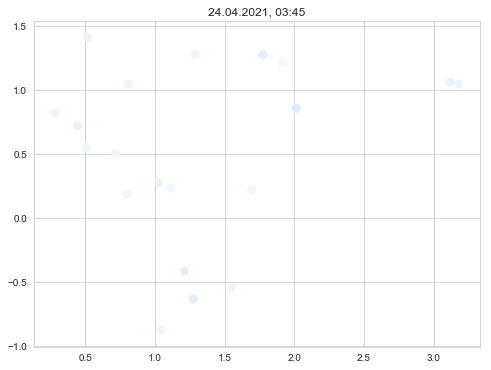

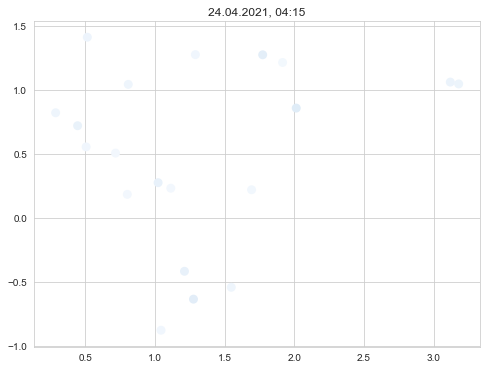

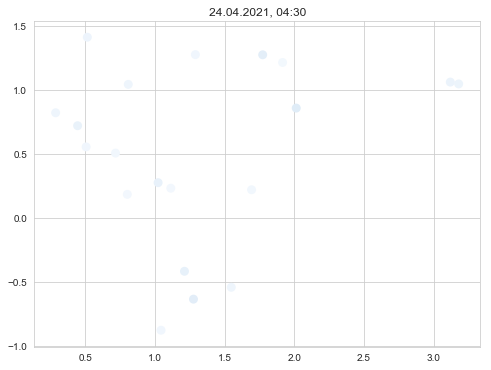

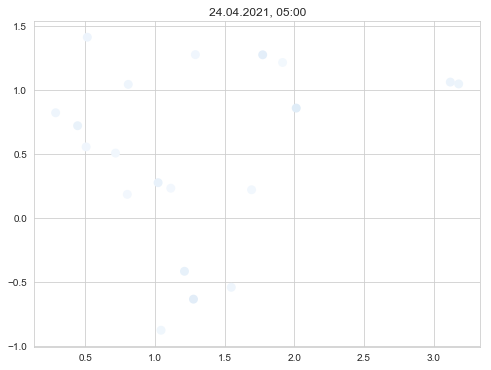

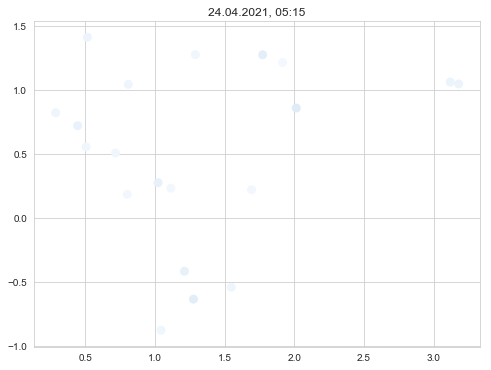

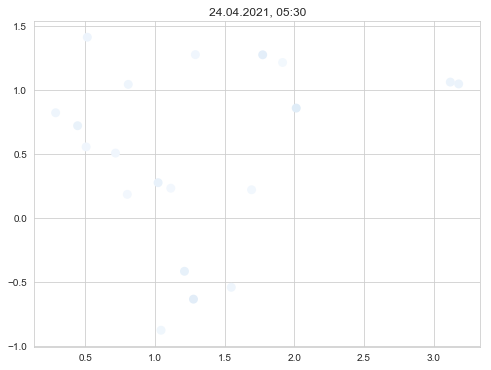

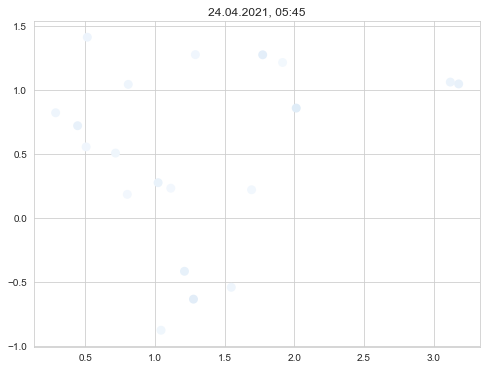

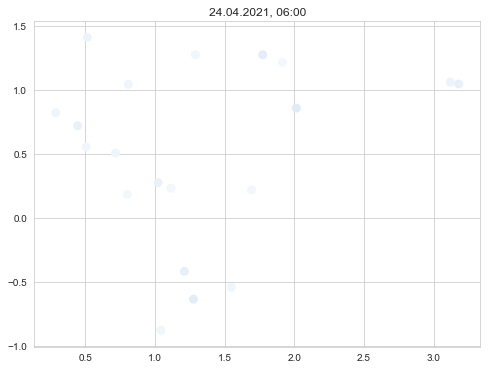

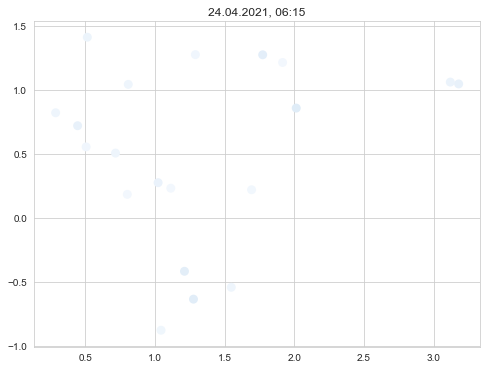

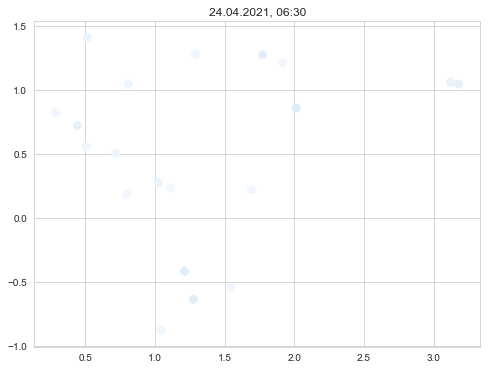

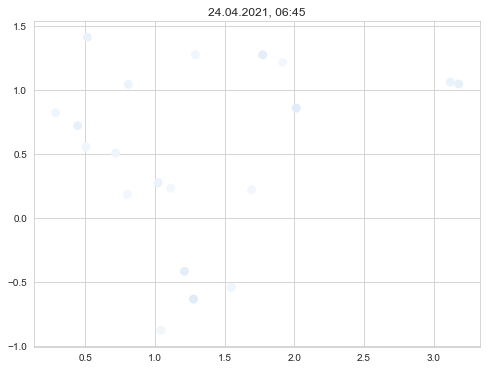

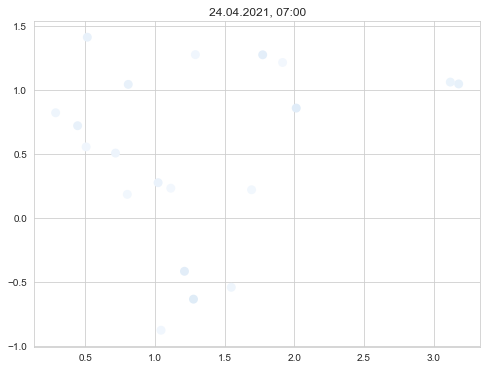

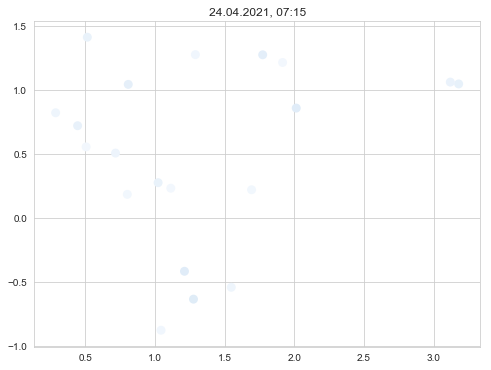

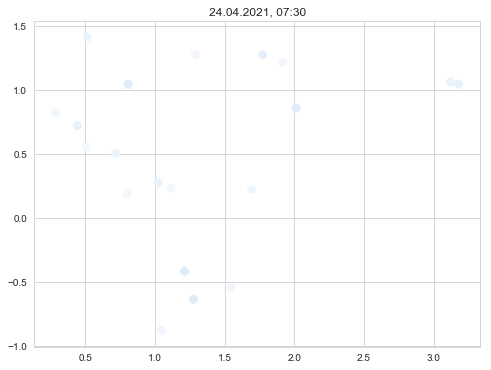

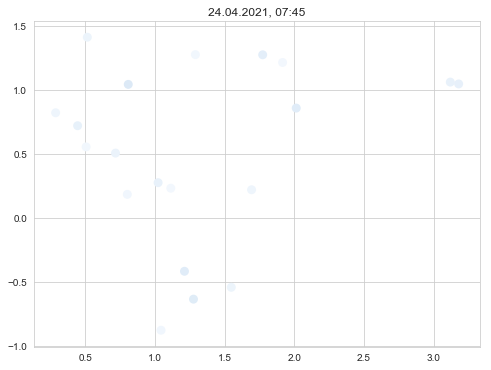

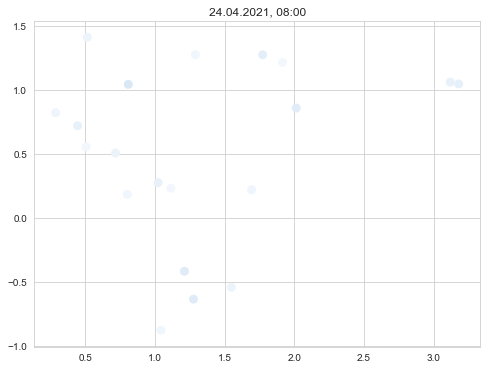

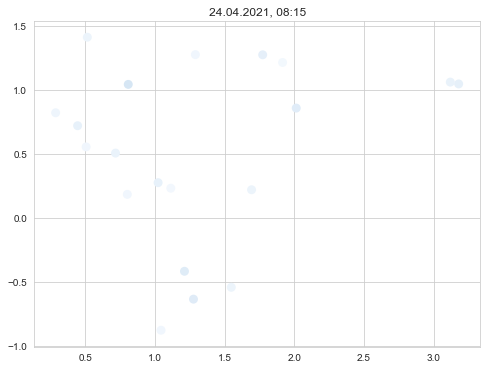

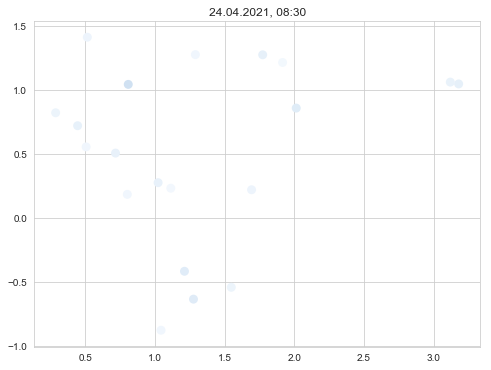

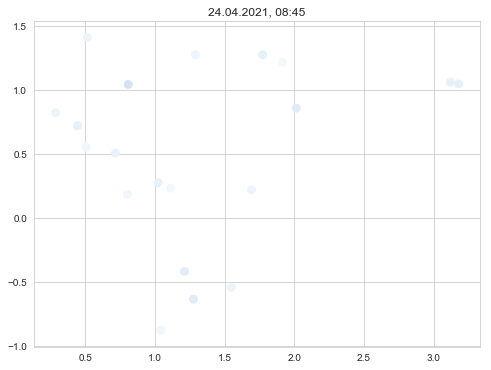

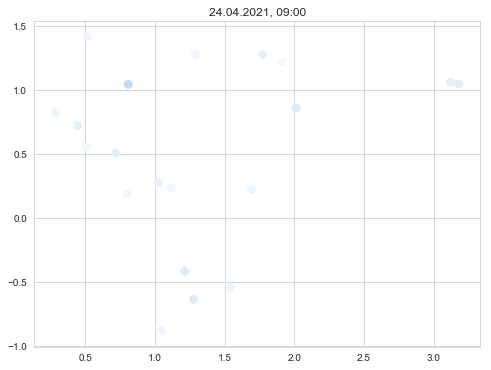

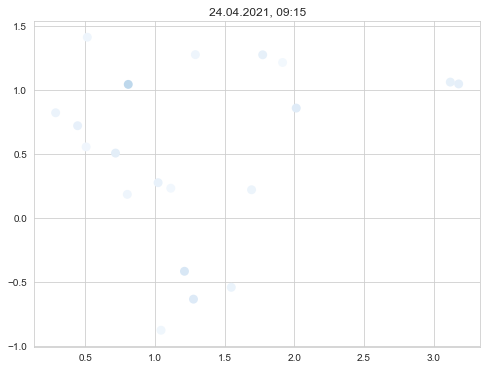

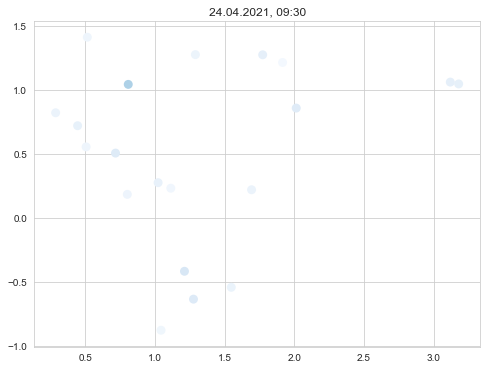

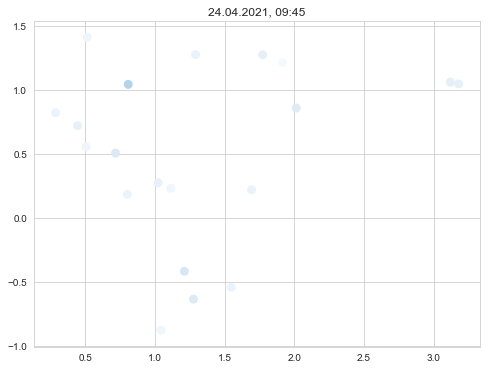

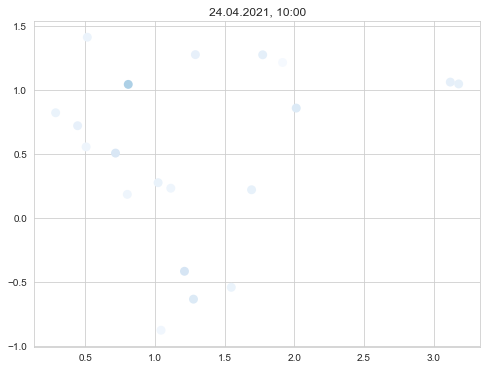

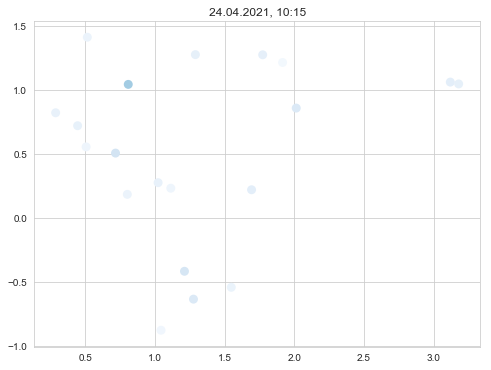

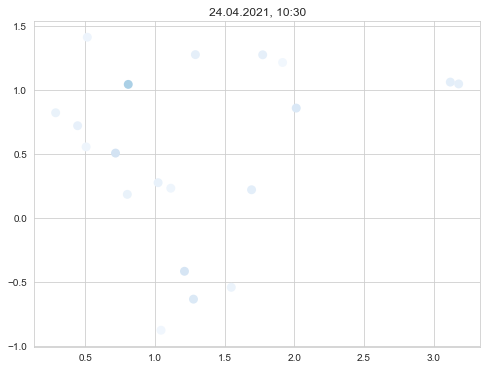

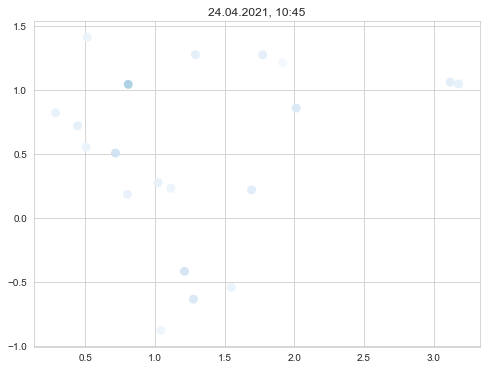

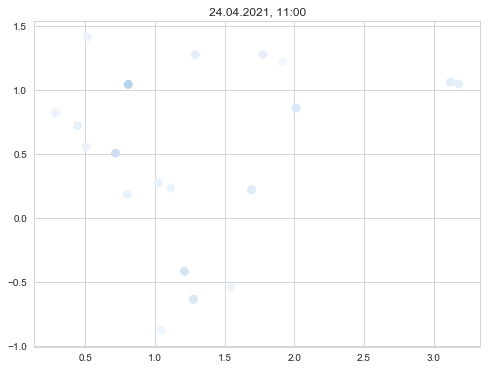

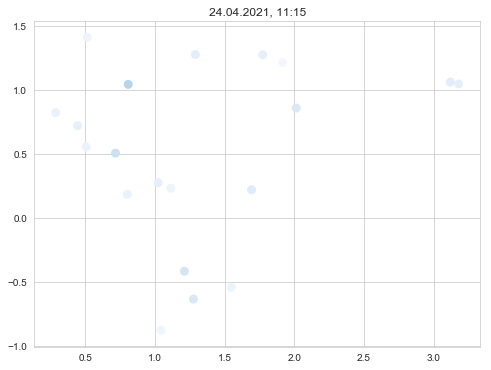

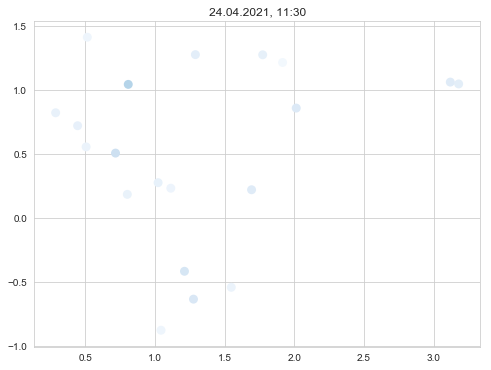

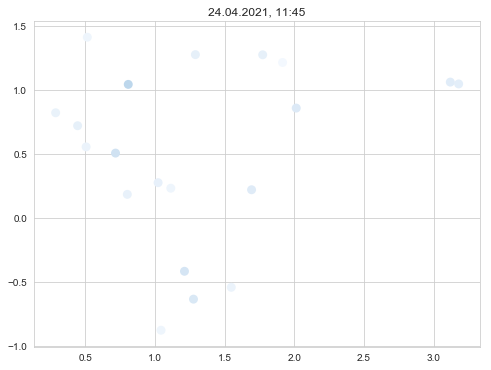

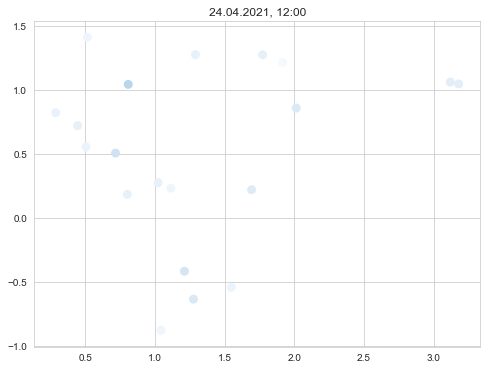

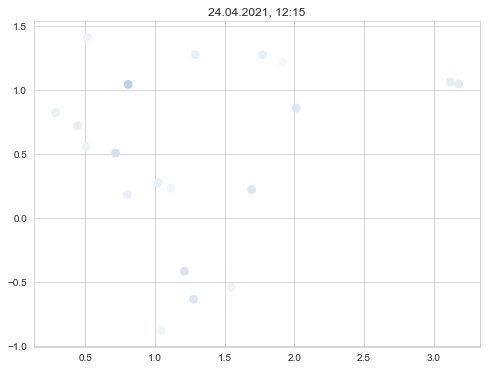

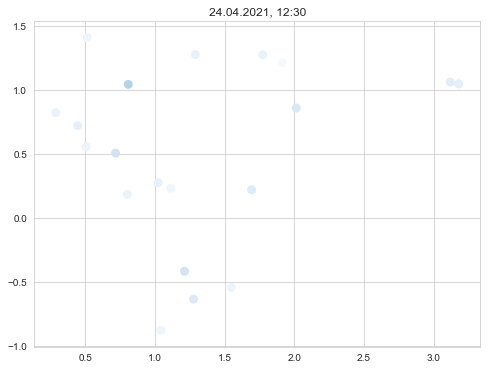

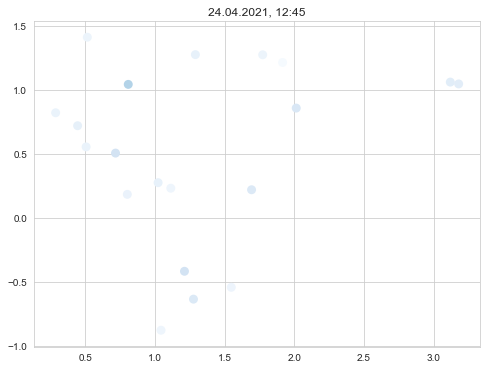

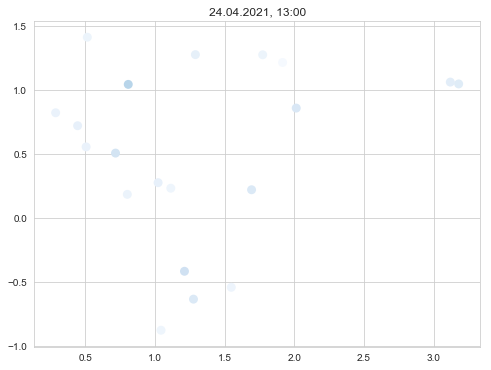

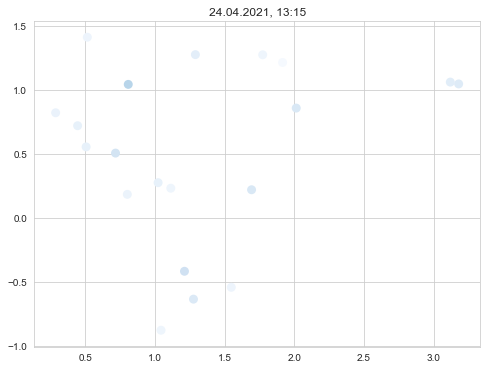

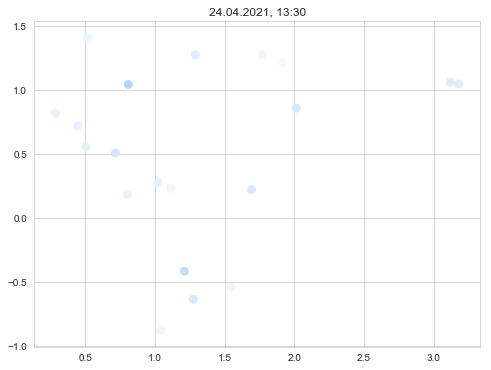

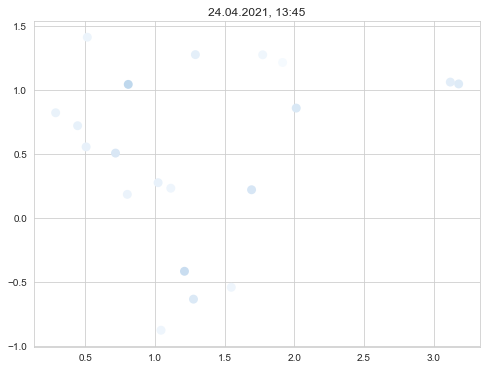

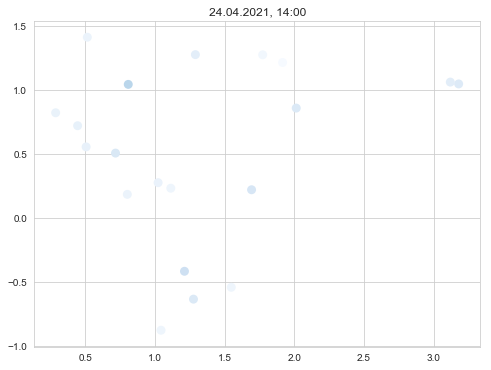

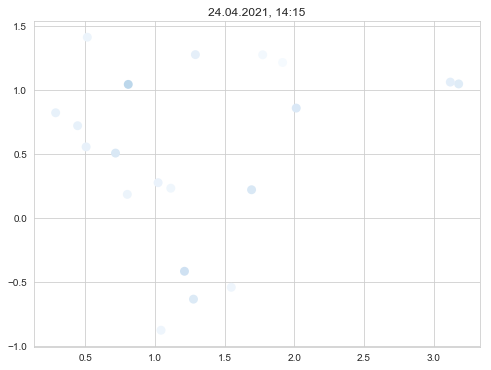

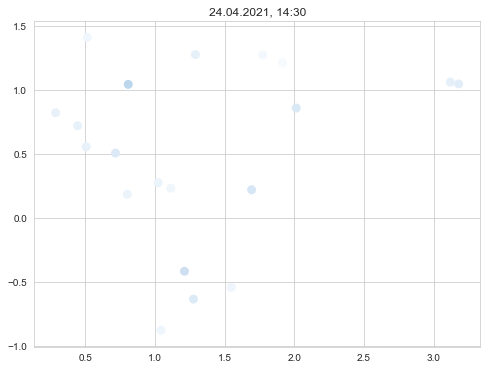

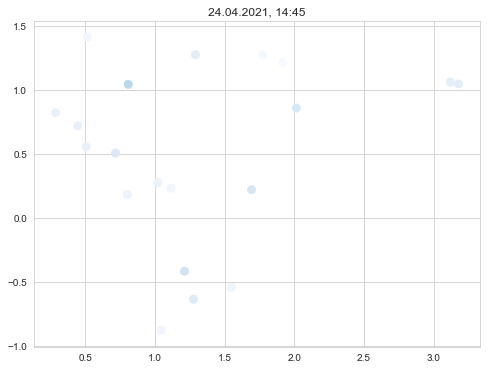

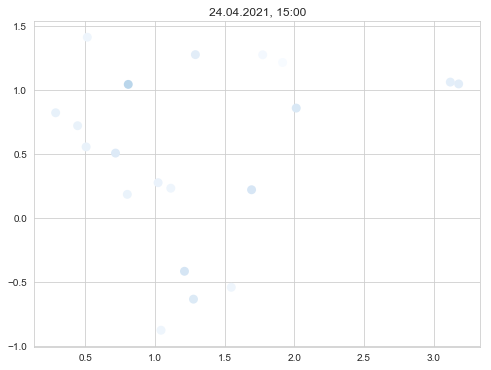

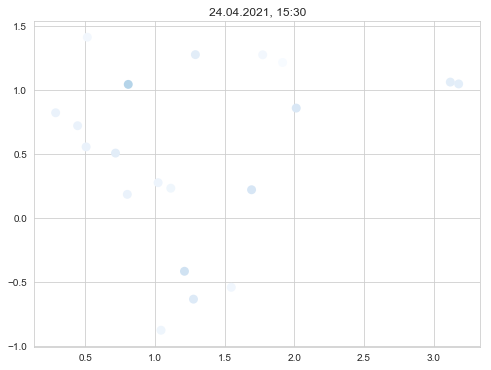

In [327]:
for timestep_index, timestamp in enumerate(all_data_for_mm_df['unix_timestamp'].unique()):
    
        data_for_mm_df = all_data_for_mm_df[all_data_for_mm_df['unix_timestamp']==timestamp]
        data_for_mm_df.index= range(len(data_for_mm_df))
        Zeit = data_for_mm_df.loc[0,'Zeit'][:-4]
        X_positions = np.array(data_for_mm_df[['adjusted_latitude', 'adjusted_longitude' ]])
        weights = np.array(data_for_mm_df['parkhaus_occupancy'])
        plt.figure(figsize=(8, 6))
        plt.scatter(X_positions[:,0], X_positions[:,1], c=weights, edgecolors='None',vmin=-13,vmax=404,cmap=plt.get_cmap("Blues"), label=weights, s=80)
        plt.title(Zeit)                   
        plt.savefig('./plots - scatter - occupancy/%s.png' % timestep_index)

### 2.4 GMM over time

KeyboardInterrupt: 

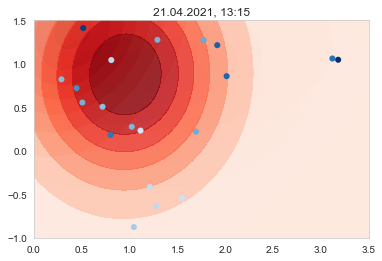

In [328]:
for timestep_index, timestamp in enumerate(all_data_for_mm_df['unix_timestamp'].unique()):
    
    data_for_mm_df = all_data_for_mm_df[all_data_for_mm_df['unix_timestamp']==timestamp]
    data_for_mm_df.index= range(len(data_for_mm_df))
    Zeit = data_for_mm_df.loc[0,'Zeit'][:-4]
    X_positions = np.array(data_for_mm_df[['adjusted_latitude', 'adjusted_longitude' ]])
    weights = np.array(data_for_mm_df['percent_occupied'])

    x = np.linspace(0,3.5,500)
    y = np.linspace(-1,1.5,500)

    xx, yy = np.meshgrid(x, y)
    x_ = np.array(list(zip(xx.flatten(), yy.flatten())))

    p1 = pomegranate.MultivariateGaussianDistribution.from_samples(X_positions,weights = weights).probability(x_).reshape(len(x), len(y))

    plt.contourf(xx, yy, p1, cmap='Reds', alpha=0.8)
    plt.scatter(X_positions[:,0], X_positions[:,1], c=weights, edgecolors='None',vmin=-0.1,vmax=1,cmap=plt.get_cmap("Blues"))
    plt.title(Zeit)                   
    plt.savefig('./plot - gmm - percent occupied/%s.png' % timestep_index)



# 3. Timeline

### 3.1 all car parks

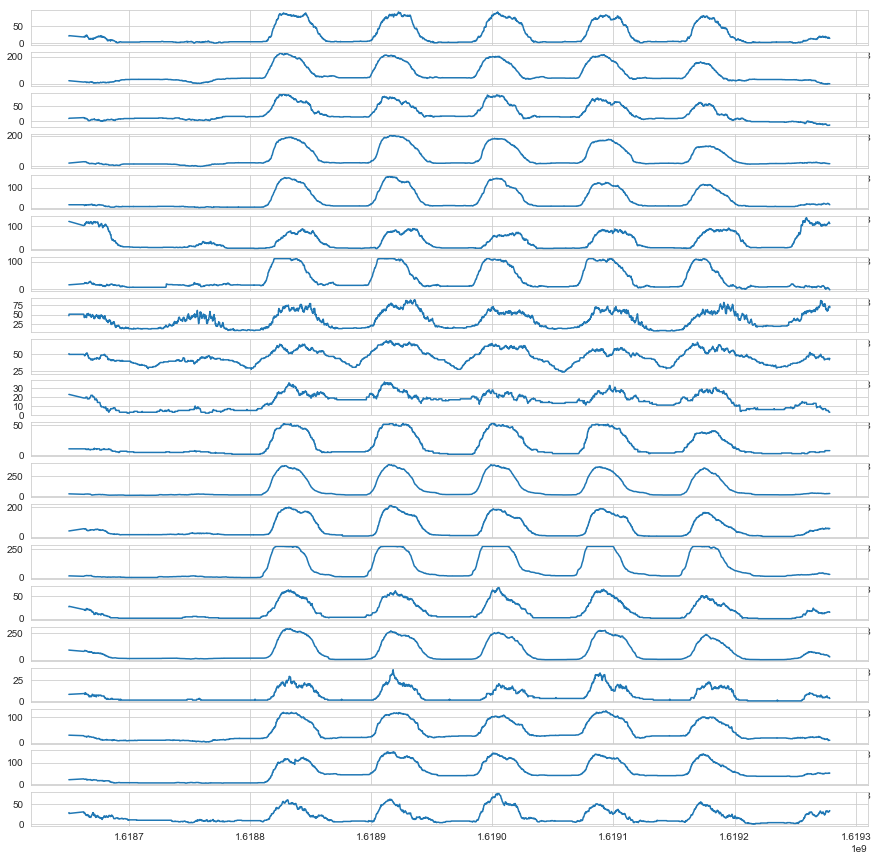

<Figure size 640x20000 with 0 Axes>

In [305]:
car_park_names = list(parkhaus_occupancies_df['parkhaus_name'].unique())
fig, axs = plt.subplots(len(car_park_names),figsize=(15,15))
for index, car_park_name in enumerate(car_park_names):
    subset_df = parkhaus_occupancies_df[parkhaus_occupancies_df['parkhaus_name']==car_park_name]
    x = list(subset_df['unix_timestamp'])
    y = list(subset_df['parkhaus_occupancy'])
    axs[index].plot(x, y)
    
plt.figure(figsize=(8, 250), dpi=80)
plt.subplots_adjust(hspace=0.0)
plt.show()

### all car parks individually

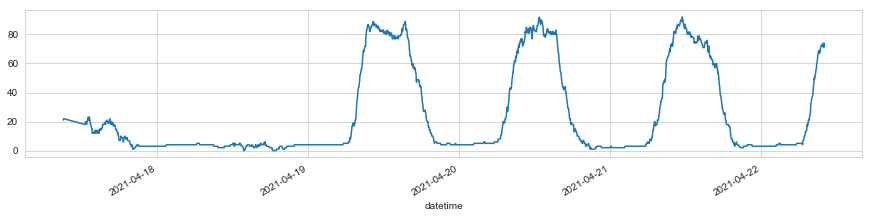

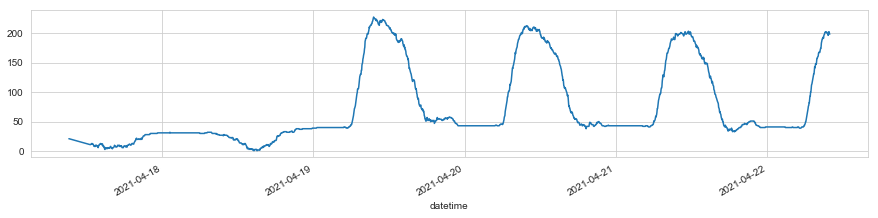

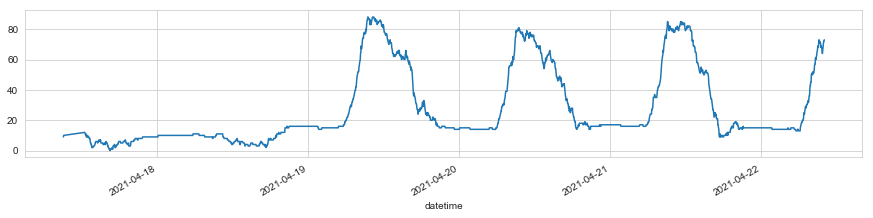

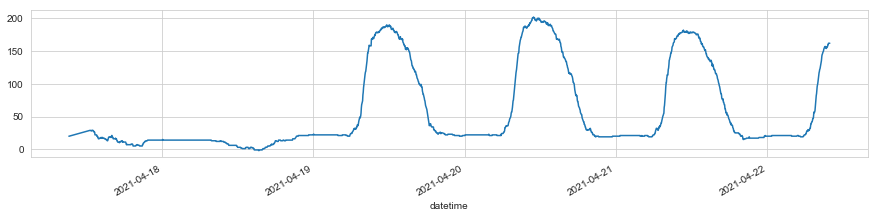

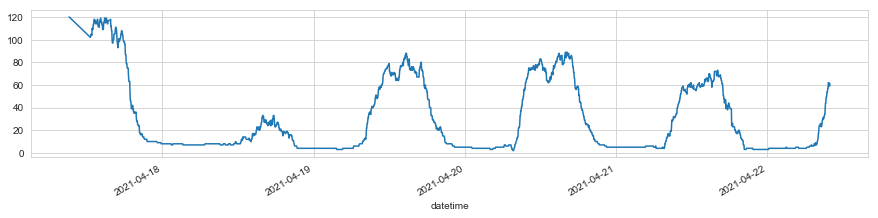

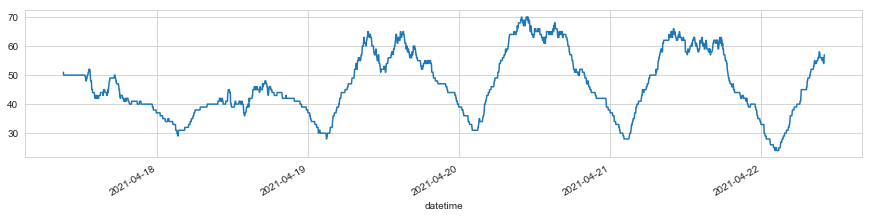

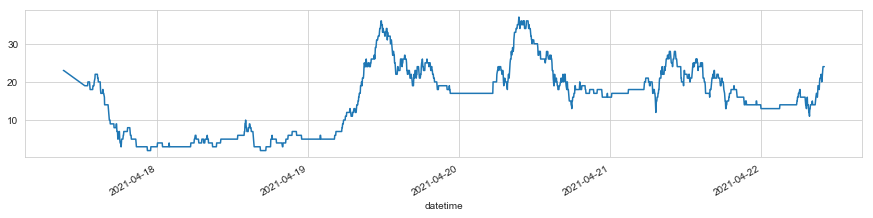

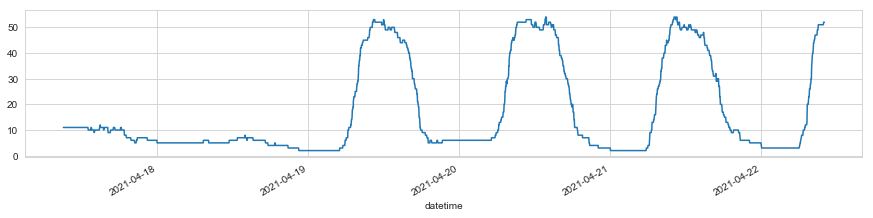

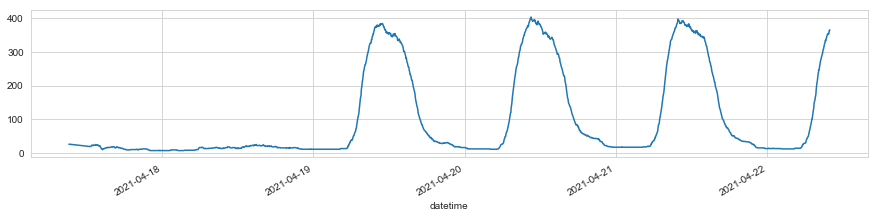

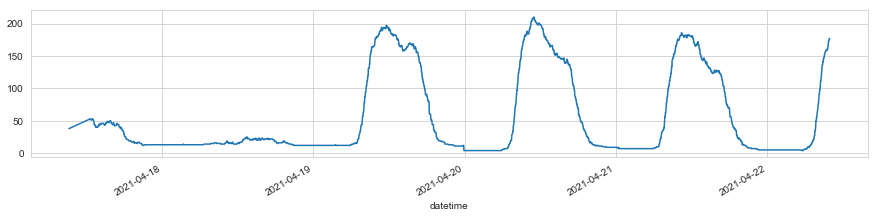

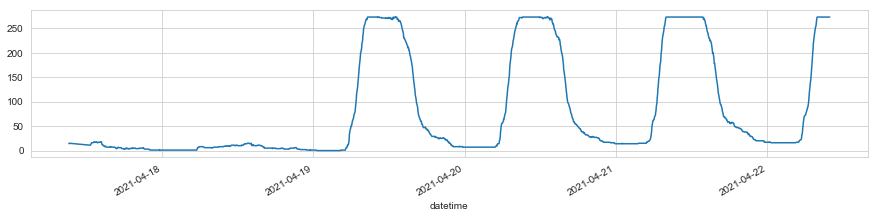

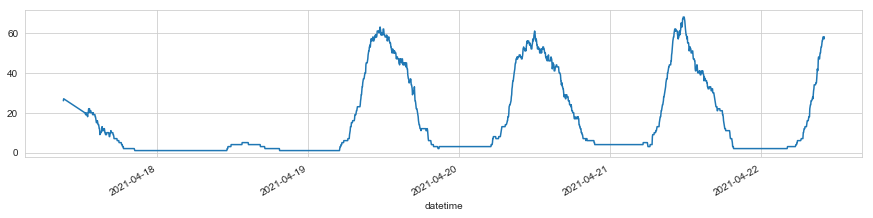

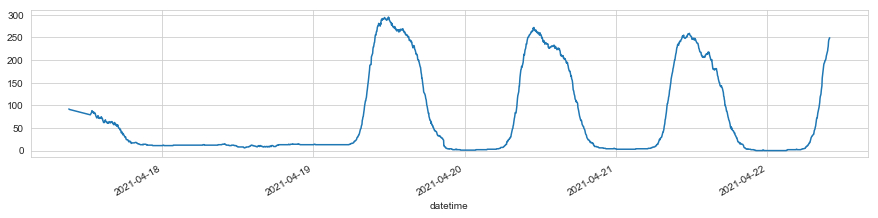

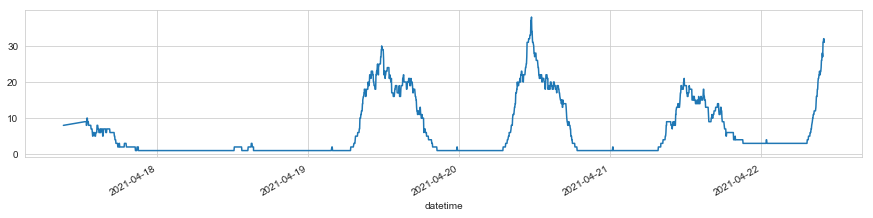

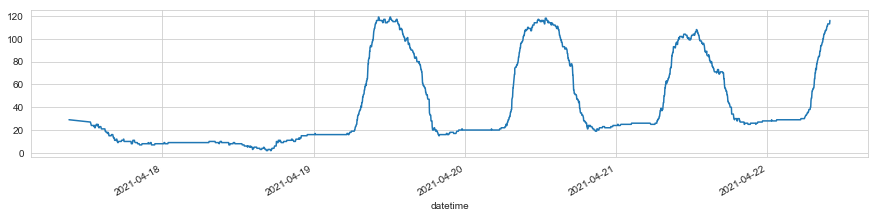

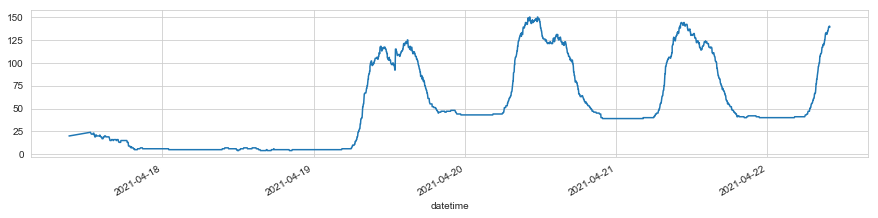

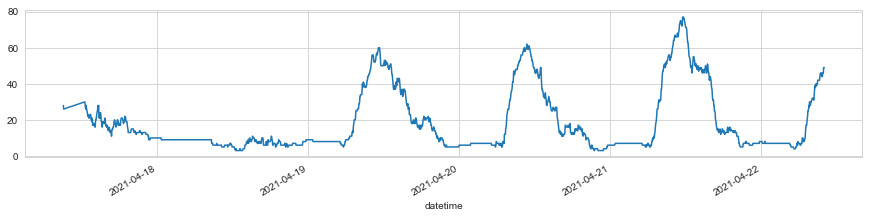

In [258]:
car_park_names = list(parkhaus_occupancies_df['parkhaus_name'].unique())

for car_park_name in car_park_names:
    subset_df = parkhaus_occupancies_df[parkhaus_occupancies_df['parkhaus_name']==car_park_name]
    plt.figure(figsize=(8, 6))
    subset_df['parkhaus_occupancy'].plot.line(figsize=(15,3))
    plt.savefig('./plots - timelines - car parks/%s.png' % car_park_name.replace('/',','))


### 3.2 total parked cars

In [306]:
total_parkers = parkhaus_occupancies_df.groupby('Zeit').aggregate({'Zeit':'first',
                                                                   'unix_timestamp':'first',
                                                                   'parkhaus_occupancy':np.sum,
                                                                   'total_number_of_places':np.sum,
                                                                   'parkhaus_free_spaces':np.sum})

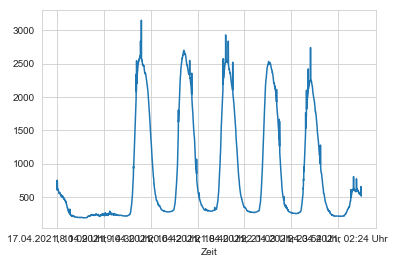

In [307]:
total_parkers['parkhaus_occupancy'].plot.line()

### 3.3 total parked cars - clean

In [308]:
# remove outliers - part 1: moving average
total_parkers['moving average'] = 0
total_parkers['index'] = range(len(total_parkers))
for i in np.arange(len(total_parkers)):
    parkhaus_occupancy_col = total_parkers.columns.get_loc('parkhaus_occupancy')
    moving_average_col = total_parkers.columns.get_loc('moving average')
    total_parkers.iloc[i, moving_average_col] = total_parkers.iloc[np.max([0,i-5]):(i+1),parkhaus_occupancy_col].mean()
    
# remove outliers - part 2: find outliers
outlier_condition = np.abs(total_parkers['parkhaus_occupancy'] - total_parkers['moving average']) > 50
outlier_condition = np.nan_to_num(outlier_condition, nan=False)
total_parkers.loc[outlier_condition ,'parkhaus_occupancy'] = total_parkers.loc[outlier_condition, 'moving average']

# # remove outliers - part 3: new moving average without outliers
# total_parkers.index = range(len(total_parkers))
# for i in np.arange(len(total_parkers)):
#     surrounding_condition = total_parkers['index'].isin(range(np.max([0,i-8]),(i+1)))
#     surrounding_condition = np.nan_to_num(surrounding_condition, nan=False)
#     total_parkers.loc[i, 'moving average'] = total_parkers.loc[np.logical_and(np.logical_not(outlier_condition), surrounding_condition),'parkhaus_occupancy'].mean()

# # remove outliers - part 4: replace outliers
# total_parkers.loc[outlier_condition ,'parkhaus_occupancy'] = total_parkers.loc[outlier_condition, 'moving average']


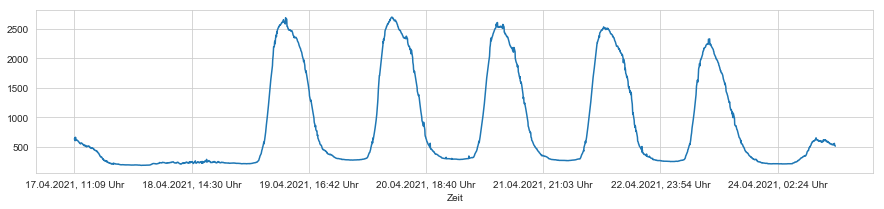

In [309]:
total_parkers['parkhaus_occupancy'].plot.line(figsize=(15,3))

### 3.4 Seasonal decomposition

In [310]:

dataset_for_decomposition = total_parkers[total_parkers['unix_timestamp']>=1618790400]
dataset_for_decomposition = dataset_for_decomposition.sort_values(by=['unix_timestamp'])

c:\programdata\miniconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


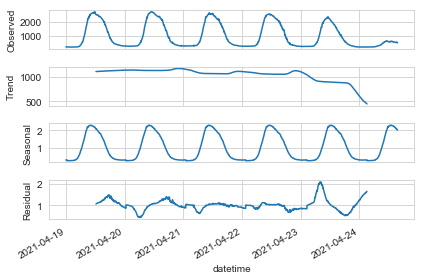

In [311]:
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
dataset_for_decomposition = total_parkers[total_parkers['unix_timestamp']>=1618790400]
dataset_for_decomposition.index = dataset_for_decomposition['unix_timestamp']
# dataset_for_decomposition.reset_index(inplace=True)
dataset_for_decomposition['datetime'] = pd.to_datetime(dataset_for_decomposition['unix_timestamp'],unit='s')
dataset_for_decomposition = dataset_for_decomposition.set_index('datetime')
dataset_for_decomposition = dataset_for_decomposition['parkhaus_occupancy']
result = seasonal_decompose(dataset_for_decomposition, model='multiplicative', freq=465)
result.plot()
pyplot.show()

c:\programdata\miniconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


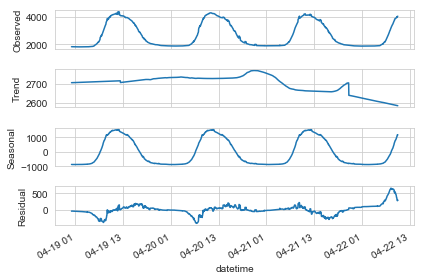

In [135]:
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
dataset_for_decomposition = total_parkers[total_parkers['unix_timestamp']>=1618790400]
dataset_for_decomposition.index = dataset_for_decomposition['unix_timestamp']
dataset_for_decomposition['datetime'] = pd.to_datetime(dataset_for_decomposition['unix_timestamp'],unit='s')
dataset_for_decomposition = dataset_for_decomposition.set_index('datetime')
dataset_for_decomposition = dataset_for_decomposition['parkhaus_occupancy']
result = seasonal_decompose(dataset_for_decomposition, model='additive', freq=465, extrapolate_trend='freq')
result.plot()
pyplot.show()


# 4. Combine the components

In [4]:
from scipy.stats import multivariate_normal


In [27]:
# extra-column: demand_due_to_cost
parkhaus_occupancies_df['demand_due_to_cost'] = 0.7246 -0.2292*parkhaus_occupancies_df['average_cost'] + 0.0215*parkhaus_occupancies_df['average_cost']*parkhaus_occupancies_df['average_cost']
parkhaus_occupancies_df['demand_due_to_cost'] = parkhaus_occupancies_df['demand_due_to_cost'] * 700
# parkhaus_occupancies_df['demand_due_to_cost'] = 452.3 -154*parkhaus_occupancies_df['average_cost'] + 16.82*parkhaus_occupancies_df['average_cost']*parkhaus_occupancies_df['average_cost']

# extra-column: demand_due_to_location
car_parks = parkhaus_occupancies_df.groupby('parkhaus_name').aggregate({'parkhaus_name':'first','latitude':'first', 'longitude':'first'})
normal_dist = multivariate_normal([8.467546, 49.489634], [[0.0000304304, 0], [0, 0.0000530395]])
car_parks['demand_due_to_location'] = 0
for index, row in car_parks.iterrows():
    demand_due_to_location = normal_dist.pdf([row['latitude'], row['longitude']])
    car_parks.loc[index,'demand_due_to_location'] = demand_due_to_location
car_parks['demand_due_to_location'] = car_parks['demand_due_to_location']/15
car_parks.index= range(len(car_parks))
parkhaus_occupancies_df = pd.merge(parkhaus_occupancies_df,car_parks[['parkhaus_name','demand_due_to_location']], on='parkhaus_name', suffixes=['','_v2'])
    

# extra-column: demand_due_to_time
mean_parker_per_timestep = parkhaus_occupancies_df.groupby('Zeit').aggregate({'Zeit':'first',
                                                                   'parkhaus_occupancy':np.mean})
mean_parker_per_timestep.index= range(len(mean_parker_per_timestep))
mean_parker_per_timestep = mean_parker_per_timestep.rename(columns={'parkhaus_occupancy':'demand_due_to_time'})
parkhaus_occupancies_df = pd.merge(parkhaus_occupancies_df, mean_parker_per_timestep[['Zeit','demand_due_to_time']], on='Zeit', suffixes=['','_v2'])

# extra-column: max_occupation
car_parks = parkhaus_occupancies_df.groupby('parkhaus_name').aggregate({'parkhaus_name':'first','parkhaus_occupancy':np.max, 'percent_occupied':np.max})
car_parks = car_parks.rename(columns={'parkhaus_occupancy':'max_parkhaus_occupancy', 'percent_occupied':'max_percent_occupied'})
car_parks.index= range(len(car_parks))
parkhaus_occupancies_df = pd.merge(parkhaus_occupancies_df,car_parks, on='parkhaus_name', suffixes=['','_v2'])


# remove rows that can't be log-ed
parkhaus_occupancies_df = parkhaus_occupancies_df[parkhaus_occupancies_df['demand_due_to_cost']>0]
parkhaus_occupancies_df = parkhaus_occupancies_df[parkhaus_occupancies_df['demand_due_to_location']>0]
parkhaus_occupancies_df = parkhaus_occupancies_df[parkhaus_occupancies_df['demand_due_to_time']>0]
parkhaus_occupancies_df = parkhaus_occupancies_df[parkhaus_occupancies_df['percent_occupied']>0]

parkhaus_occupancies_df = parkhaus_occupancies_df.sort_values(['parkhaus_name','Zeit'])


In [29]:
import pandas as pd
import statsmodels.formula.api as sm
# + np.log(demand_due_to_cost) + np.log(demand_due_to_location)
result = sm.ols(formula="np.log(parkhaus_occupancy) ~  np.log(demand_due_to_time)+ np.log(max_parkhaus_occupancy)", data=parkhaus_occupancies_df).fit()
print(result.summary())
residuals = result.resid
parkhaus_occupancies_df['residuals'] = np.exp(result.resid)

                                OLS Regression Results                                
Dep. Variable:     np.log(parkhaus_occupancy)   R-squared:                       0.674
Model:                                    OLS   Adj. R-squared:                  0.674
Method:                         Least Squares   F-statistic:                 6.620e+04
Date:                        Mon, 26 Apr 2021   Prob (F-statistic):               0.00
Time:                                13:34:37   Log-Likelihood:                -73127.
No. Observations:                       64014   AIC:                         1.463e+05
Df Residuals:                           64011   BIC:                         1.463e+05
Df Model:                                   2                                         
Covariance Type:                    nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

### 4.2 three demand_due_to_time curves (normal, market, train station)

In [25]:
# extra-column: demand_due_to_cost
parkhaus_occupancies_df['demand_due_to_cost'] = 0.7246 -0.2292*parkhaus_occupancies_df['average_cost'] + 0.0215*parkhaus_occupancies_df['average_cost']*parkhaus_occupancies_df['average_cost']
parkhaus_occupancies_df['demand_due_to_cost'] = parkhaus_occupancies_df['demand_due_to_cost'] * 700

# extra-column: demand_due_to_location
car_parks = parkhaus_occupancies_df.groupby('parkhaus_name').aggregate({'parkhaus_name':'first','latitude':'first', 'longitude':'first'})
normal_dist = multivariate_normal([8.467546, 49.489634], [[0.0000304304, 0], [0, 0.0000530395]])
car_parks['demand_due_to_location'] = 0
for index, row in car_parks.iterrows():
    demand_due_to_location = normal_dist.pdf([row['latitude'], row['longitude']])
    car_parks.loc[index,'demand_due_to_location'] = demand_due_to_location
car_parks['demand_due_to_location'] = car_parks['demand_due_to_location']/15
car_parks.index= range(len(car_parks))
parkhaus_occupancies_df = pd.merge(parkhaus_occupancies_df,car_parks[['parkhaus_name','demand_due_to_location']], on='parkhaus_name', suffixes=['','_v2'])
    
    
# extra-column: demand_due_to_time
# normal
mean_parker_per_timestep = pd.DataFrame()
mean_parker__normal = parkhaus_occupancies_df[parkhaus_occupancies_df['timeseries_group']=='normal'].groupby('Zeit').aggregate({'Zeit':'first',
                                                                   'timeseries_group':'first',
                                                                   'percent_occupied':np.mean})
mean_parker_per_timestep = mean_parker_per_timestep.append(mean_parker__normal)

# market
mean_parker__market = parkhaus_occupancies_df[parkhaus_occupancies_df['timeseries_group']=='market'].groupby('Zeit').aggregate({'Zeit':'first',
                                                                   'timeseries_group':'first',                                                                 
                                                                   'percent_occupied':np.mean})
mean_parker_per_timestep = mean_parker_per_timestep.append(mean_parker__market)

# train station
mean_parker__train_station = parkhaus_occupancies_df[parkhaus_occupancies_df['timeseries_group']=='train station'].groupby('Zeit').aggregate({'Zeit':'first',
                                                                   'timeseries_group':'first',
                                                                   'percent_occupied':np.mean})
mean_parker_per_timestep = mean_parker_per_timestep.append(mean_parker__train_station)


mean_parker_per_timestep.index= range(len(mean_parker_per_timestep))
mean_parker_per_timestep = mean_parker_per_timestep.rename(columns={'percent_occupied':'demand_due_to_time'})
parkhaus_occupancies_df = pd.merge(parkhaus_occupancies_df, mean_parker_per_timestep[['Zeit','timeseries_group','demand_due_to_time']], on=['Zeit','timeseries_group'], suffixes=['','_v2'])

# remove rows that can't be log-ed
parkhaus_occupancies_df = parkhaus_occupancies_df[parkhaus_occupancies_df['demand_due_to_cost']>0]
parkhaus_occupancies_df = parkhaus_occupancies_df[parkhaus_occupancies_df['demand_due_to_location']>0]
parkhaus_occupancies_df = parkhaus_occupancies_df[parkhaus_occupancies_df['demand_due_to_time']>0]
parkhaus_occupancies_df = parkhaus_occupancies_df[parkhaus_occupancies_df['percent_occupied']>0]

In [26]:
import pandas as pd
import statsmodels.formula.api as sm
result = sm.ols(formula="np.log(parkhaus_occupancy) ~ np.log(demand_due_to_cost) + np.log(demand_due_to_location) + np.log(demand_due_to_time)+ np.log(total_number_of_places)", data=parkhaus_occupancies_df).fit()
print(result.summary())
parkhaus_occupancies_df['residuals'] = np.exp(result.resid)
parkhaus_occupancies_df['predicted_parkhaus_occupancy'] = np.exp(result.fittedvalues)

                                OLS Regression Results                                
Dep. Variable:     np.log(parkhaus_occupancy)   R-squared:                       0.688
Model:                                    OLS   Adj. R-squared:                  0.688
Method:                         Least Squares   F-statistic:                 3.534e+04
Date:                        Mon, 26 Apr 2021   Prob (F-statistic):               0.00
Time:                                13:33:25   Log-Likelihood:                -71697.
No. Observations:                       64014   AIC:                         1.434e+05
Df Residuals:                           64009   BIC:                         1.434e+05
Df Model:                                   4                                         
Covariance Type:                    nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

# 5. Plots for better understanding

### residuals

In [7]:

parkhaus_occupancies_df = parkhaus_occupancies_df.sort_values(['parkhaus_name','Zeit'])

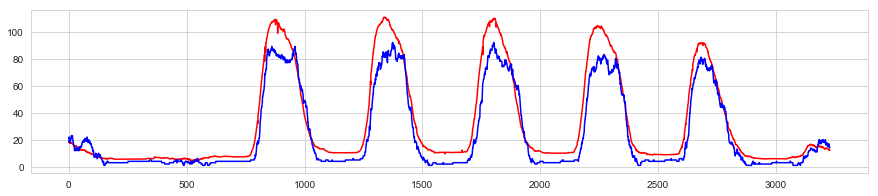

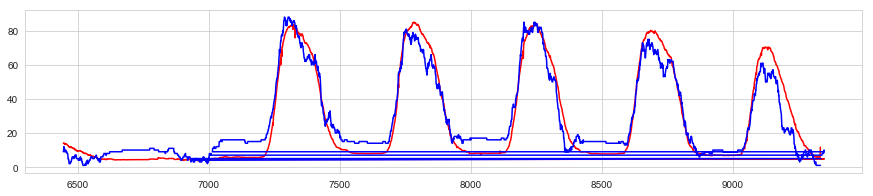

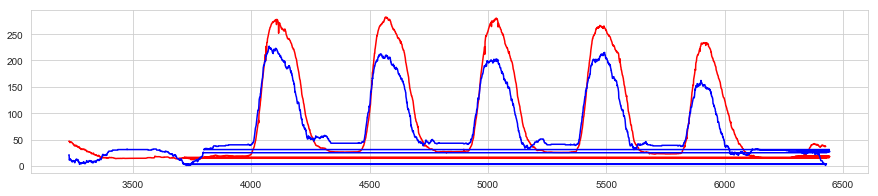

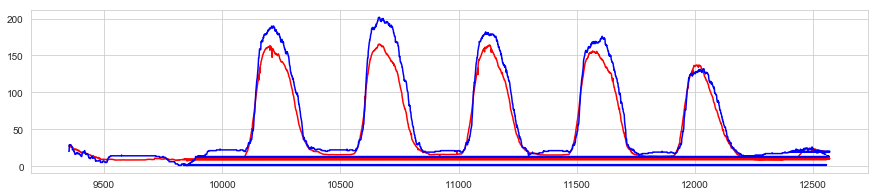

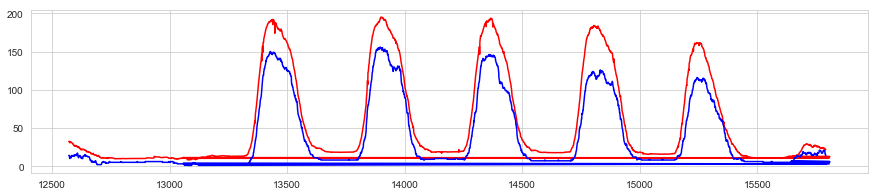

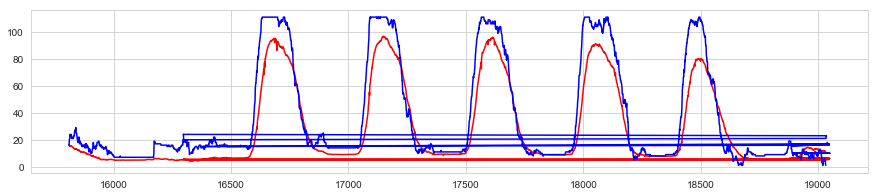

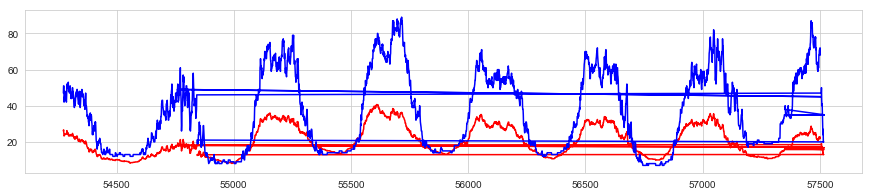

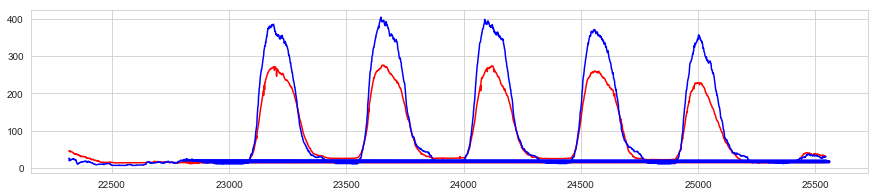

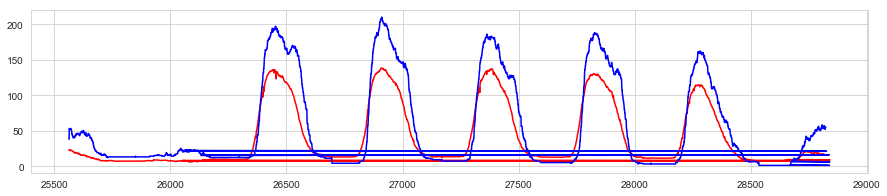

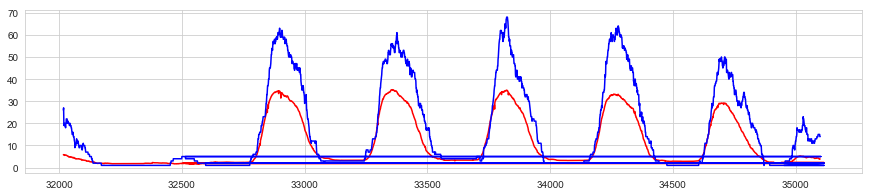

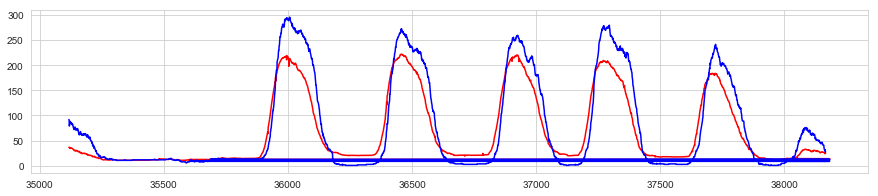

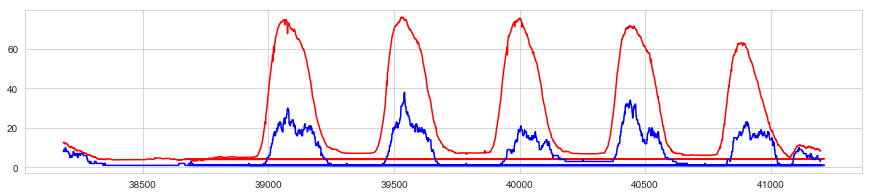

In [30]:
car_park_names = list(parkhaus_occupancies_df['parkhaus_name'].unique())

for car_park_name in car_park_names:
    subset_df = parkhaus_occupancies_df[parkhaus_occupancies_df['parkhaus_name']==car_park_name]
    plt.figure(figsize=(8, 6))
    subset_df['predicted_parkhaus_occupancy'].plot.line(figsize=(15,3), color='red')
    subset_df['parkhaus_occupancy'].plot.line(figsize=(15,3), color='blue')
    plt.savefig('./plots - timelines - predictions/%s.png' % car_park_name.replace('/',','))

### parkhaus_occupancy

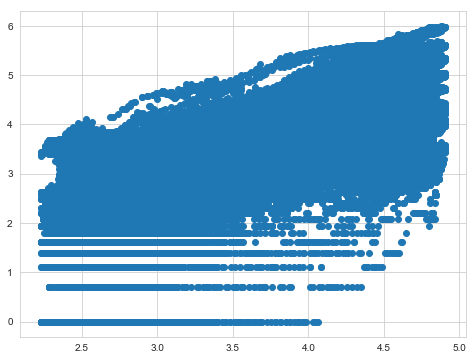

In [61]:
# x = parkhaus_occupancies_df['log_demand_due_to_cost']
# x = parkhaus_occupancies_df['log_demand_due_to_location']
x = np.log(parkhaus_occupancies_df['demand_due_to_time'])
y = np.log(parkhaus_occupancies_df['parkhaus_occupancy'])

# mymodel = np.poly1d(np.polyfit(x, y, 2))
# myline = np.linspace(1, 5, 100)

plt.figure(figsize=(8, 6))
plt.scatter(x, y)
plt.show()

### percent_occupied

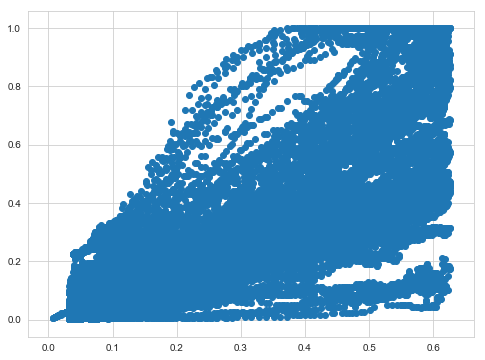

In [541]:
# x = parkhaus_occupancies_df['demand_due_to_cost']
# x = parkhaus_occupancies_df['demand_due_to_location']
x = parkhaus_occupancies_df['demand_due_to_time']
y = parkhaus_occupancies_df['percent_occupied']

plt.figure(figsize=(8, 6))
plt.scatter(x, y)
plt.show()

### with scikit-learn

In [169]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
regr.fit(X, y)
print('y_intercept: ' + str(regr.intercept_))
print('regr coeff: ' + str(regr.coef_))


sample_df = parkhaus_occupancies_df.sample(400)
X_evaluation = sample_df[['demand_due_to_cost', 'demand_due_to_location', 'demand_due_to_time']].to_numpy()
y_evaluation = np.array(sample_df['parkhaus_occupancy'])
print('score: ' + str(regr.score(X_evaluation, y_evaluation)))

y_intercept: -65.41842085020677
regr coeff: [ 0.7117116  -0.16773658  1.0002891 ]
score: 0.17520644704960675


In [95]:
sample_df['predicted_value'] = regr.predict(np.array(sample_df[['demand_due_to_cost', 'demand_due_to_location', 'demand_due_to_time']]))

In [170]:
sample_df[['parkhaus_name','Zeit','average_cost','demand_due_to_cost', 'demand_due_to_location', 'demand_due_to_time','parkhaus_occupancy', 'predicted_value']][:40]

KeyError: "['predicted_value'] not in index"